<div style="text-align:left; font-size:13pt; font-family:'Tahoma','Verdana',sans-serif; line-height:1.8;">

# üöó Vehicle Insurance Claim Prediction  

This project focuses on analyzing a **vehicle insurance dataset** and building predictive models.  
We explore key policy and vehicle-related features to gain insights and create two types of models:  

1. **Classification Model** üß©  
   - üéØ Target: `CLAIM_FLAG` (0 = No Claim, 1 = Claim)  
   - Goal: Predict whether a new insurance contract will result in a claim or not.  

2. **Regression Model** üìà  
   - üéØ Target: `CLAIM_PAID` (numeric value of claim amount)  
   - Goal: Estimate the potential claim amount for policies that have a claim.  

---

## üìä Dataset Overview  

The dataset includes **policy details, vehicle specifications, and claim information**.  
Key features:  

- `SEX` ‚Üí Gender of policyholder (0=Male, 1=Female, 2=Organization)  
- `INSR_BEGIN`, `INSR_END`, `EFFECTIVE_YR` ‚Üí Policy duration and effective year  
- `INSR_TYPE` ‚Üí Type of insurance  
- `INSURED_VALUE`, `PREMIUM` ‚Üí Policy financial details  
- `PROD_YEAR`, `SEATS_NUM`, `CARRYING_CAPACITY` ‚Üí Vehicle specifications  
- `TYPE_VEHICLE`, `CCM_TON`, `MAKE`, `USAGE` ‚Üí Vehicle type and usage  
- `CLAIM_PAID` ‚Üí Claim amount (used for regression)  

From these, we will engineer **`CLAIM_FLAG`** as the main target for classification.  

---

## üéØ Project Goals  

- üßπ Perform **data cleaning & feature engineering** (handling missing values, ratios, binary flags, etc.).  
- üîé Conduct **EDA (Exploratory Data Analysis)** with visualizations to extract insights.  
- ü§ñ Train and evaluate **classification models** (e.g., CatBoost, RandomForest) to predict `CLAIM_FLAG`.  
- üìà Build **regression models** to estimate `CLAIM_PAID` for claim-positive cases.  
- üí° Provide actionable **business insights** for risk management and insurance pricing.  

---

‚ú® By combining **analytics and machine learning**, this project aims to improve **risk assessment** and support **data-driven decisions** in vehicle insurance.  

</div>


from IPython.display import HTML
HTML("""
<style>
/* JupyterLab/Classic */
.jp-RenderedHTMLCommon, .jp-OutputArea-output {
  direction: rtl;
  text-align: right;
}
.jp-RenderedHTMLCommon ul, .jp-RenderedHTMLCommon ol {
  direction: rtl;
  padding-right: 1.2em;
}
/* VS Code Notebook (Ÿàÿ®‚ÄåŸà€åŸà) ‚Äî ÿß⁄Øÿ± JupyterLab ŸÜÿ®ŸàÿØÿå ÿß€åŸÜ ŸáŸÖ ⁄©ŸÖ⁄© ŸÖ€å‚Äå⁄©ŸÜÿØ */
div.rendered_html, div.output, .markdown-body {
  direction: rtl !important;
  text-align: right !important;
}
</style>
""")

##### üì¶ Importing required libraries for data analysis, visualization, and model building


In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.preprocessing import  OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,mean_absolute_error,precision_recall_curve, mean_squared_error,r2_score , f1_score, precision_score, recall_score, roc_curve, auc , classification_report, confusion_matrix,classification_report, roc_auc_score, f1_score
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer , TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.utils import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

##### üìÇ Extracting dataset from ZIP and loading insurance data (2011‚Äì2018)


In [2]:
zip_path = '../Dataset//Vehicle Insurance Data.zip'
extracted_folder = '../Dataset//Vehicle Insurance Data/'
if not os.path.exists(extracted_folder):
    os.makedirs(extracted_folder)
if not os.path.exists(zip_path):
    print(f"Error: The zip file {zip_path} does not exist.")
else:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_folder)

# Load the dataset
df_2001_2014 = pd.read_csv('../Dataset//Vehicle Insurance Data//motor_data11-14lats.csv')
df_2014_2018 = pd.read_csv('../Dataset//Vehicle Insurance Data//motor_data14-2018.csv')
df = pd.concat([df_2001_2014, df_2014_2018], ignore_index=True)

df.head(5)

SEX INSR_BEGIN   INSR_END EFFECTIVE_YR  INSR_TYPE  INSURED_VALUE   PREMIUM  \
0    0  08-AUG-13  07-AUG-14           08       1202      519755.22  7209.140   
1    0  08-AUG-12  07-AUG-13           08       1202      519755.22  7203.890   
2    0  08-AUG-11  07-AUG-12           08       1202      519755.22  7045.804   
3    0  08-JUL-11  07-AUG-11           08       1202      519755.22   287.250   
4    0  08-AUG-13  07-AUG-14           08       1202      285451.24  4286.900   

    OBJECT_ID  PROD_YEAR  SEATS_NUM  CARRYING_CAPACITY TYPE_VEHICLE  CCM_TON  \
0  5000029885     2007.0        4.0                6.0      Pick-up   3153.0   
1  5000029885     2007.0        4.0                6.0      Pick-up   3153.0   
2  5000029885     2007.0        4.0                6.0      Pick-up   3153.0   
3  5000029885     2007.0        4.0                6.0      Pick-up   3153.0   
4  5000029901     2010.0        4.0                7.0      Pick-up   2494.0   

     MAKE      USAGE  CLAIM_PAID  
0  NISSAN  Own Goods         NaN  
1  NISSAN  Own Goods         NaN  
2  NISSAN  Own Goods         NaN  
3  NISSAN  Own Goods         NaN  
4  TOYOTA  Own Goods    19894.43

In [3]:
df.tail(5)

SEX INSR_BEGIN   INSR_END EFFECTIVE_YR  INSR_TYPE  INSURED_VALUE  \
802031    0  02-FEB-18  01-FEB-19           12       1202            0.0   
802032    0  02-FEB-18  01-FEB-19           12       1202            0.0   
802033    0  02-FEB-18  01-FEB-19           12       1202            0.0   
802034    0  02-FEB-18  01-FEB-19           12       1202            0.0   
802035    0  02-FEB-18  01-FEB-19           12       1202            0.0   

        PREMIUM   OBJECT_ID  PROD_YEAR  SEATS_NUM  CARRYING_CAPACITY  \
802031   294.51  5001350484     2018.0        4.0                7.0   
802032   299.51  5001350489     2018.0        4.0                7.0   
802033   294.51  5001350498     2018.0        4.0                7.0   
802034   294.51  5001350502     2018.0        4.0                7.0   
802035   294.51  5001350505     2018.0        4.0                7.0   

       TYPE_VEHICLE  CCM_TON    MAKE      USAGE  CLAIM_PAID  
802031      Pick-up   2400.0  TOYOTA  Own Goods         NaN  
802032      Pick-up   2400.0  TOYOTA  Own Goods         NaN  
802033      Pick-up   2400.0  TOYOTA  Own Goods         NaN  
802034      Pick-up   2400.0  TOYOTA  Own Goods         NaN  
802035      Pick-up   2400.0  TOYOTA  Own Goods         NaN

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802036 entries, 0 to 802035
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SEX                802036 non-null  int64  
 1   INSR_BEGIN         802036 non-null  object 
 2   INSR_END           802036 non-null  object 
 3   EFFECTIVE_YR       802032 non-null  object 
 4   INSR_TYPE          802036 non-null  int64  
 5   INSURED_VALUE      802036 non-null  float64
 6   PREMIUM            802015 non-null  float64
 7   OBJECT_ID          802036 non-null  int64  
 8   PROD_YEAR          801867 non-null  float64
 9   SEATS_NUM          801801 non-null  float64
 10  CARRYING_CAPACITY  603837 non-null  float64
 11  TYPE_VEHICLE       802036 non-null  object 
 12  CCM_TON            802028 non-null  float64
 13  MAKE               802031 non-null  object 
 14  USAGE              802036 non-null  object 
 15  CLAIM_PAID         60145 non-null   float64
dtypes:

In [5]:
df.describe()  # Get a statistical summary of the DataFrame

SEX      INSR_TYPE  INSURED_VALUE       PREMIUM  \
count  802036.000000  802036.000000   8.020360e+05  8.020150e+05   
mean        0.567092    1201.742123   5.091294e+05  7.406987e+03   
std         0.644430       0.440322   9.017833e+05  1.352456e+04   
min         0.000000    1201.000000   0.000000e+00  0.000000e+00   
25%         0.000000    1201.000000   0.000000e+00  7.557000e+02   
50%         0.000000    1202.000000   1.800000e+05  3.376550e+03   
75%         1.000000    1202.000000   7.300000e+05  9.643270e+03   
max         2.000000    1204.000000   2.500000e+08  7.581230e+06   

          OBJECT_ID      PROD_YEAR      SEATS_NUM  CARRYING_CAPACITY  \
count  8.020360e+05  801867.000000  801801.000000      603837.000000   
mean   5.000453e+09    2004.533970       6.130357         497.877618   
std    3.444165e+05      10.227981      13.403486        3861.218481   
min    5.000018e+09    1950.000000       0.000000           0.000000   
25%    5.000160e+09    2000.000000       1.000000           0.000000   
50%    5.000380e+09    2008.000000       4.000000           6.000000   
75%    5.000718e+09    2012.000000       4.000000          35.000000   
max    5.001351e+09    2018.000000     199.000000     1000000.000000   

             CCM_TON    CLAIM_PAID  
count  802028.000000  6.014500e+04  
mean     3172.698129  2.564802e+05  
std      3445.455114  1.495336e+06  
min         0.000000  0.000000e+00  
25%       200.000000  1.350000e+04  
50%      2494.000000  3.463352e+04  
75%      4164.000000  1.338690e+05  
max     20000.000000  1.524458e+08

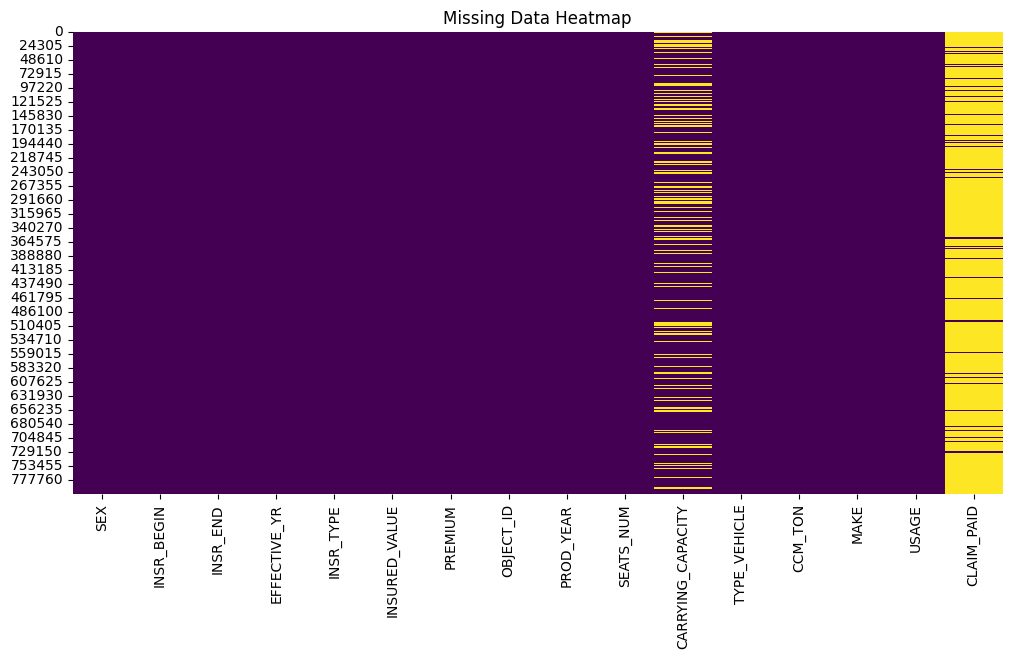

In [6]:
# Function to plot missing data heatmap
def plot_missing_data(data):
    plt.figure(figsize=(12, 6))
    sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Data Heatmap')
    plt.show()
plot_missing_data(df)

In [7]:
total_len = len(df)
print("Total records:", total_len)
Claim_paid_na = df["CLAIM_PAID"].isna().sum()
print("CLAIM_PAID is NaN:", Claim_paid_na, "records")
print("Percentage of NaN CLAIM_PAID:", (Claim_paid_na / total_len) * 100, "%")

Total records: 802036
CLAIM_PAID is NaN: 741891 records
Percentage of NaN CLAIM_PAID: 92.50096005665581 %


In [8]:
# Convert insurance date columns to datetime format
df["INSR_BEGIN"] = pd.to_datetime(df["INSR_BEGIN"], errors="coerce")
df["INSR_END"]   = pd.to_datetime(df["INSR_END"], errors="coerce")

# Filter the records where CLAIM_PAID is missing (NaN)
missing_claims = df[df["CLAIM_PAID"].isna()]

# Define "today" as one day after the latest insurance end date in the dataset
today = max(df['INSR_END']) + pd.Timedelta(days=1)
print("Today:", today)

# Count the number of missing claims where the policy has already expired
expired = missing_claims[missing_claims["INSR_END"] < today]
print("Expired but NaN Claim:", expired.shape[0])

# Count the number of missing claims where the policy is still active
active = missing_claims[missing_claims["INSR_END"] >= today]
print("Active but NaN Claim:", active.shape[0])

Today: 2019-06-30 00:00:00
Expired but NaN Claim: 741891
Active but NaN Claim: 0


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### üßπ ŸÖÿØ€åÿ±€åÿ™ ŸÖŸÇÿßÿØ€åÿ± ⁄ØŸÖÿ¥ÿØŸá ÿØÿ± ÿ≥ÿ™ŸàŸÜ ÿÆÿ≥ÿßÿ±ÿ™ (CLAIM_PAID)

- ÿØÿ± ÿØ€åÿ™ÿßÿ≥ÿ™ ŸÖÿ¥ÿßŸáÿØŸá ÿ¥ÿØ ⁄©Ÿá ÿ≥ÿ™ŸàŸÜ **ÿÆÿ≥ÿßÿ±ÿ™ Ÿæÿ±ÿØÿßÿÆÿ™€å (CLAIM_PAID)** ÿ®ÿ±ÿß€å ÿ≠ÿØŸàÿØ **€π€≥Ÿ™ ÿ±⁄©Ÿàÿ±ÿØŸáÿß ŸÖŸÇÿØÿßÿ± ÿÆÿßŸÑ€å** ÿØÿßÿ±ÿØ.  
- ÿ®ÿ±ÿ±ÿ≥€å ÿ®ÿß ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ÿ≥ÿ™ŸàŸÜ **ÿ™ÿßÿ±€åÿÆ Ÿæÿß€åÿßŸÜ ÿ®€åŸÖŸá‚ÄåŸÜÿßŸÖŸá (INSR_END)** ŸÜÿ¥ÿßŸÜ ÿØÿßÿØ ⁄©Ÿá ŸáŸÖŸá‚Äå€å ÿß€åŸÜ ÿ±⁄©Ÿàÿ±ÿØŸáÿß ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá **ÿ®€åŸÖŸá‚ÄåŸÜÿßŸÖŸá‚ÄåŸáÿß€å ŸÖŸÜŸÇÿ∂€å‚Äåÿ¥ÿØŸá** Ÿáÿ≥ÿ™ŸÜÿØ.  
- ÿ®ŸÜÿßÿ®ÿ±ÿß€åŸÜ ÿ®Ÿá‚Äåÿ¨ÿß€å ÿ≠ÿ∞ŸÅ ÿß€åŸÜ ÿ±⁄©Ÿàÿ±ÿØŸáÿß ÿßÿ≤ ÿØ€åÿ™ÿßÿ≥ÿ™ÿå ŸÖŸÇÿßÿØ€åÿ± ÿÆÿßŸÑ€å ÿ®ÿß€åÿØ ÿ®Ÿá **ÿπÿØÿØ ÿµŸÅÿ±** ÿ™ÿ∫€å€åÿ± €åÿßÿ®ŸÜÿØÿõ ÿ≤€åÿ±ÿß ÿß€åŸÜ Ÿàÿ∂ÿπ€åÿ™ ŸÜÿ¥ÿßŸÜ‚ÄåÿØŸáŸÜÿØŸá‚Äå€å **ÿπÿØŸÖ ŸàŸÇŸàÿπ ÿÆÿ≥ÿßÿ±ÿ™** ÿßÿ≥ÿ™.

---

### üßπ Handling Missing Values in CLAIM_PAID

- It was observed that the **CLAIM_PAID** column had **missing values for about 93% of the records**.  
- By analyzing the **INSR_END** column, we found that all of these records belong to **expired policies**.  
- Therefore, instead of removing these records, the missing values should be **replaced with 0**, as they represent **no-claim policies**.

</div>


In [9]:
# Fill missing CLAIM_PAID with 0
df['CLAIM_PAID'].fillna(0 , inplace=True)
print("CLAIM_PAID NaN values filled with 0.")

CLAIM_PAID NaN values filled with 0.


In [10]:
# Check for duplicates
print("Number of duplicate records:", df.duplicated().sum())

Number of duplicate records: 198


In [11]:
# Remove duplicates if any
if df.duplicated().sum() > 0:
    print("Removing duplicate records...")
    df = df.drop_duplicates()
    print("Duplicate records removed.")


Removing duplicate records...
Duplicate records removed.


In [12]:

# Check for missing values in the 'MAKE' column

print("Missing values in 'MAKE' column:", df['MAKE'].isna().sum())
print(df['MAKE'].mode()[0])

# Fill missing values in 'MAKE' with 'mode'
df['MAKE'].fillna(df['MAKE'].mode()[0], inplace=True)
print("Missing values in 'MAKE' column filled with mode.")
print("Missing values in 'MAKE' column after filling:", df['MAKE'].isna().sum())



Missing values in 'MAKE' column: 5
TOYOTA
Missing values in 'MAKE' column filled with mode.
Missing values in 'MAKE' column after filling: 0


In [13]:

# Check for missing values in the 'CARRYING_CAPACITY' column

print("Missing values in 'CARRYING_CAPACITY' column:", df['CARRYING_CAPACITY'].isna().sum())
# Fill missing values in 'CARRYING_CAPACITY' with mean
df['CARRYING_CAPACITY'].fillna(df['CARRYING_CAPACITY'].mean(), inplace=True)
print("Missing values in 'CARRYING_CAPACITY' column filled with mean.")
print("Missing values in 'CARRYING_CAPACITY' column after filling:", df['CARRYING_CAPACITY'].isna().sum())


Missing values in 'CARRYING_CAPACITY' column: 198162
Missing values in 'CARRYING_CAPACITY' column filled with mean.
Missing values in 'CARRYING_CAPACITY' column after filling: 0


In [14]:

# Check for missing values in the 'CCM_TON' column

print("Missing values in 'CCM_TON' column:", df['CCM_TON'].isna().sum())
# Fill missing values in 'CCM_TON' with mean
df['CCM_TON'].fillna(df['CCM_TON'].mean(), inplace=True)
print("Missing values in 'CCM_TON' column filled with mean.")
print("Missing values in 'CCM_TON' column after filling:", df['CCM_TON'].isna().sum())

Missing values in 'CCM_TON' column: 8
Missing values in 'CCM_TON' column filled with mean.
Missing values in 'CCM_TON' column after filling: 0


In [15]:

# Check for missing values in the 'PREMIUM' column
print("Missing values in 'PREMIUM' column:", df['PREMIUM'].isna().sum())
if df['PREMIUM'].isna().sum() < 50:
    # Drop rows with missing PREMIUM values
    df.dropna(subset=['PREMIUM'], inplace=True)
print("Missing values in 'PREMIUM' column after dropping:", df['PREMIUM'].isna().sum())

Missing values in 'PREMIUM' column: 21


Missing values in 'PREMIUM' column after dropping: 0


In [16]:

# Check for missing values in the 'EFFECTIVE_YR' column
print("Missing values in 'EFFECTIVE_YR' column:", df['EFFECTIVE_YR'].isna().sum())
if df['EFFECTIVE_YR'].isna().sum() < 50:
    # Drop rows with missing EFFECTIVE_YR values
    df.dropna(subset=['EFFECTIVE_YR'], inplace=True)
print("Missing values in 'EFFECTIVE_YR' column after dropping:", df['EFFECTIVE_YR'].isna().sum())

Missing values in 'EFFECTIVE_YR' column: 4
Missing values in 'EFFECTIVE_YR' column after dropping: 0


In [17]:
# Create a new column 'CLAIM_FLAG' based on 'CLAIM_PAID'
# If CLAIM_PAID > 0, then CLAIM_FLAG = 1, else CLAIM_FLAG = 0
# df['CLAIM_FLAG'] = df['CLAIM_PAID'].apply(lambda x: 1 if x > 0 else 0)
threshold = 0
df["CLAIM_FLAG"] = (df["CLAIM_PAID"] > threshold).astype(int)

print(df["CLAIM_FLAG"].value_counts(normalize=True))

CLAIM_FLAG
0    0.92504
1    0.07496
Name: proportion, dtype: float64


<Axes: ylabel='CLAIM_PAID'>

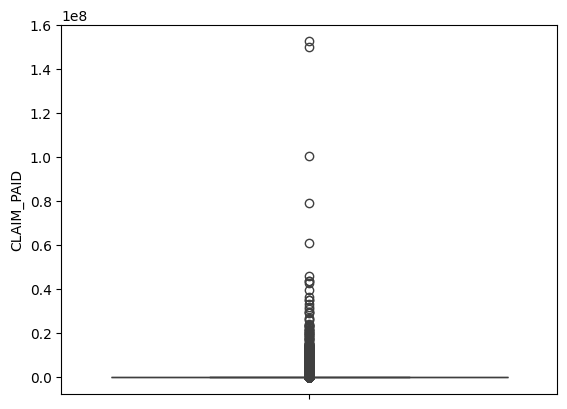

In [18]:
sns.boxplot(df['CLAIM_PAID'])

Numeric columns: ['SEX', 'INSR_TYPE', 'INSURED_VALUE', 'PREMIUM', 'OBJECT_ID', 'PROD_YEAR', 'SEATS_NUM', 'CARRYING_CAPACITY', 'CCM_TON', 'CLAIM_PAID', 'CLAIM_FLAG']
Categorical columns: ['EFFECTIVE_YR', 'TYPE_VEHICLE', 'MAKE', 'USAGE']


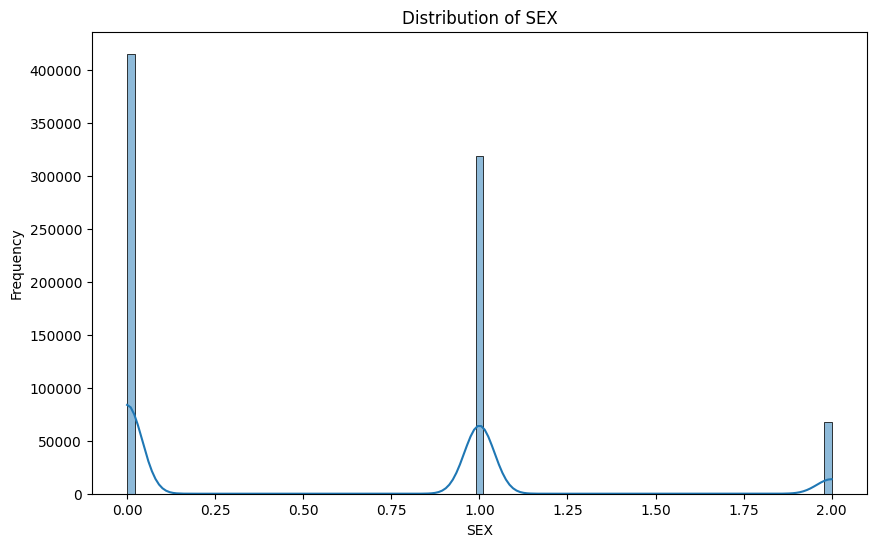

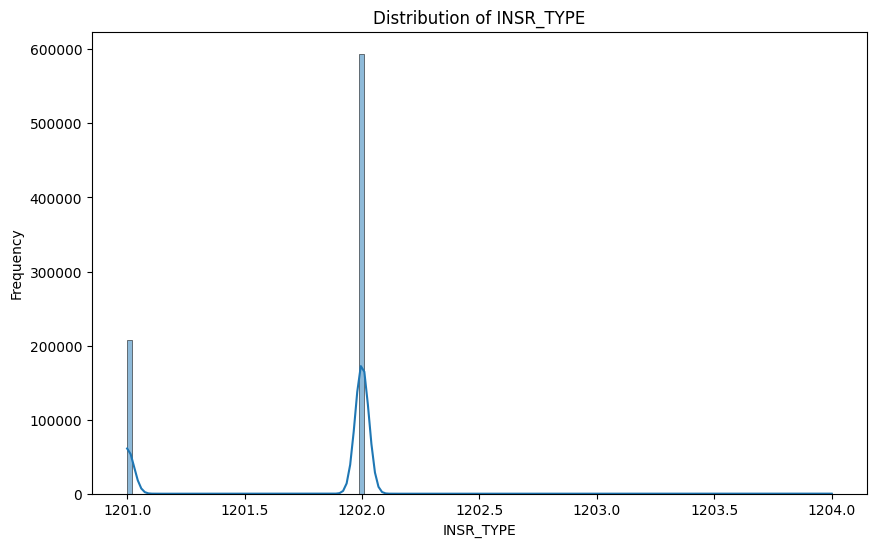

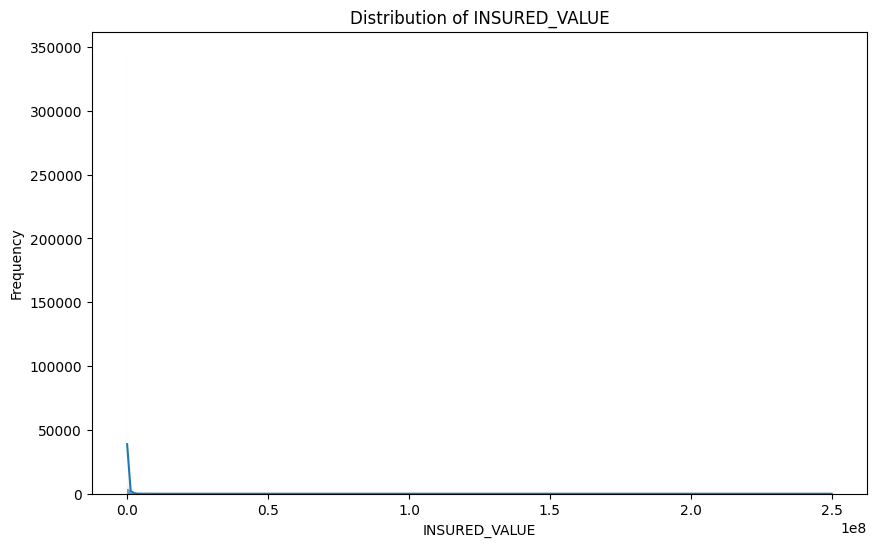

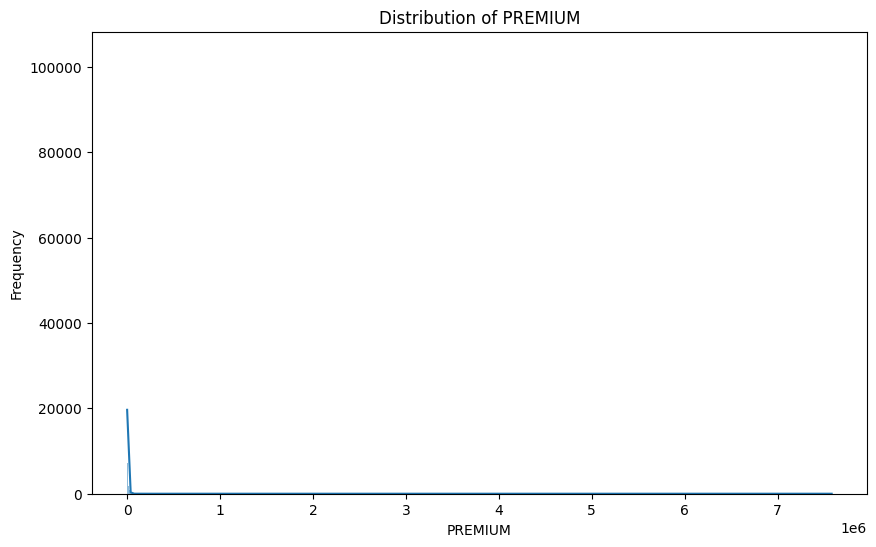

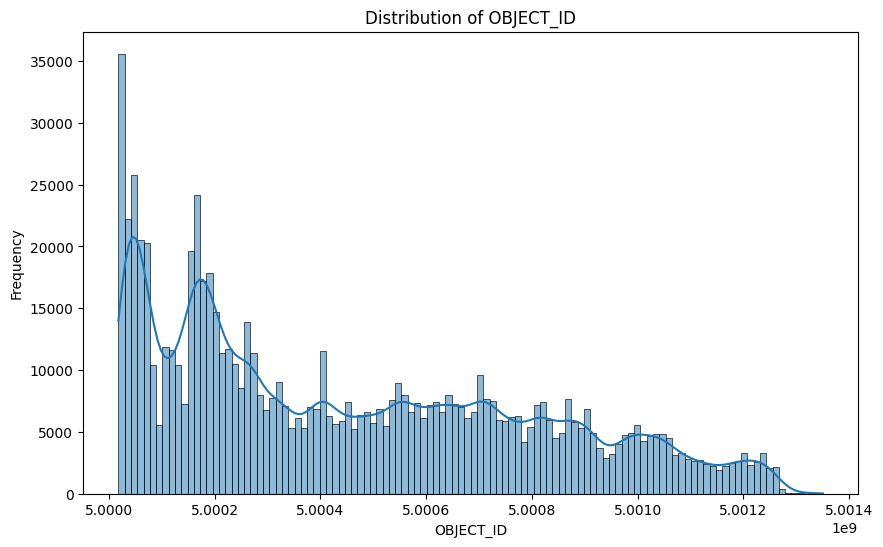

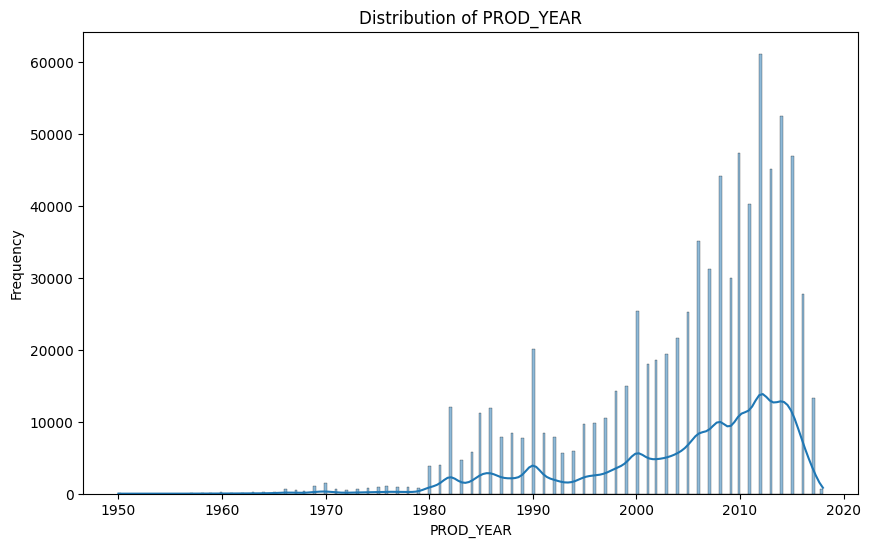

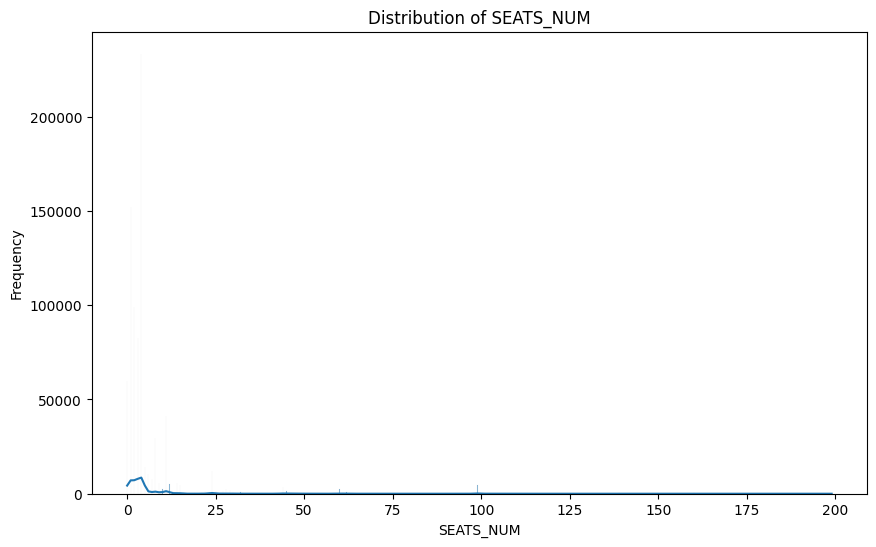

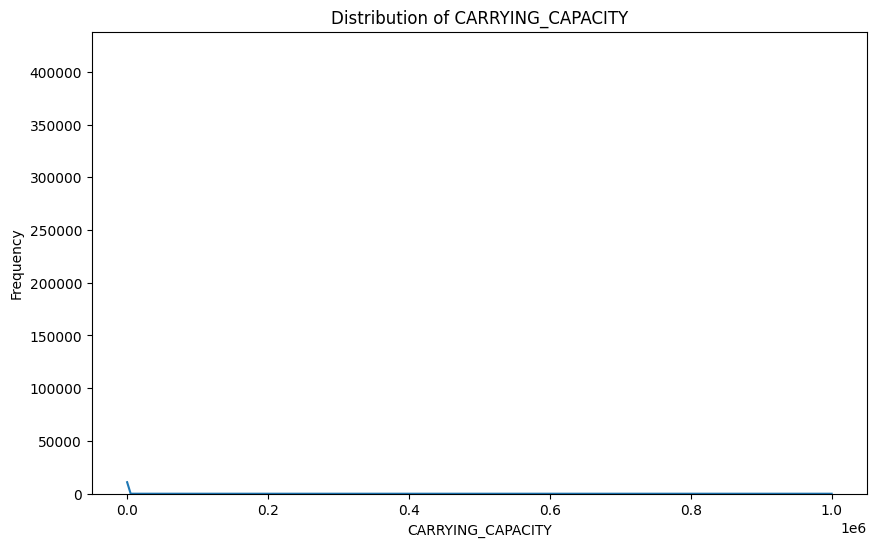

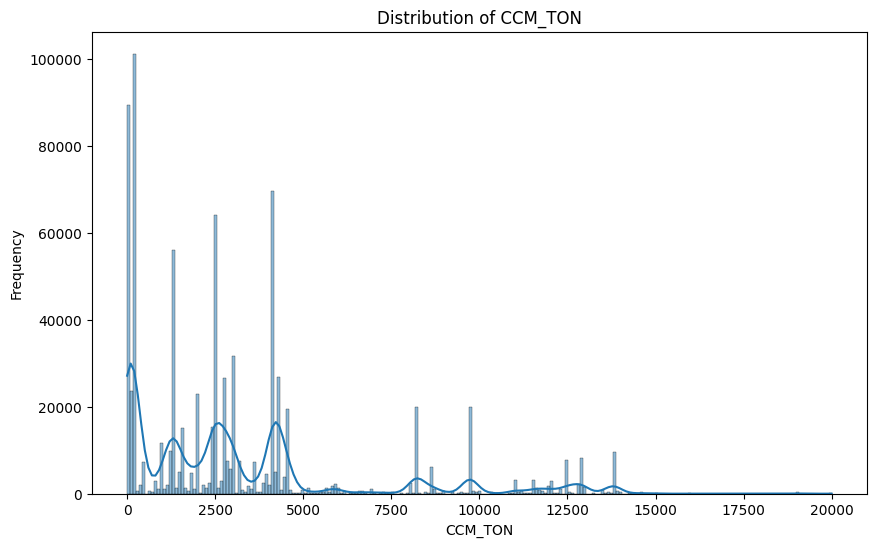

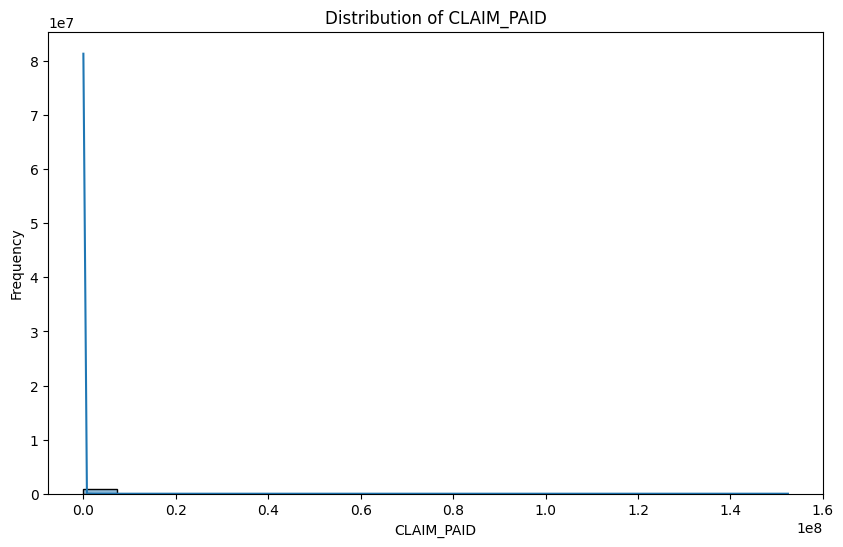

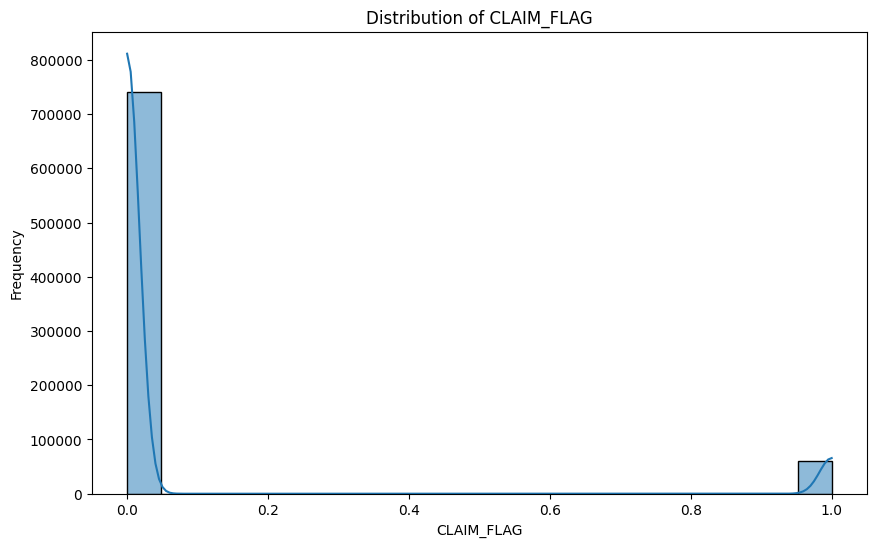

In [19]:
def numeric_columns(df):
    """
    Return a list of numeric columns in the DataFrame.
    """
    return [col for col in df.columns if df[col].dtype in [np.int64, np.float64]]

def categorical_columns(df):
    """
    Return a list of categorical columns in the DataFrame.
    """
    return [col for col in df.columns if df[col].dtype == 'object']

numeric_cols = numeric_columns(df)
print("Numeric columns:", numeric_cols)
categorical_cols = categorical_columns(df)
print("Categorical columns:", categorical_cols)

def plot_numeric_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()
# Example usage of the plot_numeric_distribution function
if numeric_cols:
    for col in numeric_cols:

        plot_numeric_distribution(df, col)

In [20]:
# Check the unique values in column SEX
unique_values = df['SEX'].nunique()
print("Unique values in 'SEX':", unique_values)

# Count the occurrences of each unique value in the 'SEX' column
value_counts = df['SEX'].value_counts()
print("Value counts in 'SEX':\n", value_counts)

Unique values in 'SEX': 3
Value counts in 'SEX':
 SEX
0    415230
1    318522
2     68061
Name: count, dtype: int64


In [21]:
# Count records by SEX
print("Counts by SEX:\n", df["SEX"].value_counts(), "\n")

# Compare average premium & claims
sex_summary = df.groupby("SEX").agg({
    "PREMIUM": "mean",
    "INSURED_VALUE": "mean",
    "CLAIM_PAID": "mean",
    "CLAIM_FLAG": "mean"
}).rename(columns={"CLAIM_FLAG": "Claim_Rate"})

print("Summary by SEX:\n", sex_summary, "\n")

# Check usage distribution for SEX=2
usage_dist = df[df["SEX"]==2]["USAGE"].value_counts(normalize=True) * 100
print("Usage distribution for SEX=2:\n", usage_dist, "\n")

# Check top vehicle makes for SEX=2
make_dist = df[df["SEX"]==2]["MAKE"].value_counts().head(10)
print("Top 10 makes for SEX=2:\n", make_dist)


Counts by SEX:
 SEX
0    415230
1    318522
2     68061
Name: count, dtype: int64 

Summary by SEX:
          PREMIUM  INSURED_VALUE    CLAIM_PAID  Claim_Rate
SEX                                                      
0    8174.597631  705476.044389  14783.075231    0.091754
1    6722.092592  305633.814797  25166.990447    0.056071
2    5940.107961  264338.271273  18680.061504    0.060901 

Usage distribution for SEX=2:
 USAGE
Private                   33.790276
Fare Paying Passengers    23.608234
General Cartage           20.656470
Taxi                      12.969248
Own Goods                  4.786882
Others                     1.842465
Own service                1.022612
Car Hires                  0.556853
Learnes                    0.367318
Agricultural Any Farm      0.167497
Special Construction       0.163089
Agricultural Own Farm      0.061709
Ambulance                  0.007346
Name: proportion, dtype: float64 

Top 10 makes for SEX=2:
 MAKE
TOYOTA       27532
ISUZU         8819

In [22]:
# ŸÖ€åÿßŸÜ⁄Ø€åŸÜ ÿ™ÿπÿØÿßÿØ ÿµŸÜÿØŸÑ€å ÿ®ÿ±ÿß€å Ÿáÿ± ⁄Øÿ±ŸàŸá
print("Average SEATS_NUM by SEX:")
print(df.groupby("SEX")["SEATS_NUM"].mean())

print("\nUsage distribution by SEX:")
# ÿ™Ÿàÿ≤€åÿπ ÿßÿ≥ÿ™ŸÅÿßÿØŸá (USAGE) ÿ®ÿ±ÿß€å Ÿáÿ± SEX
for sex in df["SEX"].unique():
    usage_dist = df[df["SEX"] == sex]["USAGE"].value_counts(normalize=True) * 100
    print(f"\nSEX={sex}")
    print(usage_dist.head(10))  # ŸÅŸÇÿ∑ 10 ŸÖŸàÿ±ÿØ ÿßŸàŸÑ ÿ®ÿ±ÿß€å ÿÆŸÑÿßÿµŸá ÿ®ŸàÿØŸÜ


Average SEATS_NUM by SEX:
SEX
0    7.091811
1    5.043430
2    5.352341
Name: SEATS_NUM, dtype: float64

Usage distribution by SEX:

SEX=0
USAGE
Own Goods                 47.627821
Private                   27.950774
Own service               10.245888
General Cartage            6.400790
Fare Paying Passengers     2.477904
Agricultural Own Farm      1.792982
Special Construction       1.490740
Ambulance                  0.740313
Agricultural Any Farm      0.567878
Others                     0.243720
Name: proportion, dtype: float64

SEX=1
USAGE
Fare Paying Passengers    28.829406
General Cartage           26.633011
Private                   20.719448
Taxi                      11.823673
Own Goods                  5.811530
Own service                2.280847
Others                     2.100954
Learnes                    0.529006
Car Hires                  0.519273
Agricultural Any Farm      0.408135
Name: proportion, dtype: float64

SEX=2
USAGE
Private                   33.790276
Fare Pa

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### üë• ÿ™ÿ≠ŸÑ€åŸÑ ŸÖÿ™ÿ∫€åÿ± ÿ¨ŸÜÿ≥€åÿ™ (SEX)

- ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿ±ÿß€å **ŸÖÿ±ÿØÿßŸÜ (SEX=0)** ÿ®Ÿá‚Äåÿ∑Ÿàÿ± ŸÖÿπŸÜÿßÿØÿßÿ±€å ÿ®ÿßŸÑÿßÿ™ÿ± ÿßÿ≤ **ÿ≤ŸÜÿßŸÜ (SEX=1)** ÿßÿ≥ÿ™.  
  ÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ ÿ®ÿß ŸàÿßŸÇÿπ€åÿ™‚ÄåŸáÿß€å ÿ®€åŸÖŸá‚Äåÿß€å ŸáŸÖÿÆŸàÿßŸÜ€å ÿØÿßÿ±ÿØÿõ ÿ≤€åÿ±ÿß ŸÖÿ±ÿØÿßŸÜ ŸÖÿπŸÖŸàŸÑÿßŸã ÿ®€åÿ¥ÿ™ÿ± ÿ±ÿßŸÜŸÜÿØ⁄Ø€å ŸÖ€å‚Äå⁄©ŸÜŸÜÿØÿå ÿØÿ± ŸÖÿ¥ÿßÿ∫ŸÑ ŸÖÿ±ÿ™ÿ®ÿ∑ ÿ®ÿß ÿ±ÿßŸÜŸÜÿØ⁄Ø€å ÿ≠ÿ∂Ÿàÿ± ÿ®€åÿ¥ÿ™ÿ±€å ÿØÿßÿ±ŸÜÿØ Ÿà ÿ±ŸÅÿ™ÿßÿ± ÿ±ÿßŸÜŸÜÿØ⁄Ø€å Ÿæÿ±ÿ±€åÿ≥⁄©‚Äåÿ™ÿ±€å ŸÜÿ¥ÿßŸÜ ŸÖ€å‚ÄåÿØŸáŸÜÿØ.  

- ÿØÿ± ŸÜ⁄ØÿßŸá ÿßŸàŸÑ ŸáŸÜ⁄ØÿßŸÖ ÿ®ÿ±ÿ±ÿ≥€å ÿ≥ÿ™ŸàŸÜ **SEX** ŸÖÿ™Ÿàÿ¨Ÿá ÿ≠ÿ∂Ÿàÿ± ŸÖŸÇÿØÿßÿ± **€≤** ÿ¥ÿØŸÖ ⁄©Ÿá ŸÖÿ¥⁄©Ÿà⁄© ÿ®Ÿá ŸÜÿ∏ÿ± ŸÖ€å‚Äåÿ±ÿ≥€åÿØÿå ⁄Üÿ±ÿß⁄©Ÿá ÿßŸÜÿ™ÿ∏ÿßÿ± ŸÖ€å‚Äåÿ±ŸÅÿ™ ÿß€åŸÜ ŸÖÿ™ÿ∫€åÿ± ŸÅŸÇÿ∑ ÿ¥ÿßŸÖŸÑ ŸÖŸÇÿßÿØ€åÿ± **€∞=ŸÖÿ±ÿØ** Ÿà **€±=ÿ≤ŸÜ** ÿ®ÿßÿ¥ÿØ.  
  ŸÅÿ±ÿ∂ ÿßŸàŸÑ€åŸá ÿß€åŸÜ ÿ®ŸàÿØ ⁄©Ÿá ÿß€åŸÜ ÿØÿßÿØŸá‚ÄåŸáÿß ŸÖŸÅŸÇŸàÿØ €åÿß ÿÆÿ±ÿßÿ® ÿ¥ÿØŸá‚ÄåÿßŸÜÿØ. ÿßŸÖÿß Ÿæÿ≥ ÿßÿ≤ ÿ™ÿ≠ŸÑ€åŸÑ ÿØŸÇ€åŸÇ‚Äåÿ™ÿ± (ÿ®ÿ±ÿ±ÿ≥€å ÿ™Ÿàÿ≤€åÿπ **USAGE** Ÿà ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™)ÿå ŸÖÿ¥ÿÆÿµ ÿ¥ÿØ ⁄©Ÿá ŸÖŸÇÿØÿßÿ± **€≤ ÿØÿ± ŸàÿßŸÇÿπ ŸÜŸÖÿß€åÿßŸÜ⁄Øÿ± ÿ≥ÿßÿ≤ŸÖÿßŸÜ‚ÄåŸáÿß/ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß** ÿßÿ≥ÿ™ Ÿà ŸÜŸá ÿØÿßÿØŸá‚Äå€å ÿßÿ¥ÿ™ÿ®ÿßŸá. ÿ®ŸÜÿßÿ®ÿ±ÿß€åŸÜ ÿß€åŸÜ ÿØÿ≥ÿ™Ÿá‚Äåÿ®ŸÜÿØ€å **ŸÖÿπŸÜÿßÿØÿßÿ± Ÿà ŸÖÿπÿ™ÿ®ÿ±** ÿ®ŸàÿØŸá Ÿà ÿ®ÿß€åÿØ ÿØÿ± ÿ™ÿ≠ŸÑ€åŸÑ‚ÄåŸáÿß ŸÑÿ≠ÿßÿ∏ ÿ¥ŸàÿØ.  

---

### üë• Gender Variable Analysis (SEX)

- The claim rate for **males (SEX=0)** is significantly higher than for **females (SEX=1)**.  
  This aligns with insurance industry observations, as men tend to drive more frequently, are more represented in driving-related occupations, and often exhibit riskier driving behavior compared to women.  

- At first glance, while exploring the **SEX** column, the presence of the value **2** seemed suspicious, since this variable is typically expected to contain only **0=Male** and **1=Female**.  
  My initial assumption was that it could represent missing or corrupted data. However, after deeper analysis (examining **USAGE distribution** and **CLAIM_RATE**), it became clear that **value 2 actually represents organizations/companies** rather than erroneous records. Hence, this category is **meaningful and valid** for further analysis.  

</div>


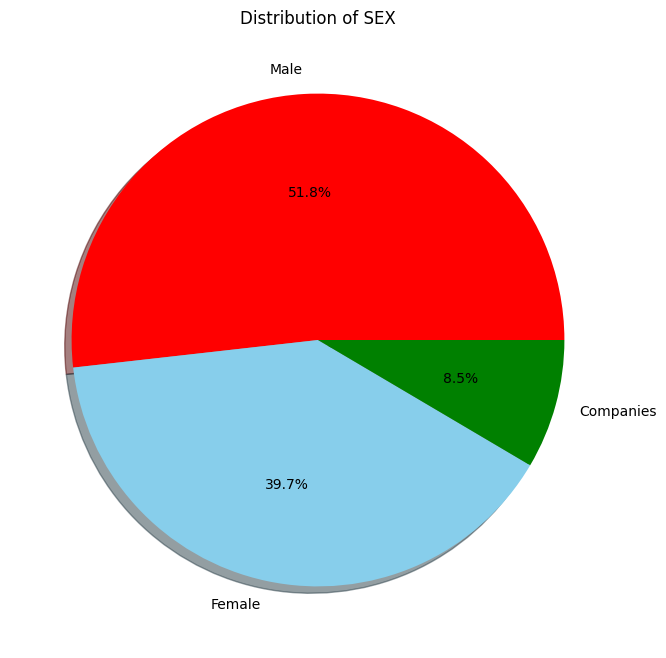

In [23]:
df['SEX'] = df['SEX'].map({0:'Male' , 1:'Female' , 2: 'Companies'})

sex_m = df[df['SEX'] == 'Male']['SEX'].count()
sex_f = df[df['SEX'] == 'Female']['SEX'].count()
sex_c = df[df['SEX'] == 'Companies']['SEX'].count()
plt.figure(figsize=(8, 8))
plt.pie(x=[sex_m, sex_f, sex_c], labels=['Male', 'Female', 'Companies'],colors= ['red' , 'skyblue','green'],radius=1, shadow=True, autopct="%1.1f%%")
plt.title("Distribution of SEX")
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">


üë® **ŸÖÿ±ÿØŸáÿß (Male):** ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ÿ≥ŸáŸÖ ÿ±Ÿà ÿØÿßÿ±ŸÜ ÿ®ÿß ÿ≠ÿØŸàÿØ **51.8%** ‚Üí €åÿπŸÜ€å ÿ®€åÿ¥ÿ™ÿ± ÿßÿ≤ ŸÜ€åŸÖ€å ÿßÿ≤ ÿ®€åŸÖŸá‚Äå⁄Øÿ∞ÿßÿ±ÿßŸÜ ŸÖÿ±ÿØ Ÿáÿ≥ÿ™ŸÜ.  
üë© **ÿ≤ŸÜ‚ÄåŸáÿß (Female):** ÿ≠ÿØŸàÿØ **39.7%** ‚Üí ÿ≥ŸáŸÖ ÿ®ÿ≤ÿ±⁄Ø€å ÿØÿßÿ±ŸÜ ŸàŸÑ€å ⁄©ŸÖÿ™ÿ± ÿßÿ≤ ŸÖÿ±ÿØŸáÿß.  
üè¢ **ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß (Companies):** ŸÅŸÇÿ∑ **8.5%** ‚Üí ŸÜÿ¥ŸàŸÜ ŸÖ€åÿØŸá ÿ≥ŸáŸÖ ÿ≥ÿßÿ≤ŸÖÿßŸÜ€å/ÿ¥ÿ±⁄©ÿ™€å ÿÆ€åŸÑ€å ⁄©ŸÖÿ™ÿ± ÿßÿ≤ ÿßŸÅÿ±ÿßÿØ ÿ≠ŸÇ€åŸÇ€åŸá.  

### üìå ŸÜ⁄©ÿßÿ™ ⁄©ŸÑ€åÿØ€å (Insights):  
- ÿ®ÿßÿ≤ÿßÿ± ÿßÿµŸÑ€å ÿ®€åŸÖŸá Ÿàÿ≥ÿß€åŸÑ ŸÜŸÇŸÑ€åŸá ÿØÿ± ÿØÿ≥ÿ™ **ÿßŸÅÿ±ÿßÿØ ÿ≠ŸÇ€åŸÇ€å (ÿ≤ŸÜ Ÿà ŸÖÿ±ÿØ)** ÿßÿ≥ÿ™ÿå ŸÜŸá ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß.  
- üë® ŸÖÿ±ÿØÿßŸÜ ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ÿ≥ŸáŸÖ ÿ±Ÿà ÿØÿßÿ±ŸÜ ‚Üí ÿßÿ≠ÿ™ŸÖÿßŸÑÿßŸã ÿ®Ÿá ÿØŸÑ€åŸÑ ŸÖÿßŸÑ⁄©€åÿ™ ÿ®€åÿ¥ÿ™ÿ± ÿÆŸàÿØÿ±Ÿà €åÿß ÿßŸÑ⁄ØŸàŸáÿß€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá.  
- üë© ÿ≤ŸÜÿßŸÜ ÿ≥ŸáŸÖ ŸÇÿßÿ®ŸÑ ÿ™Ÿàÿ¨Ÿá€å ÿØÿßÿ±ŸÜ (~40%) ‚Üí €å⁄© ÿ®ÿßÿ≤ÿßÿ± ŸÖŸáŸÖ Ÿà ÿ±Ÿà ÿ®Ÿá ÿ±ÿ¥ÿØ ÿ®ÿ±ÿß€å ŸáÿØŸÅ‚Äå⁄Øÿ∞ÿßÿ±€å ÿ®€åŸÖŸá.  
- üè¢ ÿ®ÿÆÿ¥ ÿ¥ÿ±⁄©ÿ™€å ⁄©Ÿà⁄Ü⁄© ŸàŸÑ€å ÿ®ÿß **Ÿæÿ™ÿßŸÜÿ≥€åŸÑ ÿ±ÿ¥ÿØ** (ŸÖÿ´ŸÑ ÿ®€åŸÖŸá‚ÄåŸáÿß€å ŸÜÿßŸà⁄ØÿßŸÜ ÿ≠ŸÖŸÑ‚ÄåŸàŸÜŸÇŸÑ).  

</div>

---

üë® **Males:** Largest group with about **51.8%** ‚Üí More than half of the insured clients are men.  
üë© **Females:** Around **39.7%** ‚Üí A significant share but smaller than males.  
üè¢ **Companies:** Only **8.5%** ‚Üí Organizational customers represent a much smaller portion of the market.  

### üìå Key Insights:  
- The insurance market is dominated by **individual customers (male & female)**, not companies.  
- üë® Males form the majority ‚Üí likely due to higher vehicle ownership or usage patterns.  
- üë© Females are a strong segment (~40%) ‚Üí showing **considerable market potential**.  
- üè¢ Corporate clients are underrepresented but could be a **growth opportunity**, especially for fleet/business insurance packages.  


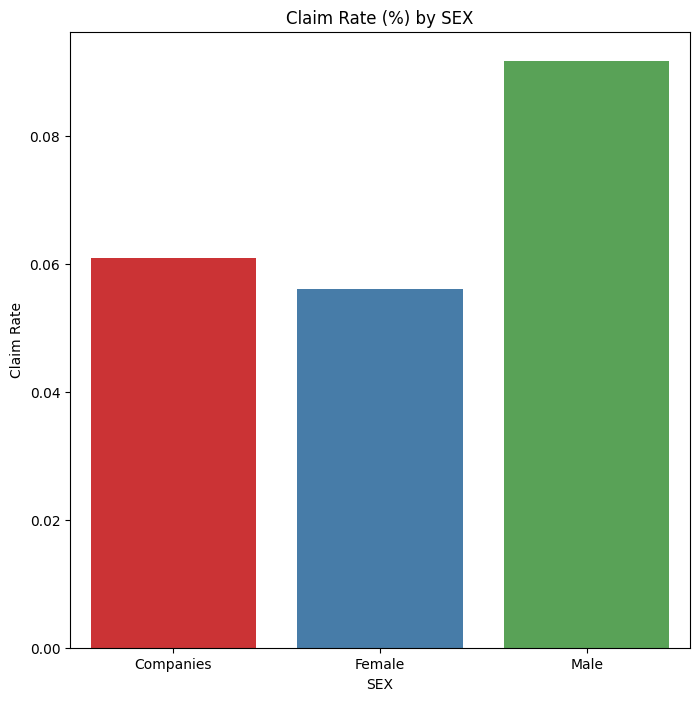

In [24]:
claim_rate = df.groupby('SEX')['CLAIM_FLAG'].mean().reset_index()

plt.figure(figsize=(8,8))
sns.barplot(x='SEX', y='CLAIM_FLAG', data=claim_rate, palette='Set1')
plt.title("Claim Rate (%) by SEX")
plt.ylabel("Claim Rate")
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">


üë® **ŸÖÿ±ÿØÿßŸÜ (Male):** ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿß ÿ≠ÿØŸàÿØ %9+ ‚Üí ŸÜÿ¥ÿßŸÜ‚ÄåÿØŸáŸÜÿØŸá **ÿ±€åÿ≥⁄© ÿ®ÿßŸÑÿßÿ™ÿ±** ÿ®ÿ±ÿß€å ÿ¥ÿ±⁄©ÿ™ ÿ®€åŸÖŸá.  

üë© **ÿ≤ŸÜÿßŸÜ (Female):** ⁄©ŸÖÿ™ÿ±€åŸÜ ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿß ÿ≠ÿØŸàÿØ %5.5 ‚Üí ŸÖÿ¥ÿ™ÿ±€åÿßŸÜ€å ÿ®ÿß **ÿ≥ŸàÿØÿ¢Ÿàÿ±€å ÿ®€åÿ¥ÿ™ÿ±** ÿ®ÿ±ÿß€å ÿ®€åŸÖŸá‚Äå⁄Øÿ±.  

üè¢ **ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß (Companies):** ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ŸÖÿ™Ÿàÿ≥ÿ∑ ÿ≠ÿØŸàÿØ %6 ‚Üí ÿ®ÿß Ÿàÿ¨ŸàÿØ ÿ≥ŸáŸÖ ÿ®ÿßÿ≤ÿßÿ± ⁄©Ÿà⁄Ü⁄©ÿå ŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÜÿØ ÿ®ÿßÿ≤ÿßÿ± **Ÿæÿß€åÿØÿßÿ± Ÿà ŸÇÿßÿ®ŸÑ ÿ™Ÿàÿ≥ÿπŸá** ÿ®ÿßÿ¥ŸÜÿØ.  

‚ú® **ÿß€åŸÜ €åÿπŸÜ€å:**  
- üë® ŸÖÿ±ÿØÿßŸÜ ‚Üí ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ÿ≥ŸáŸÖ + ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ÿÆÿ≥ÿßÿ±ÿ™ ‚Üí ŸÜ€åÿßÿ≤ ÿ®Ÿá **ŸÖÿØ€åÿ±€åÿ™ ÿ±€åÿ≥⁄©** Ÿà ÿ¥ÿß€åÿØ **ÿ™ÿπÿ±ŸÅŸá‚ÄåŸáÿß€å ÿ®ÿßŸÑÿßÿ™ÿ±**.  
- üë© ÿ≤ŸÜÿßŸÜ ‚Üí ÿ≥ŸáŸÖ ŸÇÿßÿ®ŸÑ ÿ™Ÿàÿ¨Ÿá + ÿÆÿ≥ÿßÿ±ÿ™ ⁄©ŸÖÿ™ÿ± ‚Üí ŸÅÿ±ÿµÿ™ ÿπÿßŸÑ€å ÿ®ÿ±ÿß€å ÿ∑ÿ±ÿßÿ≠€å **ÿ∑ÿ±ÿ≠‚ÄåŸáÿß€å ÿ™ÿ¥Ÿà€åŸÇ€å Ÿà ÿ™ÿÆŸÅ€åŸÅ€å**.  
- üè¢ ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß ‚Üí ÿ≥ŸáŸÖ ⁄©Ÿà⁄Ü⁄© + ÿ±€åÿ≥⁄© ŸÖÿ™Ÿàÿ≥ÿ∑ ‚Üí Ÿæÿ™ÿßŸÜÿ≥€åŸÑ ÿ±ÿ¥ÿØ ÿØÿ± **ÿ®€åŸÖŸá‚ÄåŸáÿß€å ÿ≥ÿßÿ≤ŸÖÿßŸÜ€å Ÿà ŸÜÿßŸà⁄ØÿßŸÜ**.  

</div>

---


üë® **Males:** Highest claim rate (9%+) ‚Üí Represent the **riskiest group** for insurers.  

üë© **Females:** Lowest claim rate (~5.5%) ‚Üí A **profitable and attractive** customer segment.  

üè¢ **Companies:** Moderate claim rate (~6%) ‚Üí Though small in share, they offer **stable future potential**, especially in fleet insurance.  

‚ú® **This means:**  
- üë® Males ‚Üí High share + High claims ‚Üí Require **risk-based pricing** or stricter underwriting.  
- üë© Females ‚Üí Significant share + Low claims ‚Üí Great opportunity for **discounts & loyalty programs**.  
- üè¢ Companies ‚Üí Small share + Medium risk ‚Üí Potential growth in **corporate packages**.  


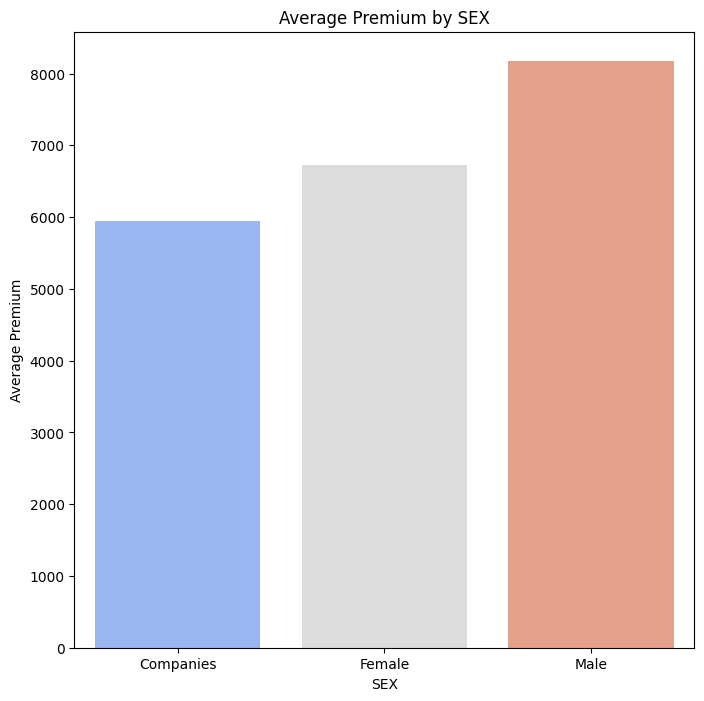

In [25]:
premium_by_sex = df.groupby('SEX')['PREMIUM'].mean().reset_index()

plt.figure(figsize=(8,8))
sns.barplot(x='SEX', y='PREMIUM', data=premium_by_sex, palette='coolwarm')
plt.title("Average Premium by SEX")
plt.ylabel("Average Premium")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">
 

üë® **ŸÖÿ±ÿØÿßŸÜ (Male):** ÿ®ÿßŸÑÿßÿ™ÿ±€åŸÜ ŸÖ€åÿßŸÜ⁄Ø€åŸÜ ÿ≠ŸÇ‚Äåÿ®€åŸÖŸáÿå ÿ≠ÿØŸàÿØ **8200** ‚Üí ŸÜÿ¥ÿßŸÜ‚ÄåÿØŸáŸÜÿØŸá ÿ±€åÿ≥⁄© ÿ®ÿßŸÑÿßÿ™ÿ± €åÿß ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿ®€åÿ¥ÿ™ÿ± ÿßÿ≤ ÿÆÿØŸÖÿßÿ™ ÿ®€åŸÖŸá‚Äåÿß€å.  

üë© **ÿ≤ŸÜÿßŸÜ (Female):** ŸÖ€åÿßŸÜ⁄Ø€åŸÜ ÿ≠ŸÇ‚Äåÿ®€åŸÖŸá ÿ≠ÿØŸàÿØ **6700** ‚Üí ⁄©ŸÖÿ™ÿ± ÿßÿ≤ ŸÖÿ±ÿØÿßŸÜ ŸàŸÑ€å ÿ®€åÿ¥ÿ™ÿ± ÿßÿ≤ ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß.  

üè¢ **ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß (Companies):** Ÿæÿß€å€åŸÜ‚Äåÿ™ÿ±€åŸÜ ŸÖ€åÿßŸÜ⁄Ø€åŸÜ ÿ≠ŸÇ‚Äåÿ®€åŸÖŸáÿå ÿ≠ÿØŸàÿØ **6000** ‚Üí ÿ≥ŸáŸÖ ⁄©Ÿà⁄Ü⁄© Ÿà ÿ±€åÿ≥⁄© ŸÖÿ™Ÿàÿ≥ÿ∑.  

### üìå ŸÜ⁄©ÿßÿ™ ⁄©ŸÑ€åÿØ€å (Insights):  
- üë® ŸÖÿ±ÿØÿßŸÜ ÿ®ÿß Ÿàÿ¨ŸàÿØ ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ÿÆÿ≥ÿßÿ±ÿ™ (ŸÜŸÖŸàÿØÿßÿ± ŸÇÿ®ŸÑ€å)ÿå ÿ®ÿßŸÑÿßÿ™ÿ±€åŸÜ ÿ≠ŸÇ‚Äåÿ®€åŸÖŸá ÿ±Ÿà ŸáŸÖ Ÿæÿ±ÿØÿßÿÆÿ™ ŸÖ€å‚Äå⁄©ŸÜŸÜ ‚Üí ÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ ÿ®ÿß **ŸÖÿØŸÑ ŸÇ€åŸÖÿ™‚Äå⁄Øÿ∞ÿßÿ±€å ÿ±€åÿ≥⁄©‚ÄåŸÖÿ≠Ÿàÿ±** ÿ≥ÿßÿ≤⁄Øÿßÿ±Ÿá.  
- üë© ÿ≤ŸÜÿßŸÜ ÿ®ÿß ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ⁄©ŸÖÿ™ÿ± Ÿà ÿ≠ŸÇ‚Äåÿ®€åŸÖŸá ŸÖÿ™Ÿàÿ≥ÿ∑ ‚Üí **ÿ≥ŸàÿØÿ¢Ÿàÿ±ÿ™ÿ±€åŸÜ ⁄Øÿ±ŸàŸá** ÿ®ÿ±ÿß€å ÿ¥ÿ±⁄©ÿ™ ÿ®€åŸÖŸá.  
- üè¢ ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß ÿ≠ŸÇ‚Äåÿ®€åŸÖŸá Ÿæÿß€å€åŸÜ‚Äåÿ™ÿ±€å Ÿæÿ±ÿØÿßÿÆÿ™ ŸÖ€å‚Äå⁄©ŸÜŸÜ ‚Üí ÿßÿ≠ÿ™ŸÖÿßŸÑÿßŸã ÿ®Ÿá ÿÆÿßÿ∑ÿ± ŸÇÿ±ÿßÿ±ÿØÿßÿØŸáÿß€å ⁄Øÿ±ŸàŸá€å €åÿß ÿ™ÿÆŸÅ€åŸÅ‚ÄåŸáÿß€å ÿ≥ÿßÿ≤ŸÖÿßŸÜ€å.  

</div>

---



üë® **Males:** Highest average premium (~8200) ‚Üí Indicates higher risk or higher insurance usage.  

üë© **Females:** Medium premium (~6700) ‚Üí Lower than males but higher than companies.  

üè¢ **Companies:** Lowest average premium (~6000) ‚Üí Possibly due to bulk contracts or organizational discounts.  

### üìå Key Insights:  
- üë® Males pay the highest premiums, aligned with their **higher claim rates** (previous chart).  
- üë© Females show **lower risk + medium premiums**, making them the **most profitable group**.  
- üè¢ Companies pay the least, likely benefiting from **corporate discounts or fleet packages**.  


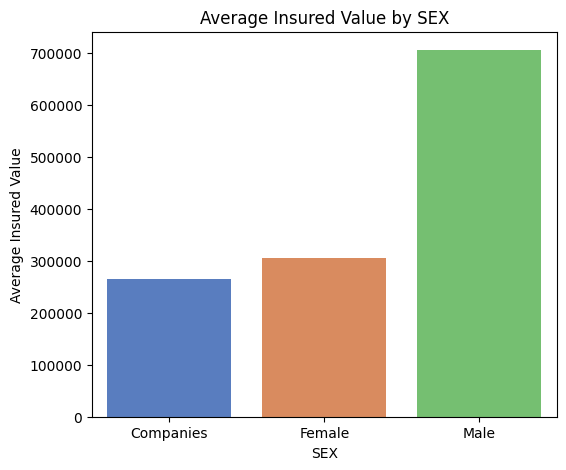

In [26]:
insured_value_by_sex = df.groupby('SEX')['INSURED_VALUE'].mean().reset_index()

plt.figure(figsize=(6,5))
sns.barplot(x='SEX', y='INSURED_VALUE', data=insured_value_by_sex, palette='muted')
plt.title("Average Insured Value by SEX")
plt.ylabel("Average Insured Value")
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">


üë® **ŸÖÿ±ÿØÿßŸÜ (Male):** ÿ®ÿßŸÑÿßÿ™ÿ±€åŸÜ ŸÖ€åÿßŸÜ⁄Ø€åŸÜ ÿßÿ±ÿ≤ÿ¥ ÿ®€åŸÖŸá‚Äåÿ¥ÿØŸá ÿ®ÿß ÿ≠ÿØŸàÿØ **700,000+** ‚Üí €åÿπŸÜ€å ÿÆŸàÿØÿ±ŸàŸáÿß €åÿß ÿØÿßÿ±ÿß€å€å‚ÄåŸáÿß€å ÿ™ÿ≠ÿ™ ŸæŸàÿ¥ÿ¥ ŸÖÿ±ÿØÿßŸÜ ŸÖÿπŸÖŸàŸÑÿßŸã **ÿßÿ±ÿ≤ÿ¥ŸÖŸÜÿØÿ™ÿ±** Ÿáÿ≥ÿ™ŸÜÿØ.  

üë© **ÿ≤ŸÜÿßŸÜ (Female):** ŸÖ€åÿßŸÜ⁄Ø€åŸÜ ÿßÿ±ÿ≤ÿ¥ ÿ®€åŸÖŸá‚Äåÿ¥ÿØŸá ÿ≠ÿØŸàÿØ **310,000** ‚Üí ⁄©ŸÖÿ™ÿ± ÿßÿ≤ ŸÖÿ±ÿØÿßŸÜ ÿßŸÖÿß ÿ®€åÿ¥ÿ™ÿ± ÿßÿ≤ ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß.  

üè¢ **ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß (Companies):** ⁄©ŸÖÿ™ÿ±€åŸÜ ŸÖ€åÿßŸÜ⁄Ø€åŸÜ ÿßÿ±ÿ≤ÿ¥ ÿ®€åŸÖŸá‚Äåÿ¥ÿØŸáÿå ÿ≠ÿØŸàÿØ **270,000** ‚Üí ŸÜÿ¥ÿßŸÜ‚ÄåÿØŸáŸÜÿØŸá ÿß€åŸÜ ⁄©Ÿá ÿßÿ∫ŸÑÿ® ÿØÿßÿ±ÿß€å€å‚ÄåŸáÿß€å ÿ®€åŸÖŸá‚Äåÿ¥ÿØŸá ÿ™Ÿàÿ≥ÿ∑ ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß **⁄©ŸÖ‚Äåÿßÿ±ÿ≤ÿ¥‚Äåÿ™ÿ± €åÿß ÿßŸÇÿ™ÿµÿßÿØ€å‚Äåÿ™ÿ±** Ÿáÿ≥ÿ™ŸÜÿØ.  

### üìå ŸÜ⁄©ÿßÿ™ ⁄©ŸÑ€åÿØ€å (Insights):  
- üë® ŸÖÿ±ÿØÿßŸÜ ÿπŸÑÿßŸàŸá ÿ®ÿ± ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ÿ≥ŸáŸÖ ÿ®ÿßÿ≤ÿßÿ±ÿå ÿÆŸàÿØÿ±ŸàŸáÿß€å€å ÿ®ÿß ÿßÿ±ÿ≤ÿ¥ ÿ®ÿßŸÑÿßÿ™ÿ± ÿØÿßÿ±ŸÜÿØ ‚Üí ÿ±€åÿ≥⁄© ÿ®€åŸÖŸá‚Äå⁄Øÿ± ÿØÿ± ÿß€åŸÜ ⁄Øÿ±ŸàŸá **ÿ≥ŸÜ⁄Ø€åŸÜ‚Äåÿ™ÿ±** ÿßÿ≥ÿ™.  
- üë© ÿ≤ŸÜÿßŸÜ ÿ®ÿß ÿßÿ±ÿ≤ÿ¥ ÿ®€åŸÖŸá‚Äåÿ¥ÿØŸá ŸÖÿ™Ÿàÿ≥ÿ∑ Ÿà ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ Ÿæÿß€å€åŸÜ (ŸÜŸÖŸàÿØÿßÿ± ŸÇÿ®ŸÑ) ‚Üí ⁄Øÿ±ŸàŸá€å **⁄©ŸÖ‚Äåÿ±€åÿ≥⁄© Ÿà ÿ≥ŸàÿØÿ¢Ÿàÿ±** ŸÖÿ≠ÿ≥Ÿàÿ® ŸÖ€å‚Äåÿ¥ŸàŸÜÿØ.  
- üè¢ ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß ÿ®ÿß Ÿæÿß€å€åŸÜ‚Äåÿ™ÿ±€åŸÜ ÿßÿ±ÿ≤ÿ¥ ÿ®€åŸÖŸá‚Äåÿ¥ÿØŸá ‚Üí ÿßÿ≠ÿ™ŸÖÿßŸÑÿßŸã ÿ®€åÿ¥ÿ™ÿ± ÿØÿ± ÿ®ÿÆÿ¥ ÿÆŸàÿØÿ±ŸàŸáÿß€å ÿÆÿØŸÖÿßÿ™€å €åÿß ÿßŸÇÿ™ÿµÿßÿØ€å ÿ≠ÿ∂Ÿàÿ± ÿØÿßÿ±ŸÜÿØ.  

</div>

---


üë® **Males:** Highest average insured value (~700,000+) ‚Üí Men typically insure **more valuable assets/vehicles**.  

üë© **Females:** Medium insured value (~310,000) ‚Üí Less than males but higher than companies.  

üè¢ **Companies:** Lowest insured value (~270,000) ‚Üí Suggests that corporate-insured vehicles are mostly **economical or utilitarian**.  

### üìå Key Insights:  
- üë® Males own higher-value vehicles ‚Üí leading to **greater risk exposure** for insurers.  
- üë© Females show **moderate insured values + low claim rates**, making them a **profitable and stable segment**.  
- üè¢ Companies insure lower-value vehicles ‚Üí likely focusing on **fleet or service cars**.  


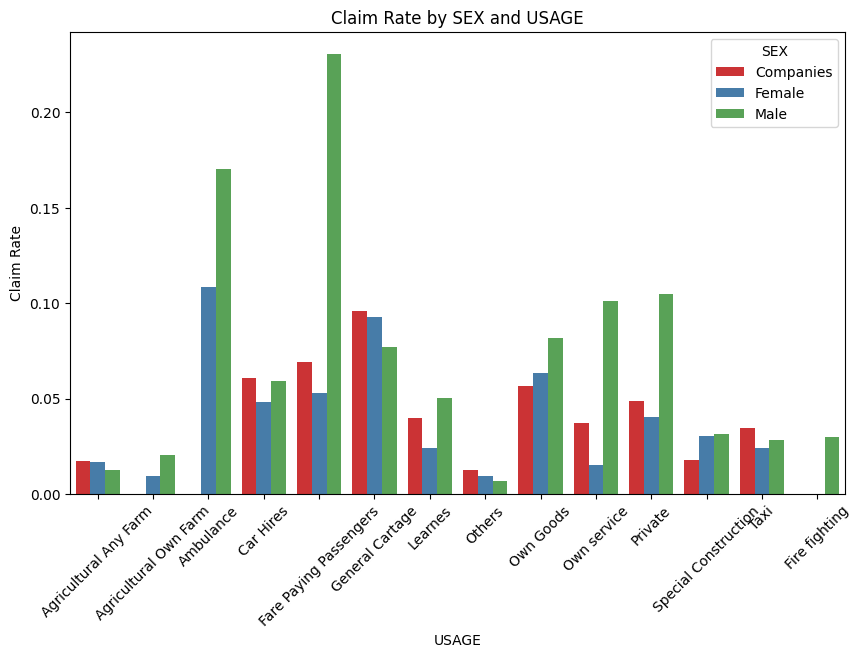

In [27]:
cross = df.groupby(['SEX','USAGE'])['CLAIM_FLAG'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='USAGE', y='CLAIM_FLAG', hue='SEX', data=cross, palette='Set1')
plt.title("Claim Rate by SEX and USAGE")
plt.xticks(rotation=45)
plt.ylabel("Claim Rate")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">


üìä ŸÖÿ¥ÿßŸáÿØŸá‚ÄåŸáÿß:  
- üë® **ŸÖÿ±ÿØÿßŸÜ (Male):** ÿØÿ± ÿß⁄©ÿ´ÿ± ⁄©ÿßÿ±ÿ®ÿ±€å‚ÄåŸáÿß ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿßŸÑÿßÿ™ÿ±€å ŸÜÿ≥ÿ®ÿ™ ÿ®Ÿá ÿ≤ŸÜÿßŸÜ Ÿà ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß ÿØÿßÿ±ŸÜÿØ. ÿ®Ÿá‚ÄåÿÆÿµŸàÿµ ÿØÿ±:  
  - üöï **Fare Paying Passengers (ŸÖÿ≥ÿßŸÅÿ±ÿ®ÿ±Ÿáÿß):** ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ (ÿ®€åÿ¥ ÿßÿ≤ 20%).  
  - üöö **Agricultural Own Farm** Ÿà **Own Goods** ‚Üí ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ⁄Üÿ¥ŸÖ⁄Ø€åÿ± ÿ®ÿßŸÑÿßÿ™ÿ±.  
- üë© **ÿ≤ŸÜÿßŸÜ (Female):** ÿØÿ± ÿ®€åÿ¥ÿ™ÿ± ÿØÿ≥ÿ™Ÿá‚ÄåŸáÿß ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ Ÿæÿß€å€åŸÜ‚Äåÿ™ÿ± ÿßÿ≤ ŸÖÿ±ÿØÿßŸÜ ÿØÿßÿ±ŸÜÿØÿå ÿßŸÖÿß ÿØÿ± ÿ®ÿ±ÿÆ€å ŸÖÿ´ŸÑ **Ambulance** ŸÜÿ≤ÿØ€å⁄© ÿ®Ÿá ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß Ÿáÿ≥ÿ™ŸÜÿØ.  
- üè¢ **ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß (Companies):** ŸÖÿπŸÖŸàŸÑÿßŸã ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ÿ¥ÿßŸÜ ÿ®€åŸÜ ŸÖÿ±ÿØÿßŸÜ Ÿà ÿ≤ŸÜÿßŸÜ ÿßÿ≥ÿ™ÿå ÿßŸÖÿß ÿØÿ± ÿ®ÿπÿ∂€å ⁄©ÿßÿ±ÿ®ÿ±€å‚ÄåŸáÿß ŸÖÿ´ŸÑ **Car Hires** €åÿß **General Cartage** ⁄©ŸÖ€å ÿ®ÿßŸÑÿßÿ™ÿ± ÿ∏ÿßŸáÿ± ŸÖ€å‚Äåÿ¥ŸàŸÜÿØ.  

‚ú® **ÿß€åŸÜ €åÿπŸÜ€å:**  
- üë® ŸÖÿ±ÿØÿßŸÜ ÿØÿ± ⁄©ÿßÿ±ÿ®ÿ±€å‚ÄåŸáÿß€å Ÿæÿ±ÿ±€åÿ≥⁄© (ŸÖÿ≥ÿßŸÅÿ±ÿ®ÿ±€åÿå ⁄©ÿ¥ÿßŸàÿ±ÿ≤€å ÿ¥ÿÆÿµ€åÿå ÿ≠ŸÖŸÑ ÿ®ÿßÿ± ÿ¥ÿÆÿµ€å) **ÿ±€åÿ≥⁄© ÿ®€åÿ¥ÿ™ÿ±€å** ÿ®ÿ±ÿß€å ÿ®€åŸÖŸá‚Äå⁄Øÿ± ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äå⁄©ŸÜŸÜÿØ.  
- üë© ÿ≤ŸÜÿßŸÜ ŸáŸÖ⁄ÜŸÜÿßŸÜ **ÿ±€åÿ≥⁄© ⁄©ŸÖÿ™ÿ±** ÿØÿßÿ±ŸÜÿØ Ÿà ÿ®ÿ±ÿß€å ÿ¥ÿ±⁄©ÿ™ ÿ®€åŸÖŸá ⁄Øÿ±ŸàŸá€å **ÿß€åŸÖŸÜ‚Äåÿ™ÿ± Ÿà ÿ≥ŸàÿØÿ¢Ÿàÿ±ÿ™ÿ±** Ÿáÿ≥ÿ™ŸÜÿØ.  
- üè¢ ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß ÿ®ÿß ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ŸÖÿ™Ÿàÿ≥ÿ∑ ŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÜÿØ ÿ®ÿßÿ≤ÿßÿ± **ÿ®ÿßÿ´ÿ®ÿßÿ™‚Äåÿ™ÿ±€å** ŸÜÿ≥ÿ®ÿ™ ÿ®Ÿá ÿßŸÅÿ±ÿßÿØ ÿ≠ŸÇ€åŸÇ€å Ÿæÿ±ÿ±€åÿ≥⁄© ÿ®ÿßÿ¥ŸÜÿØ.  

</div>

---



üìä Observations:  
- üë® **Males:** Generally higher claim rates across most usage categories. Especially in:  
  - üöï **Fare Paying Passengers:** Extremely high (~20%+).  
  - üöö **Agricultural Own Farm** and **Own Goods** ‚Üí noticeable higher risks.  
- üë© **Females:** Typically show **lower claim rates**, but in categories like **Ambulance** they are close to companies.  
- üè¢ **Companies:** Usually in the middle, but in some categories (e.g., **Car Hires**, **General Cartage**) they are relatively higher.  

‚ú® **This means:**  
- üë® Males dominate the **high-risk usages** (passenger transport, own farm/agriculture, own goods transport).  
- üë© Females remain **lower-risk**, offering a **safer portfolio** for insurers.  
- üè¢ Companies show **moderate risk**, making them a **stable and balanced segment** compared to individual high-risk drivers.  


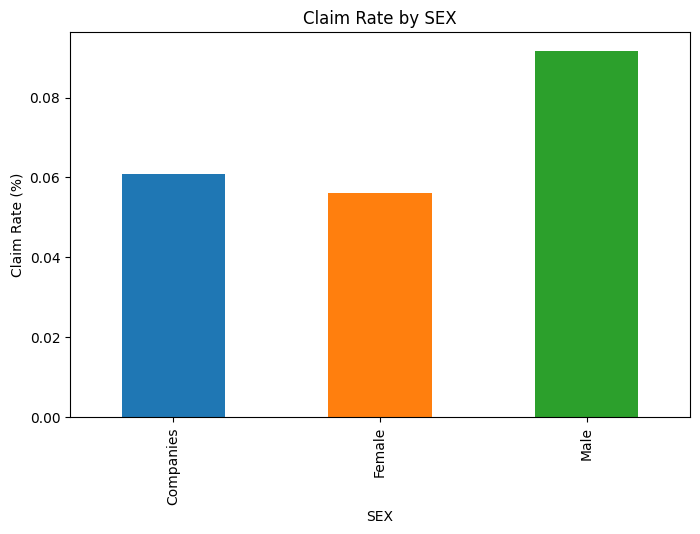

In [28]:
claim_rate = df.groupby('SEX')['CLAIM_FLAG'].mean()

claim_rate.plot(kind='bar', figsize=(8,5), color=['#1f77b4','#ff7f0e','#2ca02c'])
plt.title("Claim Rate by SEX")
plt.ylabel("Claim Rate (%)")
plt.xlabel("SEX")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

 

üë® **ŸÖÿ±ÿØÿßŸÜ (Male):** ÿ®ÿßŸÑÿßÿ™ÿ±€åŸÜ ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ÿå ÿ≠ÿØŸàÿØ **9%** ‚Üí ŸÜÿ¥ÿßŸÜ‚ÄåÿØŸáŸÜÿØŸá **ÿ±€åÿ≥⁄© ÿ®ÿßŸÑÿßÿ™ÿ±** Ÿà ŸÜ€åÿßÿ≤ŸÖŸÜÿØ ÿ™Ÿàÿ¨Ÿá Ÿà€å⁄òŸá ÿØÿ± ŸÇ€åŸÖÿ™‚Äå⁄Øÿ∞ÿßÿ±€å ÿ®€åŸÖŸá.  

üë© **ÿ≤ŸÜÿßŸÜ (Female):** ⁄©ŸÖÿ™ÿ±€åŸÜ ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ÿå ÿ≠ÿØŸàÿØ **5.5%** ‚Üí ŸÖÿ¥ÿ™ÿ±€åÿßŸÜ€å **ÿß€åŸÖŸÜ‚Äåÿ™ÿ± Ÿà ÿ≥ŸàÿØÿ¢Ÿàÿ±ÿ™ÿ±** ÿ®ÿ±ÿß€å ÿ¥ÿ±⁄©ÿ™ ÿ®€åŸÖŸá.  

üè¢ **ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß (Companies):** ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ŸÖÿ™Ÿàÿ≥ÿ∑ÿå ÿ≠ÿØŸàÿØ **6%** ‚Üí ⁄Øÿ±ŸàŸá€å ŸÖÿ™ÿπÿßÿØŸÑ ⁄©Ÿá ŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÜÿØ ÿ®ÿßÿ≤ÿßÿ± **Ÿæÿß€åÿØÿßÿ±** ÿß€åÿ¨ÿßÿØ ⁄©ŸÜŸÜÿØ.  

### üìå ŸÜ⁄©ÿßÿ™ ⁄©ŸÑ€åÿØ€å (Insights):  
- üë® ŸÖÿ±ÿØÿßŸÜ ‚Üí ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ÿÆÿ≥ÿßÿ±ÿ™ ‚Üí ŸÜ€åÿßÿ≤ ÿ®Ÿá **ŸÖÿØ€åÿ±€åÿ™ ÿ±€åÿ≥⁄© Ÿà ÿ™ÿπÿ±ŸÅŸá‚ÄåŸáÿß€å ŸÖÿ™ŸÜÿßÿ≥ÿ®**.  
- üë© ÿ≤ŸÜÿßŸÜ ‚Üí ÿ≥ŸáŸÖ ÿ®ÿ≤ÿ±⁄Ø + ÿÆÿ≥ÿßÿ±ÿ™ ⁄©ŸÖÿ™ÿ± ‚Üí ÿ®Ÿáÿ™ÿ±€åŸÜ ⁄Øÿ≤€åŸÜŸá ÿ®ÿ±ÿß€å **ÿ∑ÿ±ÿ≠‚ÄåŸáÿß€å ÿ™ÿ¥Ÿà€åŸÇ€å Ÿà ŸàŸÅÿßÿØÿßÿ±€å**.  
- üè¢ ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß ‚Üí ŸÜÿ±ÿÆ ŸÖÿ™Ÿàÿ≥ÿ∑ ‚Üí ŸÖŸÜÿßÿ≥ÿ® ÿ®ÿ±ÿß€å **ÿ®€åŸÖŸá‚ÄåŸáÿß€å ÿ≥ÿßÿ≤ŸÖÿßŸÜ€å Ÿà ŸÜÿßŸà⁄ØÿßŸÜ**.  

</div>

---



üë® **Males:** Highest claim rate (~9%) ‚Üí Represent the **riskiest group**, requiring stricter underwriting.  

üë© **Females:** Lowest claim rate (~5.5%) ‚Üí **Profitable and safer** customers for insurers.  

üè¢ **Companies:** Moderate claim rate (~6%) ‚Üí Provide a **balanced and stable** market segment.  

### üìå Key Insights:  
- üë® Males ‚Üí Higher claims ‚Üí Need **risk-adjusted pricing**.  
- üë© Females ‚Üí Significant share + Lower claims ‚Üí Best suited for **discounts and loyalty programs**.  
- üè¢ Companies ‚Üí Medium risk ‚Üí Potential for **corporate and fleet insurance expansion**.  


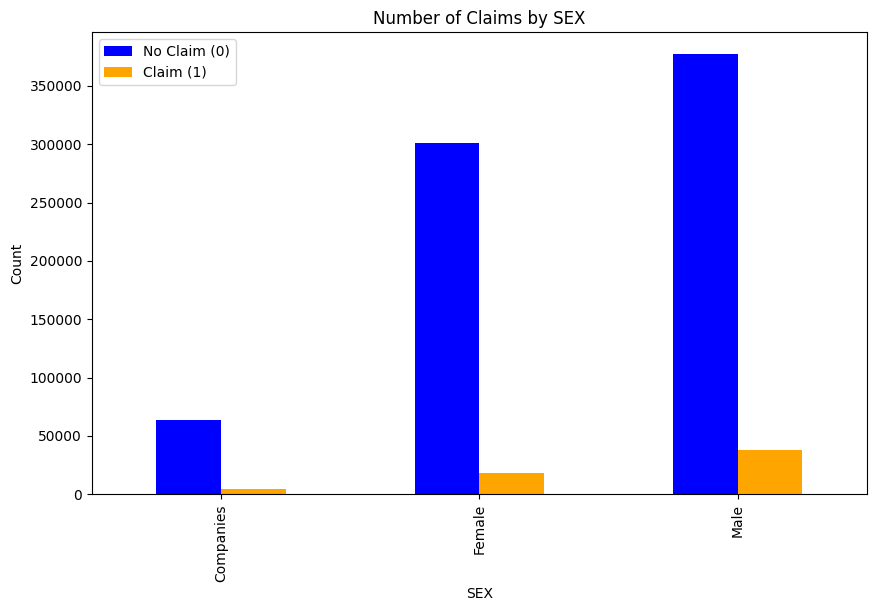

In [29]:
claim_counts = df.groupby(['SEX', 'CLAIM_FLAG']).size().unstack()

claim_counts.plot(kind='bar', figsize=(10,6), color=['blue', 'orange'])

plt.title("Number of Claims by SEX")
plt.xlabel("SEX")
plt.ylabel("Count")
plt.legend(["No Claim (0)", "Claim (1)"])
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">


üìä ŸÖÿ¥ÿßŸáÿØŸá‚ÄåŸáÿß:  
- üë® **ŸÖÿ±ÿØÿßŸÜ (Male):** ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ÿ™ÿπÿØÿßÿØ ÿÆÿ≥ÿßÿ±ÿ™ ÿ´ÿ®ÿ™‚Äåÿ¥ÿØŸá ÿ±Ÿà ÿØÿßÿ±ŸÜ (ÿ®€åÿ¥ ÿßÿ≤ **40,000 Claim**).  
- üë© **ÿ≤ŸÜÿßŸÜ (Female):** ÿ™ÿπÿØÿßÿØ ÿÆÿ≥ÿßÿ±ÿ™ ⁄©ŸÖÿ™ÿ± ÿßÿ≤ ŸÖÿ±ÿØÿßŸÜ (ÿ≠ÿØŸàÿØ **20,000 Claim**)ÿå ÿØÿ± ÿ≠ÿßŸÑ€å ⁄©Ÿá ÿ™ÿπÿØÿßÿØ ÿ®€åŸÖŸá‚ÄåŸÜÿßŸÖŸá‚ÄåŸáÿßÿ¥ŸàŸÜ ÿ®ÿßŸÑÿßÿ≥ÿ™.  
- üè¢ **ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß (Companies):** ⁄©ŸÖÿ™ÿ±€åŸÜ ÿ™ÿπÿØÿßÿØ ÿÆÿ≥ÿßÿ±ÿ™ (⁄ÜŸÜÿØ Ÿáÿ≤ÿßÿ± Claim)ÿå ŸáŸÖ‚Äåÿ±ÿßÿ≥ÿ™ÿß ÿ®ÿß ÿ≥ŸáŸÖ ÿ®ÿßÿ≤ÿßÿ± ⁄©Ÿà⁄Ü⁄©ÿ¥ÿßŸÜ.  

### üìå ŸÜ⁄©ÿßÿ™ ⁄©ŸÑ€åÿØ€å (Insights):  
- üë® ŸÖÿ±ÿØÿßŸÜ ŸÜŸá‚Äåÿ™ŸÜŸáÿß ÿ®ÿßŸÑÿßÿ™ÿ±€åŸÜ ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ±Ÿà ÿØÿßÿ±ŸÜ (ŸÜŸÖŸàÿØÿßÿ± ŸÇÿ®ŸÑ€å)ÿå ÿ®ŸÑ⁄©Ÿá **ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ÿ™ÿπÿØÿßÿØ ÿÆÿ≥ÿßÿ±ÿ™ ŸÖÿ∑ŸÑŸÇ** ÿ±Ÿà ŸáŸÖ ÿ´ÿ®ÿ™ ŸÖ€å‚Äå⁄©ŸÜŸÜ ‚Üí ŸÅÿ¥ÿßÿ± ŸÖÿßŸÑ€å ÿßÿµŸÑ€å ÿ±Ÿà€å ÿ¥ÿ±⁄©ÿ™ ÿ®€åŸÖŸá.  
- üë© ÿ≤ŸÜÿßŸÜ ÿ®ÿß ÿ™ÿπÿØÿßÿØ ÿÆÿ≥ÿßÿ±ÿ™ ⁄©ŸÖÿ™ÿ± Ÿà ŸÜÿ±ÿÆ Ÿæÿß€å€åŸÜ‚Äåÿ™ÿ± ‚Üí ⁄Øÿ±ŸàŸá€å **ÿ≥ŸàÿØÿ¢Ÿàÿ± Ÿà ⁄©ŸÖ‚Äåÿ±€åÿ≥⁄©** Ÿáÿ≥ÿ™ŸÜÿØ.  
- üè¢ ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß€å ⁄©ŸÖÿ™ÿ±€å ÿØÿßÿ±ŸÜ ‚Üí ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ≠ÿ¨ŸÖ ⁄©ŸÖ ÿ®ÿßÿ≤ÿßÿ±ÿå ÿ±€åÿ≥⁄© ÿß€åŸÜ ÿ®ÿÆÿ¥ ŸÜÿ≥ÿ®ÿ™ÿßŸã Ÿæÿß€å€åŸÜ‚Äåÿ™ÿ±Ÿá.  

</div>

---


üìä Observations:  
- üë® **Males:** Record the highest number of claims (**40,000+**), making them the **largest risk contributor**.  
- üë© **Females:** Fewer claims (~20,000) despite having a large insured base ‚Üí safer and more profitable segment.  
- üè¢ **Companies:** Very few claims (a few thousand), aligned with their small share of the market.  

### üìå Key Insights:  
- üë® Males ‚Üí Highest claim rate + Highest claim volume ‚Üí **major financial burden** for insurers.  
- üë© Females ‚Üí Lower rate + Fewer claims ‚Üí **most profitable group**.  
- üè¢ Companies ‚Üí Small volume + Few claims ‚Üí **low-risk but limited potential** segment.  


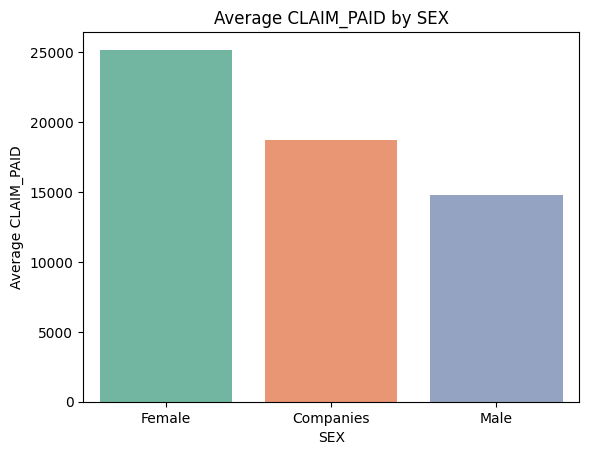

In [30]:
Claim_paid = df.groupby('SEX')['CLAIM_PAID'].mean().reset_index().sort_values(by='CLAIM_PAID', ascending=False)
sns.barplot(data=Claim_paid, x='SEX', y='CLAIM_PAID', palette='Set2')
plt.title('Average CLAIM_PAID by SEX')
plt.ylabel('Average CLAIM_PAID')
plt.xlabel('SEX')
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



üë© **ÿ≤ŸÜÿßŸÜ (Female):** ÿ®ÿßŸÑÿßÿ™ÿ±€åŸÜ ŸÖ€åÿßŸÜ⁄Ø€åŸÜ ÿÆÿ≥ÿßÿ±ÿ™ Ÿæÿ±ÿØÿßÿÆÿ™€åÿå ÿ≠ÿØŸàÿØ **25,000** ‚Üí €åÿπŸÜ€å Ÿáÿ± ÿ®ÿßÿ± ÿÆÿ≥ÿßÿ±ÿ™ ÿØÿ± ÿß€åŸÜ ⁄Øÿ±ŸàŸá ŸÖÿπŸÖŸàŸÑÿßŸã **ŸÖÿ®ŸÑÿ∫ ÿ®ÿßŸÑÿßÿ™ÿ±€å** ÿØÿßÿ¥ÿ™Ÿá.  

üè¢ **ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß (Companies):** ŸÖ€åÿßŸÜ⁄Ø€åŸÜ ÿÆÿ≥ÿßÿ±ÿ™ Ÿæÿ±ÿØÿßÿÆÿ™€å ÿ≠ÿØŸàÿØ **19,000** ‚Üí ÿØÿ± ÿ≥ÿ∑ÿ≠ ŸÖÿ™Ÿàÿ≥ÿ∑.  

üë® **ŸÖÿ±ÿØÿßŸÜ (Male):** Ÿæÿß€å€åŸÜ‚Äåÿ™ÿ±€åŸÜ ŸÖ€åÿßŸÜ⁄Ø€åŸÜ ÿÆÿ≥ÿßÿ±ÿ™ Ÿæÿ±ÿØÿßÿÆÿ™€åÿå ÿ≠ÿØŸàÿØ **15,000** ‚Üí ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß€åÿ¥ÿßŸÜ ÿ®Ÿá ÿ∑Ÿàÿ± ŸÖ€åÿßŸÜ⁄Ø€åŸÜ **⁄©ŸÖ‚ÄåŸáÿ≤€åŸÜŸá‚Äåÿ™ÿ±** ÿ®ŸàÿØŸá.  

### üìå ŸÜ⁄©ÿßÿ™ ⁄©ŸÑ€åÿØ€å (Insights):  
- üë© ÿ®ÿß ÿß€åŸÜ⁄©Ÿá ÿ≤ŸÜÿßŸÜ ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ Ÿæÿß€å€åŸÜ‚Äåÿ™ÿ±€å ÿØÿßÿ±ŸÜÿØ (ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß€å ŸÇÿ®ŸÑ€å)ÿå ŸàŸÑ€å ŸàŸÇÿ™€å ÿÆÿ≥ÿßÿ±ÿ™ ÿßÿ™ŸÅÿßŸÇ ŸÖ€å‚ÄåÿßŸÅÿ™ÿØÿå **ŸÖÿ®ŸÑÿ∫ Ÿæÿ±ÿØÿßÿÆÿ™€å ÿ®€åÿ¥ÿ™ÿ±** ÿßÿ≥ÿ™.  
- üë® ŸÖÿ±ÿØÿßŸÜ ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß€å ÿ®€åÿ¥ÿ™ÿ±€å ÿØÿßÿ±ŸÜÿØ ÿßŸÖÿß ŸÖÿ®ŸÑÿ∫ Ÿáÿ± ÿÆÿ≥ÿßÿ±ÿ™ ŸÖÿπŸÖŸàŸÑÿßŸã ⁄©ŸÖÿ™ÿ± ÿßÿ≥ÿ™ ‚Üí ŸÅÿ¥ÿßÿ± ÿ®€åŸÖŸá‚Äå⁄Øÿ± ÿ®€åÿ¥ÿ™ÿ± ÿßÿ≤ ÿ≠ÿ¨ŸÖ ÿ≤€åÿßÿØ ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿßÿ≥ÿ™ ŸÜŸá ŸÖÿ®ŸÑÿ∫ Ÿáÿ± ⁄©ÿØÿßŸÖ.  
- üè¢ ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß ÿØÿ± Ÿàÿ≥ÿ∑ ŸÇÿ±ÿßÿ± ÿØÿßÿ±ŸÜÿØ ‚Üí ŸáŸÖ ÿßÿ≤ ŸÜÿ∏ÿ± ŸÜÿ±ÿÆ Ÿà ŸáŸÖ ŸÖÿ®ŸÑÿ∫ ÿÆÿ≥ÿßÿ±ÿ™ÿå ⁄Øÿ±ŸàŸá€å ŸÖÿ™ÿπÿßÿØŸÑ ŸÖÿ≠ÿ≥Ÿàÿ® ŸÖ€å‚Äåÿ¥ŸàŸÜÿØ.  

</div>

---
 

üë© **Females:** Highest average claim paid (~25,000) ‚Üí Each claim tends to be **more expensive**.  

üè¢ **Companies:** Moderate average claim paid (~19,000).  

üë® **Males:** Lowest average claim paid (~15,000) ‚Üí Individual claims are **cheaper**, but occur more frequently.  

### üìå Key Insights:  
- üë© Females ‚Üí Fewer claims, but when they happen, they **cost more**.  
- üë® Males ‚Üí More frequent claims, but each one is **lower in value**.  
- üè¢ Companies ‚Üí Balanced position, with **moderate claim costs**.  


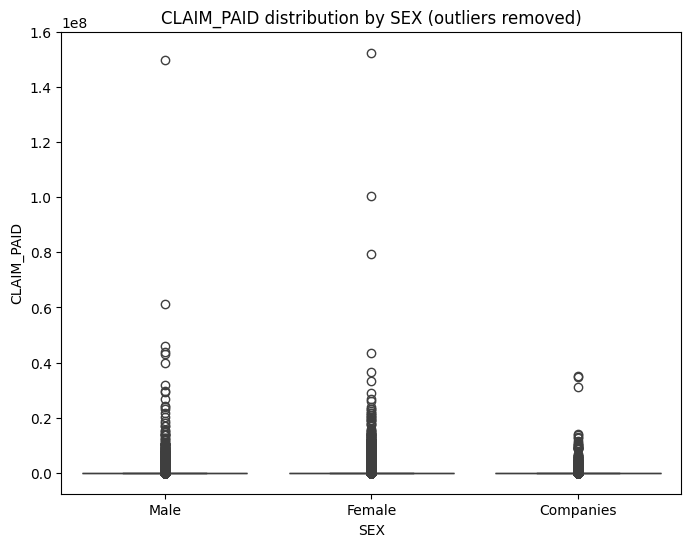

In [31]:
plt.figure(figsize=(8,6))
sns.boxplot(x='SEX', y='CLAIM_PAID', data=df, showfliers=True)  
plt.title("CLAIM_PAID distribution by SEX (outliers removed)")
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

 

üìä ŸÖÿ¥ÿßŸáÿØŸá‚ÄåŸáÿß:  
- üë® **ŸÖÿ±ÿØÿßŸÜ (Male):** ⁄Øÿ≥ÿ™ÿ±Ÿá‚Äå€å ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß ŸÜÿ≥ÿ®ÿ™ÿßŸã Ÿàÿ≥€åÿπ ÿßÿ≥ÿ™ÿå ÿ®ÿß ŸÖŸàÿßÿ±ÿØ ŸÖÿ™ÿπÿØÿØ€å ÿØÿ± ŸÖÿ≠ÿØŸàÿØŸá ÿ®ÿßŸÑÿß (ŸàŸÑ€å ⁄©ŸÖÿ™ÿ± ÿßÿ≤ ÿ≤ŸÜÿßŸÜ).  
- üë© **ÿ≤ŸÜÿßŸÜ (Female):** ÿ™Ÿàÿ≤€åÿπ ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß ŸæŸáŸÜ‚Äåÿ™ÿ± Ÿà Ÿæÿ±ÿß⁄©ŸÜÿØ⁄Ø€å ÿ®€åÿ¥ÿ™ÿ± ÿØÿßÿ±ÿØ ‚Üí ŸÜÿ¥ÿßŸÜ ŸÖ€å‚ÄåÿØŸáÿØ ⁄©Ÿá ÿØÿ± ÿ®€åŸÜ ÿ≤ŸÜÿßŸÜÿå ŸàŸÇÿ™€å ÿÆÿ≥ÿßÿ±ÿ™ ÿ±ÿÆ ŸÖ€å‚ÄåÿØŸáÿØÿå ÿßÿ≠ÿ™ŸÖÿßŸÑ Ÿæÿ±ÿØÿßÿÆÿ™‚ÄåŸáÿß€å ÿ®ÿ≥€åÿßÿ± ÿ®ÿßŸÑÿß Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ.  
- üè¢ **ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß (Companies):** ÿØÿßŸÖŸÜŸá ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß ŸÖÿ≠ÿØŸàÿØÿ™ÿ± ÿßÿ≥ÿ™ Ÿà Ÿæÿ±ÿß⁄©ŸÜÿØ⁄Ø€å ÿ®ÿ≥€åÿßÿ± ⁄©ŸÖÿ™ÿ± ÿßÿ≤ ÿßŸÅÿ±ÿßÿØ ÿ≠ŸÇ€åŸÇ€å ‚Üí ŸÜÿ¥ÿßŸÜ‚ÄåÿØŸáŸÜÿØŸá‚Äå€å **ÿ±€åÿ≥⁄© Ÿæÿß€å€åŸÜ‚Äåÿ™ÿ± ÿØÿ± ÿ™ŸÜŸàÿπ ŸÖÿ®ŸÑÿ∫ ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß**.  

### üìå ŸÜ⁄©ÿßÿ™ ⁄©ŸÑ€åÿØ€å (Insights):  
- üë® ŸÖÿ±ÿØÿßŸÜ ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß€å Ÿæÿ±ÿ™ÿπÿØÿßÿØ ŸàŸÑ€å ÿ®ÿß ŸÖÿ®ÿßŸÑÿ∫ ŸÖÿπŸÖŸàŸÑÿßŸã ⁄©ŸÖÿ™ÿ± ÿØÿßÿ±ŸÜÿØ.  
- üë© ÿ≤ŸÜÿßŸÜ ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß€å ⁄©ŸÖÿ™ÿ±€å ÿØÿßÿ±ŸÜÿØÿå ÿßŸÖÿß ŸàŸÇÿ™€å ÿÆÿ≥ÿßÿ±ÿ™ ÿßÿ™ŸÅÿßŸÇ ŸÖ€å‚ÄåÿßŸÅÿ™ÿØÿå **ÿ±€åÿ≥⁄© ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß€å ÿ®ÿ≥€åÿßÿ± ÿ®ÿ≤ÿ±⁄Ø‚Äåÿ™ÿ±** ÿ®ÿßŸÑÿßÿ≥ÿ™.  
- üè¢ ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß€å €å⁄©ŸÜŸàÿßÿÆÿ™‚Äåÿ™ÿ± ÿØÿßÿ±ŸÜÿØÿå ÿ®ÿØŸàŸÜ ÿ¥Ÿà⁄©‚ÄåŸáÿß€å ÿÆ€åŸÑ€å ÿ®ÿ≤ÿ±⁄Øÿå Ÿà ÿßÿ≤ ÿß€åŸÜ ŸÜÿ∏ÿ± ÿ®ÿ±ÿß€å ÿ®€åŸÖŸá‚Äå⁄Øÿ± **ŸÇÿßÿ®ŸÑ Ÿæ€åÿ¥‚Äåÿ®€åŸÜ€å‚Äåÿ™ÿ±** Ÿáÿ≥ÿ™ŸÜÿØ.  

</div>

---



üìä Observations:  
- üë® **Males:** Wide range of claims, but extreme high values are less common compared to females.  
- üë© **Females:** Show a broader distribution with higher outliers ‚Üí when claims occur, they can sometimes be **very costly**.  
- üè¢ **Companies:** Narrower distribution with lower variability ‚Üí **more predictable** claim costs.  

### üìå Key Insights:  
- üë® Males ‚Üí Many claims, but typically smaller amounts.  
- üë© Females ‚Üí Fewer claims, but **potential for very high payouts**.  
- üè¢ Companies ‚Üí Consistent and more **stable claim distributions**.  


In [32]:
# Remove outliers using IQR
Q1 = df['CLAIM_PAID'].quantile(0.25)
Q3 = df['CLAIM_PAID'].quantile(0.75)
IQR = Q3 - Q1

df_no_outliers = df[(df['CLAIM_PAID'] >= Q1 - 1.5 * IQR) & (df['CLAIM_PAID'] <= Q3 + 1.5 * IQR)]

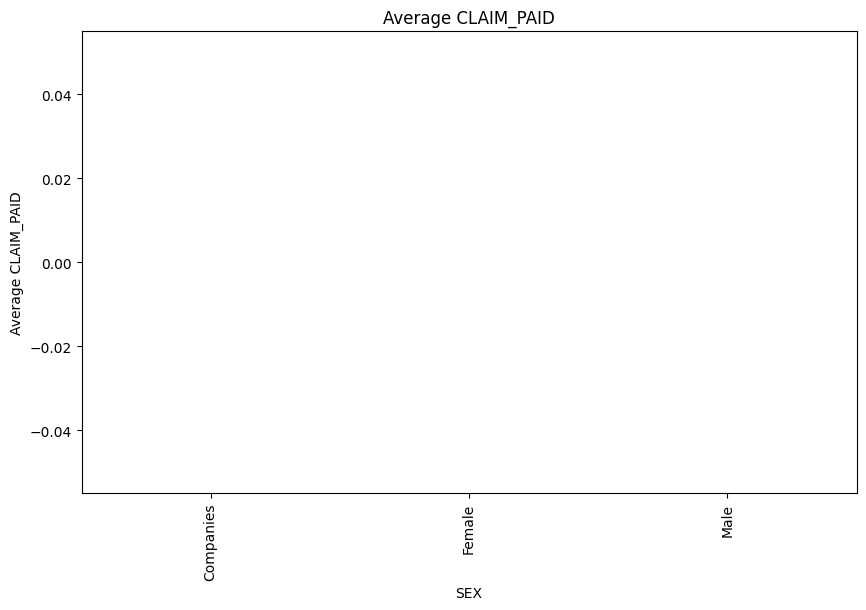

In [33]:
df_no_outliers.groupby('SEX')['CLAIM_PAID'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title("Average CLAIM_PAID")
plt.xlabel("SEX")
plt.ylabel("Average CLAIM_PAID")
plt.show()

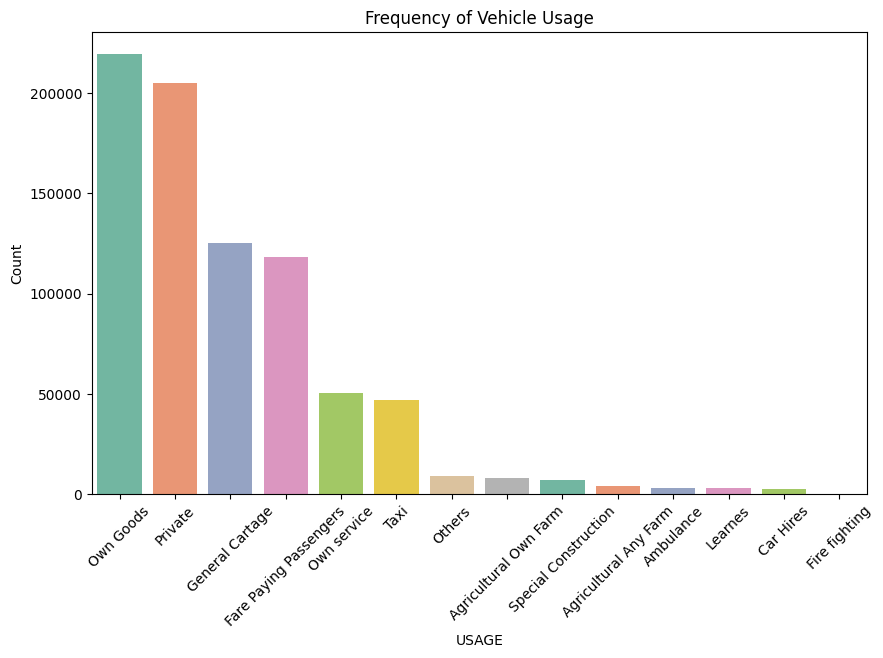

In [34]:
plt.figure(figsize=(10,6))
sns.countplot(x="USAGE", data=df, order=df["USAGE"].value_counts().index, palette="Set2")
plt.title("Frequency of Vehicle Usage")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



üìä ŸÖÿ¥ÿßŸáÿØŸá‚ÄåŸáÿß:  
- üöö **Own Goods (ÿ≠ŸÖŸÑ ⁄©ÿßŸÑÿß€å ÿ¥ÿÆÿµ€å):** ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ÿ≥ŸáŸÖ (ÿ®€åÿ¥ ÿßÿ≤ 220,000 Ÿàÿ≥€åŸÑŸá ŸÜŸÇŸÑ€åŸá).  
- üöó **Private (ÿ¥ÿÆÿµ€å):** ÿØŸàŸÖ€åŸÜ ÿ±ÿ™ÿ®Ÿá ÿ®ÿß ÿ®€åÿ¥ ÿßÿ≤ 200,000 Ÿàÿ≥€åŸÑŸá.  
- üöõ **General Cartage (ÿ≠ŸÖŸÑ ÿ®ÿßÿ± ÿπŸÖŸàŸÖ€å):** ÿ≥ŸàŸÖ€åŸÜ ÿ±ÿ™ÿ®Ÿá ÿ®ÿß ÿ≠ÿØŸàÿØ 125,000 Ÿàÿ≥€åŸÑŸá.  
- üöå **Fare Paying Passengers (ŸÖÿ≥ÿßŸÅÿ±ÿ®ÿ±€å):** ÿ≥ŸáŸÖ ŸÇÿßÿ®ŸÑ ÿ™Ÿàÿ¨Ÿáÿå ⁄©ŸÖ€å ⁄©ŸÖÿ™ÿ± ÿßÿ≤ 120,000.  
- üöï **Taxi:** ÿ±ÿ™ÿ®Ÿá ÿ®ÿπÿØ€åÿå ÿ≠ÿØŸàÿØ 50,000 Ÿàÿ≥€åŸÑŸá.  
- ‚öôÔ∏è ÿ≥ÿß€åÿ± ÿØÿ≥ÿ™Ÿá‚ÄåŸáÿß (ŸÖÿßŸÜŸÜÿØ **⁄©ÿ¥ÿßŸàÿ±ÿ≤€åÿå ÿ≥ÿßÿÆÿ™‚ÄåŸàÿ≥ÿßÿ≤ Ÿà€å⁄òŸáÿå ÿ¢ŸÖÿ®ŸàŸÑÿßŸÜÿ≥ÿå ÿßÿ¨ÿßÿ±Ÿá‚Äåÿß€åÿå ÿ¢ÿ™ÿ¥‚ÄåŸÜÿ¥ÿßŸÜ€å**) ÿ≥ŸáŸÖ ÿÆ€åŸÑ€å ⁄©ŸÖÿ™ÿ±€å ÿØÿßÿ±ŸÜÿØ.  

### üìå ŸÜ⁄©ÿßÿ™ ⁄©ŸÑ€åÿØ€å (Insights):  
- ÿ®ÿßÿ≤ÿßÿ± ÿ®€åŸÖŸá Ÿàÿ≥ÿß€åŸÑ ŸÜŸÇŸÑ€åŸá ÿ®Ÿá ÿ¥ÿØÿ™ ÿ™ÿ≠ÿ™ ÿ™ÿ£ÿ´€åÿ± **ÿÆŸàÿØÿ±ŸàŸáÿß€å ÿ¥ÿÆÿµ€å Ÿà ÿ®ÿßÿ±€å (Own Goods + Private)** ÿßÿ≥ÿ™ ‚Üí ÿß€åŸÜ ÿØŸà ÿØÿ≥ÿ™Ÿá ÿ®€åÿ¥ ÿßÿ≤ **ŸÜ€åŸÖ€å ÿßÿ≤ ⁄©ŸÑ ÿ®ÿßÿ≤ÿßÿ±** ÿ±ÿß ÿ™ÿ¥⁄©€åŸÑ ŸÖ€å‚ÄåÿØŸáŸÜÿØ.  
- **Ÿàÿ≥ÿß€åŸÑ ŸÜŸÇŸÑ€åŸá ÿπŸÖŸàŸÖ€å (General Cartage + Fare Paying Passengers + Taxi)** ÿ≥ŸáŸÖ ŸÇÿßÿ®ŸÑ ÿ™Ÿàÿ¨Ÿá€å ÿØÿßÿ±ŸÜÿØ Ÿà ÿ®Ÿá ÿØŸÑ€åŸÑ ÿ±€åÿ≥⁄© ÿ®ÿßŸÑÿßÿ™ÿ± ÿ®ÿß€åÿØ ÿØÿ± **ŸÖÿØŸÑ ŸÇ€åŸÖÿ™‚Äå⁄Øÿ∞ÿßÿ±€å ÿØŸÇ€åŸÇ‚Äåÿ™ÿ±** ŸÑÿ≠ÿßÿ∏ ÿ¥ŸàŸÜÿØ.  
- ÿØÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ⁄©Ÿà⁄Ü⁄©‚Äåÿ™ÿ± (⁄©ÿ¥ÿßŸàÿ±ÿ≤€åÿå ÿÆÿØŸÖÿßÿ™ Ÿà€å⁄òŸá Ÿà ÿ∫€åÿ±Ÿá) ÿ≠ÿ¨ŸÖ ⁄©ŸÖ€å ÿØÿßÿ±ŸÜÿØÿå ÿßŸÖÿß ŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÜÿØ ŸÅÿ±ÿµÿ™‚ÄåŸáÿß€å **ÿ®ÿßÿ≤ÿßÿ±€åÿßÿ®€å ÿ™ÿÆÿµÿµ€å** ÿß€åÿ¨ÿßÿØ ⁄©ŸÜŸÜÿØ.  

</div>

---

 

üìä Observations:  
- üöö **Own Goods:** Largest segment (>220,000 vehicles).  
- üöó **Private:** Second largest (>200,000).  
- üöõ **General Cartage:** Third (~125,000).  
- üöå **Fare Paying Passengers:** Significant (~115,000).  
- üöï **Taxi:** Moderate (~50,000).  
- ‚öôÔ∏è Other categories (Agriculture, Special Construction, Ambulance, Hires, Firefighting) ‚Üí very small share.  

### üìå Key Insights:  
- The insurance market is dominated by **Own Goods + Private vehicles**, together forming **over half the market**.  
- **Public/commercial vehicles (General Cartage, Fare Paying, Taxi)** are important high-risk groups requiring **risk-based premium strategies**.  
- Smaller categories, though limited in volume, represent **niche opportunities** for tailored insurance products.  


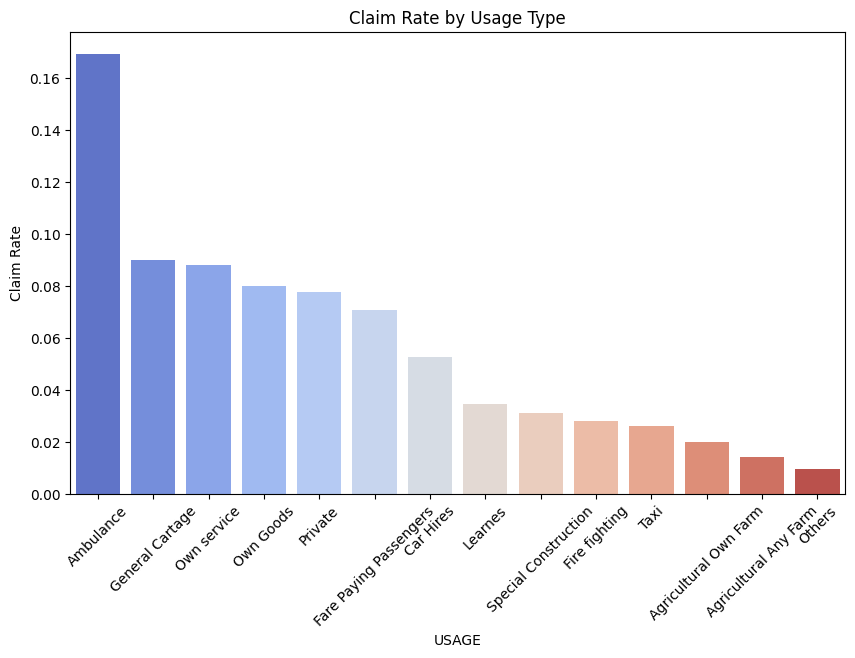

In [35]:
claim_rate_usage = df.groupby("USAGE")["CLAIM_FLAG"].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x="USAGE", y="CLAIM_FLAG", data=claim_rate_usage, order=claim_rate_usage.sort_values("CLAIM_FLAG", ascending=False)["USAGE"], palette="coolwarm")
plt.title("Claim Rate by Usage Type")
plt.ylabel("Claim Rate")
plt.xticks(rotation=45)
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



üìä ŸÖÿ¥ÿßŸáÿØŸá‚ÄåŸáÿß:  
- üöë **Ambulance (ÿ¢ŸÖÿ®ŸàŸÑÿßŸÜÿ≥):** ÿ®ÿßŸÑÿßÿ™ÿ±€åŸÜ ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿß ÿ≠ÿØŸàÿØ **17%**.  
- üöõ **General Cartage (ÿ≠ŸÖŸÑ ÿ®ÿßÿ± ÿπŸÖŸàŸÖ€å):** ŸÜÿ±ÿÆ ŸÜÿ≥ÿ®ÿ™ÿßŸã ÿ®ÿßŸÑÿßÿå ÿ≠ÿØŸàÿØ **9%**.  
- ‚öôÔ∏è **Own Service / Own Goods:** ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿßŸÑÿßÿ™ÿ± ÿßÿ≤ ŸÖ€åÿßŸÜ⁄Ø€åŸÜ (~8‚Äì9%).  
- üöó **Private (ÿ¥ÿÆÿµ€å):** ⁄©ŸÖ€å ⁄©ŸÖÿ™ÿ± ÿßÿ≤ ŸÖÿ™Ÿàÿ≥ÿ∑ (~7%).  
- üöå **Fare Paying Passengers:** ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ Ÿæÿß€å€åŸÜ‚Äåÿ™ÿ± (~5%).  
- üöï **Taxi** Ÿà ÿØÿ≥ÿ™Ÿá‚ÄåŸáÿß€å **⁄©ÿ¥ÿßŸàÿ±ÿ≤€å** (Agricultural) ‚Üí ⁄©ŸÖÿ™ÿ±€åŸÜ ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ (~2‚Äì3%).  
- üî• **Fire Fighting** Ÿà **Special Construction:** ŸÜÿ≤ÿØ€å⁄© ÿ®Ÿá ŸÖ€åÿßŸÜ⁄Ø€åŸÜ Ÿæÿß€å€åŸÜ (~3‚Äì4%).  

### üìå ŸÜ⁄©ÿßÿ™ ⁄©ŸÑ€åÿØ€å (Insights):  
- üöë **ÿ¢ŸÖÿ®ŸàŸÑÿßŸÜÿ≥‚ÄåŸáÿß Ÿæÿ±ÿ±€åÿ≥⁄©‚Äåÿ™ÿ±€åŸÜ ⁄Øÿ±ŸàŸá Ÿáÿ≥ÿ™ŸÜÿØ** ‚Üí ÿ®Ÿá ÿØŸÑ€åŸÑ ŸÖÿßŸá€åÿ™ ÿπŸÖŸÑ€åÿßÿ™€å Ÿà ÿ™ÿ±ÿØÿØ ÿØÿ± ÿ¥ÿ±ÿß€åÿ∑ ÿßÿ∂ÿ∑ÿ±ÿßÿ±€å.  
- üöõ **ÿÆŸàÿØÿ±ŸàŸáÿß€å ÿ®ÿßÿ±€å ÿπŸÖŸàŸÖ€å** ŸáŸÖ ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿßŸÑÿß€å€å ÿØÿßÿ±ŸÜÿØ ‚Üí ŸÜ€åÿßÿ≤ŸÖŸÜÿØ ŸÖÿØ€åÿ±€åÿ™ ÿ±€åÿ≥⁄© Ÿà€å⁄òŸá Ÿà ÿ™ÿπÿ±ŸÅŸá‚ÄåŸáÿß€å ÿØŸÇ€åŸÇ‚Äåÿ™ÿ±.  
- üöó ÿÆŸàÿØÿ±ŸàŸáÿß€å ÿ¥ÿÆÿµ€å Ÿà ÿπŸÖŸàŸÖ€å (Private + Fare Paying) ÿ±€åÿ≥⁄© ŸÖÿ™Ÿàÿ≥ÿ∑ ÿ±Ÿà ÿ®Ÿá Ÿæÿß€å€åŸÜ ÿØÿßÿ±ŸÜÿØ ‚Üí ÿ®ÿßÿ≤ÿßÿ± ÿßÿµŸÑ€å ÿßŸÖÿß ŸÜÿ≥ÿ®ÿ™ÿßŸã ÿßŸÖŸÜ‚Äåÿ™ÿ±.  
- üöï ÿ™ÿß⁄©ÿ≥€å‚ÄåŸáÿß Ÿà Ÿàÿ≥ÿß€åŸÑ ⁄©ÿ¥ÿßŸàÿ±ÿ≤€å ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ Ÿæÿß€å€åŸÜ ÿØÿßÿ±ŸÜÿØ ‚Üí ÿßŸÖÿß ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ **ÿ≠ÿ¨ŸÖ ÿÆÿ≥ÿßÿ±ÿ™** ÿ®ÿßŸÑÿß ŸÜÿ®ÿßÿ¥ÿØ ⁄ÜŸàŸÜ ÿ™ÿπÿØÿßÿØÿ¥ÿßŸÜ ŸáŸÖ ŸÖÿ≠ÿØŸàÿØ ÿßÿ≥ÿ™.  

</div>

---



üìä Observations:  
- üöë **Ambulances:** Highest claim rate (~17%).  
- üöõ **General Cartage:** High (~9%).  
- ‚öôÔ∏è **Own Service / Own Goods:** Above average (~8‚Äì9%).  
- üöó **Private:** Slightly below average (~7%).  
- üöå **Fare Paying Passengers:** Lower (~5%).  
- üöï **Taxis** and **Agricultural vehicles:** Lowest claim rates (~2‚Äì3%).  
- üî• **Fire Fighting** & **Special Construction:** Also relatively low (~3‚Äì4%).  

### üìå Key Insights:  
- üöë **Ambulances are the riskiest segment** due to emergency and high-frequency usage.  
- üöõ **General Cartage vehicles** show high risk ‚Üí need **special pricing and risk control**.  
- üöó **Private and passenger vehicles** are safer, making them the **core stable market**.  
- üöï **Taxis & Agricultural vehicles** have low claim rates, but their market volume is small.  


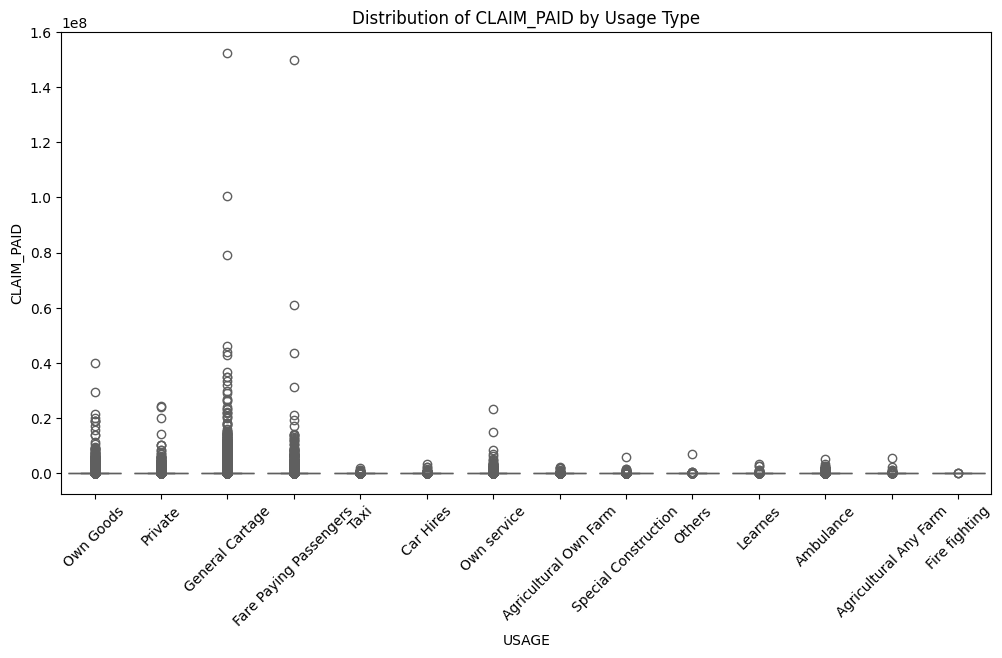

In [36]:
plt.figure(figsize=(12,6))
sns.boxplot(x="USAGE", y="CLAIM_PAID", data=df, palette="Set3")
plt.title("Distribution of CLAIM_PAID by Usage Type")
plt.xticks(rotation=45)
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">


üìä ŸÖÿ¥ÿßŸáÿØŸá‚ÄåŸáÿß:  
- üì¶ **Own Goods** Ÿà üöó **Private** ‚Üí ÿ®€åÿ¥ÿ™ÿ±€åŸÜ Ÿæÿ±ÿß⁄©ŸÜÿØ⁄Ø€å Ÿæÿ±ÿØÿßÿÆÿ™ ÿÆÿ≥ÿßÿ±ÿ™ÿõ ÿ®ÿπÿ∂€å ÿßÿ≤ ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß ÿ™ÿß ÿ≥ÿ∑Ÿàÿ≠ ÿ®ÿ≥€åÿßÿ± ÿ®ÿßŸÑÿß (Outliers) ŸÖÿ¥ÿßŸáÿØŸá ÿ¥ÿØŸá.  
- üöõ **General Cartage** ‚Üí ÿ™ÿπÿØÿßÿØ ÿ≤€åÿßÿØ€å ÿÆÿ≥ÿßÿ±ÿ™ Ÿà ŸáŸÖ⁄ÜŸÜ€åŸÜ ⁄ÜŸÜÿØ€åŸÜ ŸÖŸàÿ±ÿØ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿ≥€åÿßÿ± ÿ®ÿ≤ÿ±⁄Ø ‚Üí ÿ±€åÿ≥⁄© ÿ®ÿßŸÑÿß.  
- üöå **Fare Paying Passengers** ‚Üí ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß Ÿæÿ±ÿß⁄©ŸÜÿØ⁄Ø€å ŸÖÿ™Ÿàÿ≥ÿ∑ ÿØÿßÿ±ŸÜ ÿßŸÖÿß ⁄ÜŸÜÿØ ŸÜŸÖŸàŸÜŸá Ÿæÿ±ÿØÿßÿÆÿ™ ÿ®ÿ≤ÿ±⁄Ø ÿØ€åÿØŸá ŸÖ€å‚Äåÿ¥Ÿá.  
- üöï **Taxi** Ÿà üöê **Car Hires** ‚Üí ÿßÿ∫ŸÑÿ® ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß€å ⁄©Ÿà⁄Ü⁄©ÿå Outlier ⁄©ŸÖ€å ÿØÿßÿ±ŸÜ.  
- üöë **Ambulance** ‚Üí ÿπŸÑ€å‚Äåÿ±ÿ∫ŸÖ ŸÜÿ±ÿÆ ÿ®ÿßŸÑÿß€å ÿÆÿ≥ÿßÿ±ÿ™ (Claim Rate)ÿå Ÿæÿ±ÿß⁄©ŸÜÿØ⁄Ø€å ŸÖÿ®ŸÑÿ∫ Ÿæÿ±ÿØÿßÿÆÿ™€å Ÿæÿß€å€åŸÜ‚Äåÿ™ÿ±Ÿá.  
- üöú **⁄©ÿ¥ÿßŸàÿ±ÿ≤€å (Agricultural Any/Own Farm)** Ÿà üî• **Fire Fighting** ‚Üí ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß€å ⁄©ŸÖ Ÿà ŸÖÿ®ÿßŸÑÿ∫ ŸÜÿ≥ÿ®ÿ™ÿßŸã Ÿæÿß€å€åŸÜ.  

### üìå ŸÜ⁄©ÿßÿ™ ⁄©ŸÑ€åÿØ€å (Insights):  
- üì¶ **Own Goods Ÿà Private** ‚Üí ÿ®ÿÆÿ¥ Ÿæÿ±ÿ±€åÿ≥⁄© ÿ®ÿ±ÿß€å ÿ®€åŸÖŸá‚Äå⁄Øÿ± ÿßÿ≤ ŸÜÿ∏ÿ± ÿ≠ÿ¨ŸÖ Ÿà ŸÖÿ®ŸÑÿ∫ ÿÆÿ≥ÿßÿ±ÿ™.  
- üöõ **General Cartage** ‚Üí ÿ™ÿ±⁄©€åÿ® "ÿ™ÿπÿØÿßÿØ ÿ≤€åÿßÿØ + ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß€å ÿ≥ŸÜ⁄Ø€åŸÜ" ‚Üí ŸÜ€åÿßÿ≤ŸÖŸÜÿØ ŸÖÿØ€åÿ±€åÿ™ ÿ±€åÿ≥⁄© Ÿà€å⁄òŸá.  
- üöï ÿ™ÿß⁄©ÿ≥€å‚ÄåŸáÿß Ÿà ÿ®ÿÆÿ¥ ⁄©ÿ¥ÿßŸàÿ±ÿ≤€å ‚Üí ⁄©ŸÖ‚Äåÿ±€åÿ≥⁄©‚Äåÿ™ÿ± ŸáŸÖ ÿßÿ≤ ŸÜÿ∏ÿ± ÿ™ÿπÿØÿßÿØ ŸáŸÖ ÿßÿ≤ ŸÜÿ∏ÿ± ŸÖÿ®ŸÑÿ∫.  
- üöë ÿ¢ŸÖÿ®ŸàŸÑÿßŸÜÿ≥ ‚Üí ÿ±€åÿ≥⁄© ÿ®ÿßŸÑÿß€å **ŸàŸÇŸàÿπ ÿÆÿ≥ÿßÿ±ÿ™** ÿßŸÖÿß ŸÜŸá ŸÑÿ≤ŸàŸÖÿßŸã ÿßÿ≤ ŸÜÿ∏ÿ± ŸÖÿ®ŸÑÿ∫ ÿÆÿ≥ÿßÿ±ÿ™ Ÿæÿ±ÿØÿßÿÆÿ™€å.  

</div>

---



üìä Observations:  
- üì¶ **Own Goods & Private:** Highest spread of claim payments with some very large outliers.  
- üöõ **General Cartage:** Many claims plus several very high-cost claims ‚Üí high risk.  
- üöå **Fare Paying Passengers:** Medium spread, with some big payments.  
- üöï **Taxis & Car Hires:** Mostly small claims, very few outliers.  
- üöë **Ambulances:** High claim frequency but lower claim payment amounts.  
- üöú **Agricultural & Fire Fighting vehicles:** Very few and small claims.  

### üìå Key Insights:  
- üì¶ **Own Goods and Private cars** ‚Üí highest financial exposure for insurers.  
- üöõ **General Cartage** ‚Üí double risk (volume + severity) ‚Üí needs stricter underwriting.  
- üöï **Taxis & Agricultural vehicles** ‚Üí lower financial risk.  
- üöë **Ambulances** ‚Üí operationally risky but claims aren‚Äôt as costly as expected.  


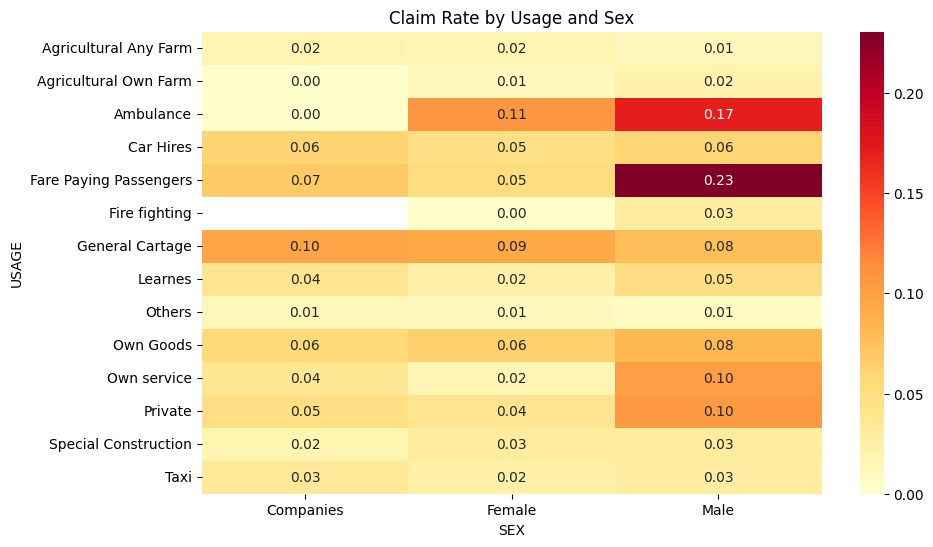

In [37]:
cross_usage_sex = df.groupby(["USAGE", "SEX"])["CLAIM_FLAG"].mean().unstack()

plt.figure(figsize=(10,6))
sns.heatmap(cross_usage_sex, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("Claim Rate by Usage and Sex")
plt.ylabel("USAGE")
plt.xlabel("SEX")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">


üìä ŸÖÿ¥ÿßŸáÿØŸá‚ÄåŸáÿß:  
- üöë **Ambulance**:  
  - ŸÖÿ±ÿØŸáÿß (Male) ‚Üí ÿ®ÿßŸÑÿßÿ™ÿ±€åŸÜ ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ (0.17)  
  - ÿ≤ŸÜÿßŸÜ (Female) ‚Üí ŸÜÿ≥ÿ®ÿ™ÿßŸã ÿ®ÿßŸÑÿß (0.11)  
  ‚Üí ÿ®Ÿá Ÿàÿ∂Ÿàÿ≠ ⁄Øÿ±ŸàŸá Ÿæÿ±ÿ±€åÿ≥⁄©.  

- üöå **Fare Paying Passengers (ŸÖÿ≥ÿßŸÅÿ±ÿ®ÿ±Ÿáÿß)**:  
  - ŸÖÿ±ÿØŸáÿß (Male) ‚Üí ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿØÿ± ⁄©ŸÑ ÿ¨ÿØŸàŸÑ (0.21)  
  - ÿ≥ÿß€åÿ± ⁄Øÿ±ŸàŸá‚ÄåŸáÿß ‚Üí ŸÜÿ±ÿÆ Ÿæÿß€å€åŸÜ‚Äåÿ™ÿ±  
  ‚Üí ŸÜÿ¥ÿßŸÜ‚ÄåÿØŸáŸÜÿØŸá Ÿæÿ±ÿÆÿ∑ÿ± ÿ®ŸàÿØŸÜ ÿ±ÿßŸÜŸÜÿØ⁄ØÿßŸÜ ŸÖÿ±ÿØ ÿØÿ± ÿß€åŸÜ ÿ®ÿÆÿ¥.  

- üöõ **General Cartage**:  
  - ŸáŸÖŸá ⁄Øÿ±ŸàŸá‚ÄåŸáÿß ŸÜÿ±ÿÆ ÿ®ÿßŸÑÿßÿ™ÿ± ÿßÿ≤ ŸÖÿ™Ÿàÿ≥ÿ∑ (0.08 ‚Äì 0.09)  
  ‚Üí ÿ±€åÿ≥⁄© €å⁄©ŸÜŸàÿßÿÆÿ™ ÿßŸÖÿß ŸÜÿ≥ÿ®ÿ™ÿßŸã ÿ≤€åÿßÿØ.  

- üöó **Private & Own Goods**:  
  - ŸÖÿ±ÿØŸáÿß ŸÜÿ±ÿÆ ÿ®ÿßŸÑÿßÿ™ÿ±€å ÿØÿßÿ±ŸÜ (0.10 Ÿà 0.08) ŸÜÿ≥ÿ®ÿ™ ÿ®Ÿá ÿ≤ŸÜÿßŸÜ Ÿà ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß  
  ‚Üí ÿ±ÿßŸÜŸÜÿØ⁄ØÿßŸÜ ŸÖÿ±ÿØ ÿØÿ± ÿß€åŸÜ ÿØÿ≥ÿ™Ÿá‚ÄåŸáÿß Ÿæÿ±ÿ±€åÿ≥⁄©‚Äåÿ™ÿ±ŸÜ.  

- üî• **Fire Fighting & Special Construction**:  
  - ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿÆ€åŸÑ€å Ÿæÿß€å€åŸÜ (0.00 ‚Äì 0.03)  
  ‚Üí ÿ±€åÿ≥⁄© ⁄©ŸÖ.  

- üöú **Agricultural (Any/Own Farm)**:  
  - ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿ≥€åÿßÿ± Ÿæÿß€å€åŸÜ (0.00 ‚Äì 0.02)  
  ‚Üí ÿ™ŸÇÿ±€åÿ®ÿßŸã ÿ®ÿØŸàŸÜ ÿ±€åÿ≥⁄©.  

---

### üìå ÿ¨ŸÖÿπ‚Äåÿ®ŸÜÿØ€å ⁄©ŸÑ€åÿØ€å:  
- üöë **Ambulance (ŸÖÿ±ÿØŸáÿß)** Ÿà üöå **Fare Paying Passengers (ŸÖÿ±ÿØŸáÿß)** ‚Üí Ÿæÿ±ÿ±€åÿ≥⁄©‚Äåÿ™ÿ±€åŸÜ ⁄Øÿ±ŸàŸá‚ÄåŸáÿß.  
- üöõ **General Cartage** ‚Üí ŸáŸÖŸàÿßÿ±Ÿá ÿ®ÿßŸÑÿßÿå ŸÖÿ≥ÿ™ŸÇŸÑ ÿßÿ≤ ÿ¨ŸÜÿ≥€åÿ™ ‚Üí ŸÜ€åÿßÿ≤ ÿ®Ÿá ⁄©ŸÜÿ™ÿ±ŸÑ Ÿà€å⁄òŸá.  
- üöó ÿ±ÿßŸÜŸÜÿØ⁄ØÿßŸÜ ŸÖÿ±ÿØ ÿØÿ± **Private Ÿà Own Goods** ‚Üí ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿßŸÑÿßÿ™ÿ± ÿßÿ≤ ÿ®ŸÇ€åŸá.  
- üöí ⁄Øÿ±ŸàŸá‚ÄåŸáÿß€å **Fire Fighting Ÿà Agricultural** ‚Üí ⁄©ŸÖ‚ÄåÿÆÿ∑ÿ±ÿ™ÿ±€åŸÜ ÿ®ÿÆÿ¥‚ÄåŸáÿß.  

</div>

---


üìä Observations:  
- üöë **Ambulances:**  
  - Male drivers ‚Üí very high claim rate (0.17)  
  - Female drivers ‚Üí also high (0.11).  
- üöå **Fare Paying Passengers:**  
  - Male drivers ‚Üí highest in dataset (0.21).  
- üöõ **General Cartage:**  
  - Consistently high across all categories (~0.08‚Äì0.09).  
- üöó **Private & Own Goods:**  
  - Male drivers riskier (0.10 and 0.08).  
- üî• **Fire Fighting & Agricultural vehicles:**  
  - Very low claim rates (<0.03).  

### üìå Key Takeaways:  
- üöë **Ambulance (Males)** and üöå **Passenger Vehicles (Males)** ‚Üí highest risk groups.  
- üöõ **General Cartage** ‚Üí consistently risky across all genders.  
- üöó Male drivers in **Private & Goods** ‚Üí significantly riskier.  
- üöí **Agricultural & Fire Fighting vehicles** ‚Üí lowest-risk categories.  


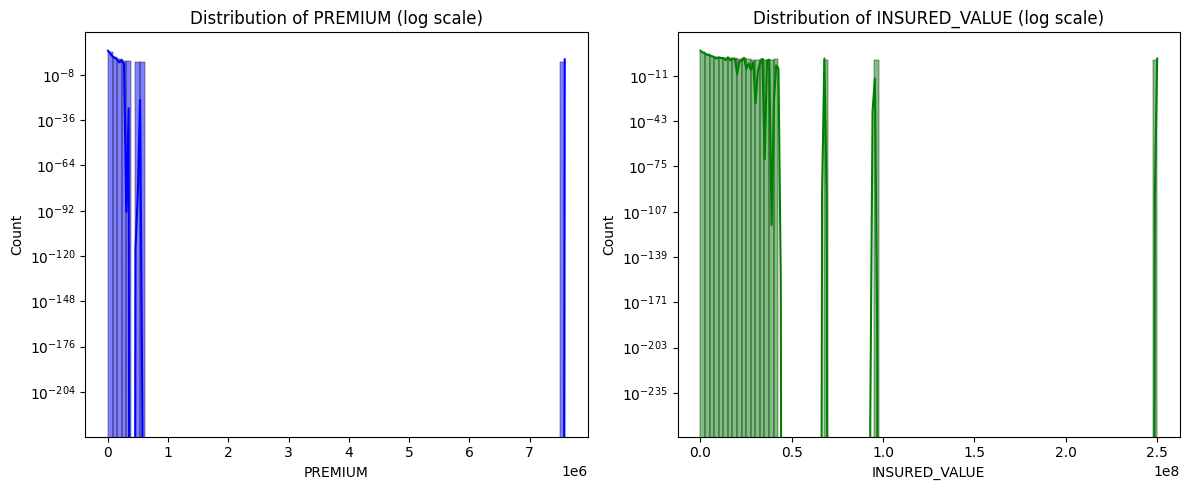

In [38]:
plt.figure(figsize=(12,5))

# PREMIUM
plt.subplot(1,2,1)
sns.histplot(df["PREMIUM"], bins=100, kde=True, color="blue")
plt.yscale("log")   # ŸÑÿß⁄Ø ÿ±Ÿà€å ŸÖÿ≠Ÿàÿ± y
plt.title("Distribution of PREMIUM (log scale)")

# INSURED_VALUE
plt.subplot(1,2,2)
sns.histplot(df["INSURED_VALUE"], bins=100, kde=True, color="green")
plt.yscale("log")
plt.title("Distribution of INSURED_VALUE (log scale)")

plt.tight_layout()
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



### üìä ŸÜŸÖŸàÿØÿßÿ± ÿ≥ŸÖÿ™ ⁄ÜŸæ ‚Üí Distribution of PREMIUM (log scale)  
- Ÿæÿ±ÿß⁄©ŸÜÿØ⁄Ø€å ÿ¥ÿØ€åÿØ ŸÖÿ¥ÿßŸáÿØŸá ŸÖ€å‚Äåÿ¥Ÿá.  
- ÿß⁄©ÿ´ÿ±€åÿ™ ÿØÿßÿØŸá‚ÄåŸáÿß ÿØÿ± ŸÖŸÇÿßÿØ€åÿ± ÿÆ€åŸÑ€å Ÿæÿß€å€åŸÜ ŸÖÿ™ŸÖÿ±⁄©ÿ≤ Ÿáÿ≥ÿ™ŸÜ.  
- ⁄ÜŸÜÿØ ŸÖŸÇÿØÿßÿ± ÿ®ÿ≥€åÿßÿ± ÿ®ÿ≤ÿ±⁄Ø (Outliers) ŸáŸÖ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ŸÜ ⁄©Ÿá ÿ®ÿßÿπÿ´ ⁄©ÿ¥€åÿØ⁄Ø€å ÿ¥ÿØ€åÿØ ÿ™Ÿàÿ≤€åÿπ ÿ¥ÿØŸÜ.  
- ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ **ŸÖŸÇ€åÿßÿ≥ ŸÑ⁄Øÿßÿ±€åÿ™ŸÖ€å** ÿ®Ÿá Ÿàÿ∂Ÿàÿ≠ ŸÜÿ¥ŸàŸÜ ŸÖ€å‚ÄåÿØŸá ⁄©Ÿá ÿØÿßÿØŸá‚ÄåŸáÿß Heavy-Tailed Ÿáÿ≥ÿ™ŸÜ.  

### üìä ŸÜŸÖŸàÿØÿßÿ± ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ‚Üí Distribution of INSURED_VALUE (log scale)  
- ŸÖÿ¥ÿßÿ®Ÿá Premiumÿå ÿ®€åÿ¥ÿ™ÿ± ÿØÿßÿØŸá‚ÄåŸáÿß ÿØÿ± ÿ®ÿßÿ≤Ÿá‚ÄåŸáÿß€å ÿÆ€åŸÑ€å ⁄©Ÿà⁄Ü⁄© ŸÇÿ±ÿßÿ± ⁄Øÿ±ŸÅÿ™ŸÜ.  
- ⁄ÜŸÜÿØ ŸÖŸÇÿØÿßÿ± ÿÆ€åŸÑ€å ÿ®ÿ≤ÿ±⁄Ø (ÿ≠ÿ™€å ÿ®ÿßŸÑÿß€å `2.5e8`) Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá ⁄©Ÿá ÿ®Ÿá Ÿàÿ∂Ÿàÿ≠ Outlier Ÿáÿ≥ÿ™ŸÜ.  
- ÿß€åŸÜ ŸÜÿ¥ŸàŸÜ ŸÖ€å‚ÄåÿØŸá ⁄©Ÿá **ÿßÿ±ÿ≤ÿ¥ ÿ®€åŸÖŸá‚Äåÿß€å ÿÆŸàÿØÿ±ŸàŸáÿß (Insured Value)** ÿ™Ÿà€å ÿØ€åÿ™ÿßÿ≥ÿ™ ÿ®ÿ≥€åÿßÿ± ŸÜÿßŸáŸÖ⁄ØŸÜ Ÿáÿ≥ÿ™.  

---

### üìå ÿ¨ŸÖÿπ‚Äåÿ®ŸÜÿØ€å :  
- ŸáŸÖ ÿØÿ± Premium Ÿà ŸáŸÖ ÿØÿ± Insured Valueÿå **ÿ®€åÿ¥ÿ™ÿ± ÿØÿßÿØŸá‚ÄåŸáÿß ÿØÿ± ÿ®ÿßÿ≤Ÿá‚ÄåŸáÿß€å Ÿæÿß€å€åŸÜ ŸÅÿ¥ÿ±ÿØŸá ÿ¥ÿØŸÜ**.  
- **Outliers ÿ®ÿ≥€åÿßÿ± ÿ®ÿ≤ÿ±⁄Ø** Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá ⁄©Ÿá ÿ≠ÿ™ŸÖÿßŸã ÿ®ÿß€åÿØ ŸÇÿ®ŸÑ ÿßÿ≤ ŸÖÿØŸÑ‚Äåÿ≥ÿßÿ≤€å ÿ®ÿ±ÿ±ÿ≥€å Ÿà ŸÖÿØ€åÿ±€åÿ™ ÿ®ÿ¥ŸÜ.  
- ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ **ŸÖŸÇ€åÿßÿ≥ ŸÑ⁄Øÿßÿ±€åÿ™ŸÖ€å** ⁄©ŸÖ⁄© ⁄©ÿ±ÿØŸá ⁄©Ÿá ÿß€åŸÜ ÿπÿØŸÖ‚Äåÿ™Ÿàÿßÿ≤ŸÜ ÿ®Ÿáÿ™ÿ± ÿØ€åÿØŸá ÿ®ÿ¥Ÿá.  

</div>


---



### üìä Left Plot ‚Üí Distribution of PREMIUM (log scale)  
- Highly skewed distribution.  
- Majority of values are concentrated at the low end.  
- Presence of **extreme outliers** (millions range) stretching the scale.  
- Log scale reveals the **heavy-tailed nature** of the data.  

### üìä Right Plot ‚Üí Distribution of INSURED_VALUE (log scale)  
- Similar behavior as PREMIUM.  
- Most values clustered near the bottom, with **some extremely high insured values (> 2.5e8)**.  
- Shows strong **heterogeneity in insured vehicle values**.  

---

### üìå Key Takeaway:  
- Both **Premium** and **Insured Value** show **highly skewed distributions** with many **outliers**.  
- Handling these outliers will be crucial before training predictive models (e.g., applying log-transform, winsorization, or robust scaling).  


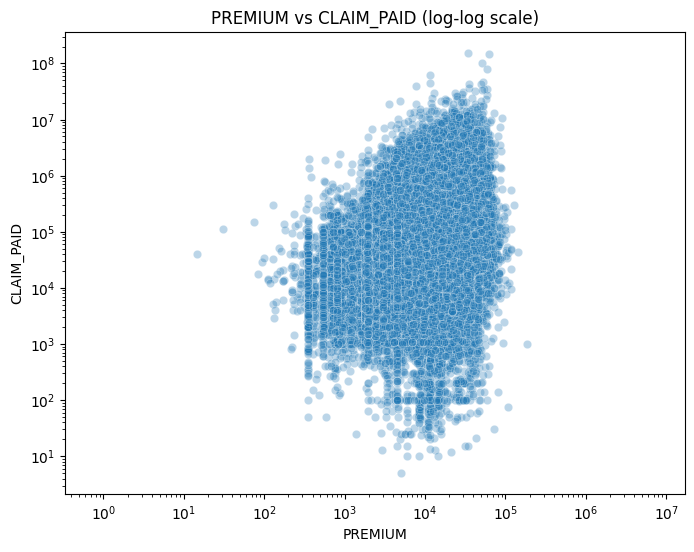

In [39]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="PREMIUM", y="CLAIM_PAID", data=df, alpha=0.3)
plt.xscale("log")
plt.yscale("log")
plt.title("PREMIUM vs CLAIM_PAID (log-log scale)")
plt.xlabel("PREMIUM")
plt.ylabel("CLAIM_PAID")
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



### üìä ŸÜŸÖŸàÿØÿßÿ± ‚Üí PREMIUM vs CLAIM_PAID (log-log scale)  
- ÿß€åŸÜ ŸÜŸÖŸàÿØÿßÿ± ÿ±ÿßÿ®ÿ∑Ÿá ÿ®€åŸÜ **ŸÖÿ®ŸÑÿ∫ ÿ≠ŸÇ ÿ®€åŸÖŸá (Premium)** Ÿà **ŸÖÿ®ŸÑÿ∫ Ÿæÿ±ÿØÿßÿÆÿ™€å ÿÆÿ≥ÿßÿ±ÿ™ (Claim Paid)** ÿ±Ÿà ŸÜÿ¥ŸàŸÜ ŸÖ€å‚ÄåÿØŸá.  
- ⁄ÜŸàŸÜ Ÿáÿ± ÿØŸà ŸÖÿ™ÿ∫€åÿ± ÿØÿßÿ±ÿß€å **Ÿæÿ±ÿß⁄©ŸÜÿØ⁄Ø€å ÿ¥ÿØ€åÿØ Ÿà Outlier** ÿ®ŸàÿØŸÜÿå ÿßÿ≤ **ŸÖŸÇ€åÿßÿ≥ ŸÑ⁄Øÿßÿ±€åÿ™ŸÖ€å ÿØŸàÿ∑ÿ±ŸÅŸá (log-log)** ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿ¥ÿØŸá.  
- ÿßŸÑ⁄ØŸà€å ⁄©ŸÑ€å ŸÜÿ¥ŸàŸÜ ŸÖ€å‚ÄåÿØŸá ⁄©Ÿá ÿ®ÿß ÿßŸÅÿ≤ÿß€åÿ¥ Premiumÿå ŸÖŸÇÿßÿØ€åÿ± Claim Paid ŸáŸÖ **ÿßŸÅÿ≤ÿß€åÿ¥ ŸÜÿ≥ÿ®€å** Ÿæ€åÿØÿß ŸÖ€å‚Äå⁄©ŸÜŸá.  
- ÿßŸÖÿß ÿØÿßÿØŸá‚ÄåŸáÿß Ÿæÿ±ÿß⁄©ŸÜÿØ⁄Ø€å ÿ≤€åÿßÿØ€å ÿØÿßÿ±ŸÜ ‚Üí €åÿπŸÜ€å ŸáŸÖÿ®ÿ≥ÿ™⁄Ø€å ÿÆÿ∑€å ÿ≥ÿßÿØŸá ÿÆ€åŸÑ€å ŸÇŸà€å ŸÜ€åÿ≥ÿ™.  
- ÿÆŸàÿ¥Ÿá‚Äåÿ®ŸÜÿØ€å (Clustering) ŸÇÿßÿ®ŸÑ ŸÖÿ¥ÿßŸáÿØŸá ÿßÿ≥ÿ™ ‚Üí ŸÖÿ´ŸÑÿßŸã ÿ™ÿπÿØÿßÿØ ÿ≤€åÿßÿØ€å ÿßÿ≤ ÿØÿßÿØŸá‚ÄåŸáÿß ÿØÿ± ŸÖÿ≠ÿØŸàÿØŸá‚ÄåŸáÿß€å ÿÆÿßÿµ Premium Ÿà Claim Paid ŸÖÿ™ŸÖÿ±⁄©ÿ≤ ÿ¥ÿØŸÜ.  
- Ÿàÿ¨ŸàÿØ ⁄ÜŸÜÿØ ŸÜŸÇÿ∑Ÿá ÿÆ€åŸÑ€å ÿØŸàÿ± (Extreme Outliers) ŸáŸÖ ÿ®Ÿá Ÿàÿ∂Ÿàÿ≠ ŸÖÿ¥ÿÆÿµŸá.  

---

### üìå ÿ¨ŸÖÿπ‚Äåÿ®ŸÜÿØ€å :  
- ÿ±ÿßÿ®ÿ∑Ÿá ŸÖÿ´ÿ®ÿ™ ÿ®€åŸÜ Premium Ÿà Claim Paid Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿáÿå ŸàŸÑ€å ÿÆ€åŸÑ€å **Ÿæÿ±ÿß⁄©ŸÜÿØŸá Ÿà Ÿæÿ±ŸÜŸà€åÿ≤** Ÿáÿ≥ÿ™.  
- ÿßÿ≠ÿ™ŸÖÿßŸÑÿßŸã ŸÖÿØŸÑ‚ÄåŸáÿß€å ÿÆÿ∑€å ÿ≥ÿßÿØŸá ÿÆŸàÿ® ÿ¨Ÿàÿßÿ® ŸÜŸÖ€å‚ÄåÿØŸÜ ‚Üí ŸÜ€åÿßÿ≤ ÿ®Ÿá **ŸÖÿØŸÑ‚ÄåŸáÿß€å ŸÖŸÇÿßŸàŸÖ ÿØÿ± ÿ®ÿ±ÿßÿ®ÿ± Ÿæÿ±ÿß⁄©ŸÜÿØ⁄Ø€å ÿ®ÿßŸÑÿß** €åÿß **ŸÖÿØŸÑ‚ÄåŸáÿß€å ÿ∫€åÿ±ÿÆÿ∑€å** ŸÖÿ´ŸÑ Random Forest €åÿß Gradient Boosting Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá.  
- ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿ≠ÿ∞ŸÅ €åÿß ŸÖÿØ€åÿ±€åÿ™ OutlierŸáÿß ÿ∂ÿ±Ÿàÿ±€åŸá.  

</div>

---



### üìä Plot ‚Üí PREMIUM vs CLAIM_PAID (log-log scale)  
- Shows the relationship between **Premium amount** and **Claim Paid**.  
- Both variables are **heavily skewed**, hence the **log-log scale**.  
- General upward trend: higher Premiums tend to be associated with higher Claim Paid.  
- However, the data is **highly scattered**, indicating that correlation is not very strong.  
- Clear clustering is visible in certain ranges of Premium and Claim Paid.  
- Presence of **extreme outliers** is very evident.  

---

### üìå Key Takeaways:  
- Positive relationship exists, but it is **noisy and weakly linear**.  
- Simple linear regression may not perform well ‚Üí better to use **robust or nonlinear models**.  
- Outlier treatment will be a critical preprocessing step.  


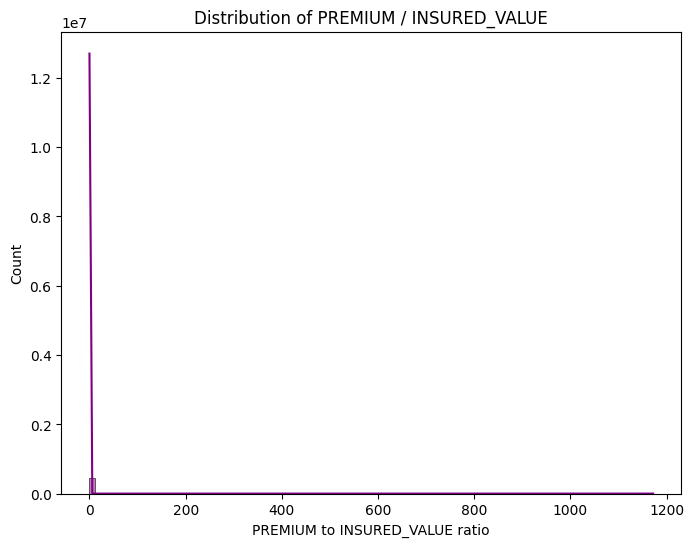

In [40]:
df["PREM_RATIO"] = df["PREMIUM"] / df["INSURED_VALUE"]

plt.figure(figsize=(8,6))
sns.histplot(df["PREM_RATIO"], bins=100, kde=True, color="purple")
plt.title("Distribution of PREMIUM / INSURED_VALUE")
plt.xlabel("PREMIUM to INSURED_VALUE ratio")
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



### üìä ŸÜŸÖŸàÿØÿßÿ± ‚Üí Distribution of PREMIUM / INSURED_VALUE ratio  
- ÿß€åŸÜ ŸÜŸÖŸàÿØÿßÿ± ŸÜÿ¥ŸàŸÜ ŸÖ€å‚ÄåÿØŸá ⁄©Ÿá **ÿ≠ŸÇ ÿ®€åŸÖŸá ŸÜÿ≥ÿ®ÿ™ ÿ®Ÿá ÿßÿ±ÿ≤ÿ¥ ÿ®€åŸÖŸá‚Äåÿ¥ÿØŸá** ŸÖÿπŸÖŸàŸÑÿßŸã ÿØÿ± ŸÖÿ≠ÿØŸàÿØŸá‚ÄåŸáÿß€å ÿÆ€åŸÑ€å Ÿæÿß€å€åŸÜ ŸÖÿ™ŸÖÿ±⁄©ÿ≤Ÿá.  
- ÿ®ÿÆÿ¥ ÿ®ÿ≤ÿ±⁄Ø€å ÿßÿ≤ ÿØÿßÿØŸá‚ÄåŸáÿß ÿØÿ± ŸÖÿ≠ÿØŸàÿØŸá ŸÜÿ≤ÿØ€å⁄© ÿ®Ÿá ÿµŸÅÿ± Ÿáÿ≥ÿ™ŸÜ ‚Üí €åÿπŸÜ€å ÿØÿ± ÿ®€åÿ¥ÿ™ÿ± ŸÇÿ±ÿßÿ±ÿØÿßÿØŸáÿßÿå ÿ≠ŸÇ ÿ®€åŸÖŸá ÿ®ÿÆÿ¥ ÿÆ€åŸÑ€å ⁄©Ÿà⁄Ü€å⁄©€å ÿßÿ≤ ÿßÿ±ÿ≤ÿ¥ ÿ®€åŸÖŸá‚Äåÿ¥ÿØŸá ÿßÿ≥ÿ™.  
- ÿ®ÿß ÿß€åŸÜ ÿ≠ÿßŸÑÿå ŸÖŸÇÿßÿØ€åÿ± ÿÆ€åŸÑ€å ÿ®ÿ≤ÿ±⁄Ø€å ŸáŸÖ ÿØ€åÿØŸá ŸÖ€å‚Äåÿ¥ŸÜ (Tail ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ŸÜŸÖŸàÿØÿßÿ±)ÿå ⁄©Ÿá ŸÜÿ¥ŸàŸÜ ŸÖ€å‚ÄåÿØŸá ÿ®ÿπÿ∂€å ÿßÿ≤ ÿ®€åŸÖŸá‚Äå⁄Øÿ∞ÿßÿ±ÿßŸÜ ÿ≠ŸÇ ÿ®€åŸÖŸá ÿ®ÿ≥€åÿßÿ± ÿ®ÿßŸÑÿß€å€å ŸÜÿ≥ÿ®ÿ™ ÿ®Ÿá ÿßÿ±ÿ≤ÿ¥ ÿ®€åŸÖŸá‚Äåÿ¥ÿØŸá Ÿæÿ±ÿØÿßÿÆÿ™ ŸÖ€å‚Äå⁄©ŸÜŸÜ.  
- ÿß€åŸÜ ŸÖŸàÿßÿ±ÿØ ÿßÿ≠ÿ™ŸÖÿßŸÑÿßŸã Outlier Ÿáÿ≥ÿ™ŸÜ Ÿà €åÿß ŸÜÿßÿ¥€å ÿßÿ≤ ŸÇÿ±ÿßÿ±ÿØÿßÿØŸáÿß€å ÿÆÿßÿµ (ŸÖÿ´ŸÑÿßŸã ÿ±€åÿ≥⁄© ÿ®ÿßŸÑÿß €åÿß ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿ∫€åÿ±ŸÖÿπŸÖŸàŸÑ).  

---

### üìå ÿ¨ŸÖÿπ‚Äåÿ®ŸÜÿØ€å :  
- ŸÜÿ≥ÿ®ÿ™ Premium/Insured Value ÿØÿ± ÿ≠ÿßŸÑÿ™ ÿπÿßÿØ€å ÿ®ÿß€åÿØ ⁄©ŸÖ ÿ®ÿßÿ¥Ÿáÿå Ÿà ŸáŸÖ€åŸÜÿ∑Ÿàÿ± ŸáŸÖ ÿØ€åÿØŸá ŸÖ€å‚Äåÿ¥Ÿá.  
- Ÿàÿ¨ŸàÿØ ŸÜŸÇÿßÿ∑ ÿ®ÿ≥€åÿßÿ± ÿ®ÿ≤ÿ±⁄Ø ŸÖ€å‚Äåÿ™ŸàŸÜŸá ŸÜÿ¥ÿßŸÜ‚ÄåÿØŸáŸÜÿØŸá **ÿπÿØŸÖ ÿ™ŸÜÿßÿ≥ÿ® ÿ®€åŸÜ ÿ±€åÿ≥⁄© Ÿà ÿßÿ±ÿ≤ÿ¥ ÿ®€åŸÖŸá‚Äåÿ¥ÿØŸá** ÿ®ÿßÿ¥Ÿá.  
- Ÿæ€åÿ¥ŸÜŸáÿßÿØ ŸÖ€å‚Äåÿ¥Ÿá ÿ®ÿ±ÿ±ÿ≥€å ÿ®ÿ¥Ÿá ⁄©Ÿá ÿ¢€åÿß ÿß€åŸÜ ŸÖŸÇÿßÿØ€åÿ± ŸÜÿßÿ¥€å ÿßÿ≤ ÿÆÿ∑ÿßŸáÿß€å ÿØÿßÿØŸá‚Äåÿß€å Ÿáÿ≥ÿ™ŸÜ €åÿß ŸÇÿ±ÿßÿ±ÿØÿßÿØŸáÿß€å ÿÆÿßÿµ.  

</div>

---

 

### üìä Plot ‚Üí Distribution of PREMIUM / INSURED_VALUE ratio  
- The distribution shows that **most policies have a very small Premium compared to Insured Value**.  
- A heavy concentration is observed near zero.  
- However, there are extreme right-tail values ‚Üí indicating some cases where Premium is disproportionately high relative to Insured Value.  
- These could be **outliers** or **special cases** (e.g., high-risk policies, data entry issues, or premium mispricing).  

---

### üìå Key Takeaways:  
- The ratio is normally low, but the extreme outliers need investigation.  
- Important for risk assessment and premium adequacy checks.  


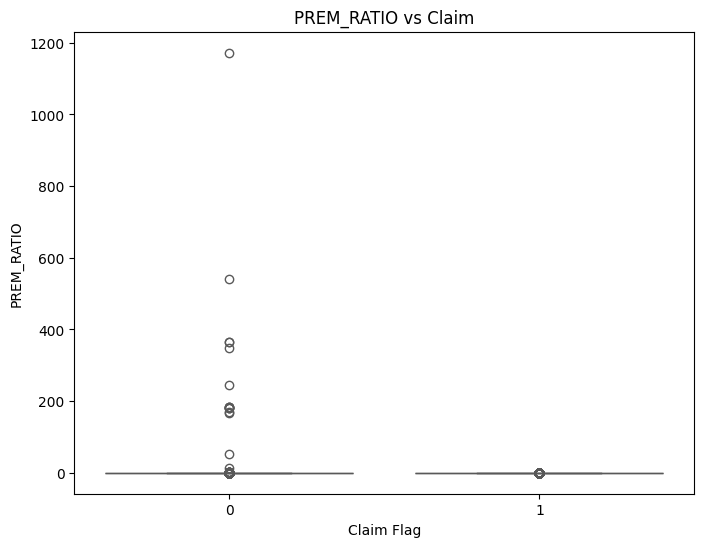

In [41]:
plt.figure(figsize=(8,6))
sns.boxplot(x="CLAIM_FLAG", y="PREM_RATIO", data=df, palette="Set2")
plt.title("PREM_RATIO vs Claim")
plt.xlabel("Claim Flag")
plt.ylabel("PREM_RATIO")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



### üìä ŸÜŸÖŸàÿØÿßÿ± ‚Üí PREM_RATIO vs Claim  
- ŸÖÿ≠Ÿàÿ± ÿßŸÅŸÇ€å:  
  - **0 = ÿ®ÿØŸàŸÜ ÿÆÿ≥ÿßÿ±ÿ™**  
  - **1 = ÿ®ÿß ÿÆÿ≥ÿßÿ±ÿ™**  

- ŸÖÿ≠Ÿàÿ± ÿπŸÖŸàÿØ€å: **PREM_RATIO** (ŸÜÿ≥ÿ®ÿ™ ÿ≠ŸÇ ÿ®€åŸÖŸá ÿ®Ÿá ÿßÿ±ÿ≤ÿ¥ ÿ®€åŸÖŸá‚Äåÿ¥ÿØŸá).  

### üîé ŸÖÿ¥ÿßŸáÿØÿßÿ™:  
1. ÿØÿ± Ÿáÿ± ÿØŸà ⁄Øÿ±ŸàŸá (ÿ®ÿß ÿÆÿ≥ÿßÿ±ÿ™ Ÿà ÿ®ÿØŸàŸÜ ÿÆÿ≥ÿßÿ±ÿ™)ÿå ŸÖŸÇÿØÿßÿ± PREM_RATIO ÿØÿ± ÿ®€åÿ¥ÿ™ÿ± ŸÖŸàÿßÿ±ÿØ ÿ®ÿ≥€åÿßÿ± ⁄©Ÿà⁄Ü⁄© ÿßÿ≥ÿ™.  
2. ÿ™ÿπÿØÿßÿØ€å Outlier ÿÆ€åŸÑ€å ÿ®ÿ≤ÿ±⁄Ø ÿØÿ± ⁄Øÿ±ŸàŸá **ÿ®ÿØŸàŸÜ ÿÆÿ≥ÿßÿ±ÿ™ (0)** Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá ‚Üí €åÿπŸÜ€å ÿ®ÿπÿ∂€å ÿßÿ≤ ÿ®€åŸÖŸá‚Äå⁄Øÿ∞ÿßÿ±ÿßŸÜ ÿ≠ŸÇ ÿ®€åŸÖŸá ÿÆ€åŸÑ€å ÿ≤€åÿßÿØ€å Ÿæÿ±ÿØÿßÿÆÿ™ ⁄©ÿ±ÿØŸÜÿå ŸàŸÑ€å ÿÆÿ≥ÿßÿ±ÿ™€å ÿ´ÿ®ÿ™ ŸÜÿ¥ÿØŸá.  
3. ÿØÿ± ⁄Øÿ±ŸàŸá **ÿ®ÿß ÿÆÿ≥ÿßÿ±ÿ™ (1)** Ÿæÿ±ÿß⁄©ŸÜÿØ⁄Ø€å ⁄©ŸÖÿ™ÿ±Ÿá Ÿà Outlier ÿÆ€åŸÑ€å ÿ≤€åÿßÿØ€å ÿØ€åÿØŸá ŸÜŸÖ€å‚Äåÿ¥Ÿá.  

---

### üìå ŸÜÿ™€åÿ¨Ÿá‚Äå⁄Ø€åÿ±€å :  
- ÿ®Ÿá‚Äåÿ∑Ÿàÿ± ⁄©ŸÑ€åÿå ŸÜÿ≥ÿ®ÿ™ ÿ≠ŸÇ ÿ®€åŸÖŸá ÿ®Ÿá ÿßÿ±ÿ≤ÿ¥ ÿ®€åŸÖŸá‚Äåÿ¥ÿØŸá ÿ™ÿ£ÿ´€åÿ± ÿ≤€åÿßÿØ€å ÿ±Ÿà€å ŸàŸÇŸàÿπ ÿÆÿ≥ÿßÿ±ÿ™ ŸÜÿ¥ŸàŸÜ ŸÜŸÖ€å‚ÄåÿØŸá.  
- ÿ®ÿß ÿß€åŸÜ ÿ≠ÿßŸÑÿå Outlier Ÿáÿß€å ÿ®ÿ≤ÿ±⁄Ø ÿØÿ± ⁄Øÿ±ŸàŸá ÿ®ÿØŸàŸÜ ÿÆÿ≥ÿßÿ±ÿ™ ŸÖ€å‚Äåÿ™ŸàŸÜŸÜ ŸÜÿ¥ŸàŸÜŸá‚Äå€å **ŸÖÿ≠ÿßÿ≥ÿ®Ÿá‚Äå€å ŸÜÿßŸÖÿ™ŸÜÿßÿ≥ÿ® ÿ≠ŸÇ ÿ®€åŸÖŸá** €åÿß **ÿ±€åÿ≥⁄©‚ÄåŸáÿß€å€å ÿ®ÿßÿ¥ŸÜ ⁄©Ÿá ÿ®ÿ±ÿÆŸÑÿßŸÅ ÿßŸÜÿ™ÿ∏ÿßÿ± ÿÆÿ≥ÿßÿ±ÿ™ ÿß€åÿ¨ÿßÿØ ŸÜ⁄©ÿ±ÿØŸÜ**.  
- ÿ®ÿ±ÿ±ÿ≥€å ÿß€åŸÜ OutlierŸáÿß ŸÖ€å‚Äåÿ™ŸàŸÜŸá ÿ®ÿ±ÿß€å ⁄©ÿ¥ŸÅ ÿßŸÑ⁄ØŸàŸáÿß€å ŸÇ€åŸÖÿ™€å €åÿß ŸÖÿ¥⁄©ŸÑÿßÿ™ ÿØÿßÿØŸá‚Äåÿß€å ÿÆ€åŸÑ€å ŸÖŸÅ€åÿØ ÿ®ÿßÿ¥Ÿá.  

</div>

---



### üìä Plot ‚Üí PREM_RATIO vs Claim  
- X-axis: Claim Flag (0 = No claim, 1 = Claim).  
- Y-axis: Premium-to-Insured-Value Ratio.  

### üîé Observations:  
1. For both groups, the ratio is usually very small.  
2. There are **extreme outliers in the "No Claim" group (0)**, showing some policies had very high premiums compared to insured value but no claims were filed.  
3. The "Claim" group (1) shows less extreme variation.  

---

### üìå Key Insights:  
- Premium-to-Insured-Value ratio does not strongly separate claim vs no-claim groups.  
- High outliers without claims might indicate **overpriced policies, mispricing, or very risk-averse customers**.  
- Worth investigating those outliers separately.  


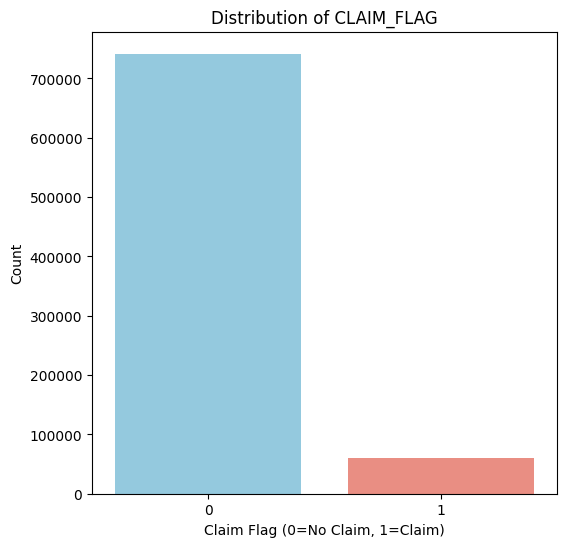

Claim Rate: 7.50%


In [42]:
plt.figure(figsize=(6,6))
sns.countplot(x="CLAIM_FLAG", data=df, palette=["skyblue","salmon"])
plt.title("Distribution of CLAIM_FLAG")
plt.xlabel("Claim Flag (0=No Claim, 1=Claim)")
plt.ylabel("Count")
plt.show()

# ÿØÿ±ÿµÿØ ÿÆÿ≥ÿßÿ±ÿ™
claim_rate = df["CLAIM_FLAG"].mean() * 100
print(f"Claim Rate: {claim_rate:.2f}%")


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

 

### üìä ŸÜŸÖŸàÿØÿßÿ± ‚Üí ÿ™Ÿàÿ≤€åÿπ CLAIM_FLAG  
- ŸÖÿ≠Ÿàÿ± ÿßŸÅŸÇ€å:  
  - **0 = ÿ®ÿØŸàŸÜ ÿÆÿ≥ÿßÿ±ÿ™**  
  - **1 = ÿ®ÿß ÿÆÿ≥ÿßÿ±ÿ™**  

- ŸÖÿ≠Ÿàÿ± ÿπŸÖŸàÿØ€å: **ÿ™ÿπÿØÿßÿØ ÿ®€åŸÖŸá‚ÄåŸÜÿßŸÖŸá‚ÄåŸáÿß**  

### üîé ŸÖÿ¥ÿßŸáÿØÿßÿ™:  
1. ÿß⁄©ÿ´ÿ±€åÿ™ ÿ®€åŸÖŸá‚ÄåŸÜÿßŸÖŸá‚ÄåŸáÿß (ÿ≠ÿØŸàÿØ **€∑€µ€∞ Ÿáÿ≤ÿßÿ±**) ÿ®ÿØŸàŸÜ ÿÆÿ≥ÿßÿ±ÿ™ Ÿáÿ≥ÿ™ŸÜ.  
2. ÿ™ÿπÿØÿßÿØ ÿ®€åŸÖŸá‚ÄåŸÜÿßŸÖŸá‚ÄåŸáÿß€å ÿØÿßÿ±ÿß€å ÿÆÿ≥ÿßÿ±ÿ™ ÿÆ€åŸÑ€å ⁄©ŸÖÿ™ÿ±Ÿá (ÿ≠ÿØŸàÿØ **€∂€∞‚Äì€∑€∞ Ÿáÿ≤ÿßÿ±**).  
3. ÿß€åŸÜ €åÿπŸÜ€å ÿØÿßÿØŸá‚ÄåŸáÿß **ÿ®Ÿá‚Äåÿ¥ÿØÿ™ ŸÜÿßŸÖÿ™Ÿàÿßÿ≤ŸÜ (imbalanced)** Ÿáÿ≥ÿ™ŸÜ.  

---

### üìå ŸÜÿ™€åÿ¨Ÿá‚Äå⁄Ø€åÿ±€å :  
- ⁄ÜŸàŸÜ ÿØÿßÿØŸá‚ÄåŸáÿß ŸÜÿßŸÖÿ™Ÿàÿßÿ≤ŸÜ Ÿáÿ≥ÿ™ŸÜÿå Ÿáÿ± ŸÖÿØŸÑ€å ÿ®ÿ±ÿß€å Ÿæ€åÿ¥‚Äåÿ®€åŸÜ€å ÿÆÿ≥ÿßÿ±ÿ™ (Claim Prediction) ÿ®ÿß€åÿØ ÿ®ÿß ÿØŸÇÿ™ ÿ®€åÿ¥ÿ™ÿ±€å ÿ∑ÿ±ÿßÿ≠€å ÿ®ÿ¥Ÿá.  
- ÿß⁄Øÿ± ŸÖÿ≥ÿ™ŸÇ€åŸÖÿßŸã ÿ±Ÿà€å ÿß€åŸÜ ÿØÿßÿØŸá‚ÄåŸáÿß ŸÖÿØŸÑ‚Äåÿ≥ÿßÿ≤€å ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿ¥Ÿáÿå ŸÖÿØŸÑ ÿßÿ≠ÿ™ŸÖÿßŸÑÿßŸã ÿ®€åÿ¥ÿ™ÿ± ŸÖŸàÿßŸÇÿπ "ÿ®ÿØŸàŸÜ ÿÆÿ≥ÿßÿ±ÿ™" (0) ÿ±Ÿà Ÿæ€åÿ¥‚Äåÿ®€åŸÜ€å ŸÖ€å‚Äå⁄©ŸÜŸá Ÿà ÿØŸÇÿ™ ÿ∏ÿßŸáÿ±€å ÿ®ÿßŸÑÿß€å€å ÿÆŸàÿßŸáÿØ ÿØÿßÿ¥ÿ™ÿå ÿßŸÖÿß ÿØÿ± ÿ¥ŸÜÿßÿ≥ÿß€å€å ÿÆÿ≥ÿßÿ±ÿ™ ŸàÿßŸÇÿπ€å (1) ÿ∂ÿπ€åŸÅ ÿÆŸàÿßŸáÿØ ÿ®ŸàÿØ.  
- ÿ®ÿ±ÿß€å ŸÖŸÇÿßÿ®ŸÑŸá ÿ®ÿß ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ŸÖ€å‚Äåÿ¥Ÿá ÿßÿ≤ ÿ±Ÿàÿ¥‚ÄåŸáÿß€å ÿ≤€åÿ± ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØ:  
  1. **Oversampling** (ŸÖÿ´ŸÑ SMOTE) ÿ®ÿ±ÿß€å ÿßŸÅÿ≤ÿß€åÿ¥ ŸÜŸÖŸàŸÜŸá‚ÄåŸáÿß€å ⁄©ŸÑÿßÿ≥ 1.  
  2. **Undersampling** ÿ®ÿ±ÿß€å ⁄©ÿßŸáÿ¥ ŸÜŸÖŸàŸÜŸá‚ÄåŸáÿß€å ⁄©ŸÑÿßÿ≥ 0.  
  3. **ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ Ÿàÿ≤ŸÜ‚ÄåÿØŸá€å (Class Weights)** ÿØÿ± ÿßŸÑ⁄ØŸàÿ±€åÿ™ŸÖ‚ÄåŸáÿß€å €åÿßÿØ⁄Ø€åÿ±€å.  

</div>

---

  

### üìä Chart ‚Üí Distribution of CLAIM_FLAG  
- X-axis: Claim Flag (0 = No claim, 1 = Claim).  
- Y-axis: Count of policies.  

### üîé Observations:  
1. Most policies (**~750k**) have no claims.  
2. Only about **60‚Äì70k** policies have claims.  
3. The dataset is **highly imbalanced**.  

---

### üìå Key Insights:  
- Imbalance means models may **bias towards "No Claim"** predictions.  
- Need techniques like **SMOTE, undersampling, or class weights** to improve claim detection performance.  


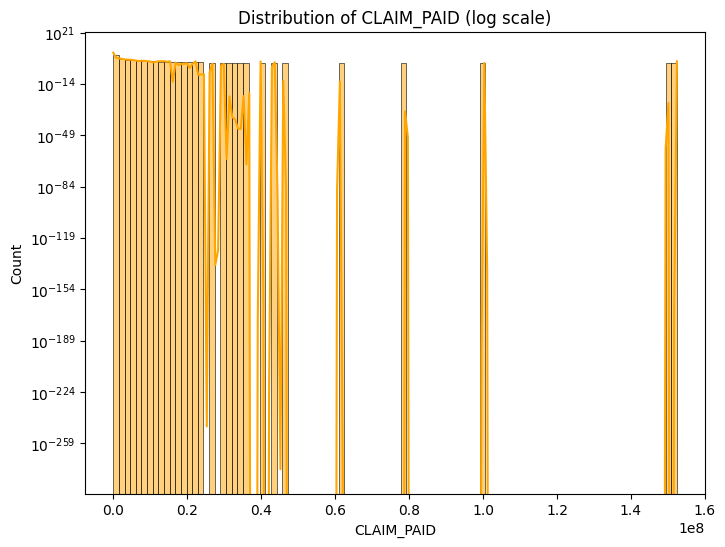

In [43]:
plt.figure(figsize=(8,6))
sns.histplot(df["CLAIM_PAID"], bins=100, kde=True, color="orange")
plt.yscale("log")  # ⁄ÜŸàŸÜ outlier ÿ≤€åÿßÿØŸá
plt.title("Distribution of CLAIM_PAID (log scale)")
plt.xlabel("CLAIM_PAID")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



### üìä ŸÜŸÖŸàÿØÿßÿ± ‚Üí Distribution of CLAIM_PAID (log scale)  
- ŸÖÿ≠Ÿàÿ± ÿßŸÅŸÇ€å: **CLAIM_PAID** (ŸÖÿ®ŸÑÿ∫ ÿÆÿ≥ÿßÿ±ÿ™ Ÿæÿ±ÿØÿßÿÆÿ™€å).  
- ŸÖÿ≠Ÿàÿ± ÿπŸÖŸàÿØ€å: **ÿ™ÿπÿØÿßÿØ (Count)** ÿØÿ± ŸÖŸÇ€åÿßÿ≥ ŸÑ⁄Øÿßÿ±€åÿ™ŸÖ€å.  

### üîé ŸÖÿ¥ÿßŸáÿØÿßÿ™:  
1. ÿØÿßÿØŸá‚ÄåŸáÿß ÿ®Ÿá‚Äåÿ¥ÿØÿ™ **⁄ÜŸàŸÑ⁄Ø€å ÿ®Ÿá ÿ±ÿßÿ≥ÿ™ (Right-skewed)** ÿØÿßÿ±ŸÜ.  
   - ÿß⁄©ÿ´ÿ± ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß ÿØÿ± ŸÖÿ®ÿßŸÑÿ∫ Ÿæÿß€å€åŸÜ ŸÖÿ™ŸÖÿ±⁄©ÿ≤ ÿ¥ÿØŸÜ.  
   - ÿ™ÿπÿØÿßÿØ ⁄©ŸÖ€å ÿßÿ≤ ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß ÿ®ÿ≥€åÿßÿ± ÿ®ÿ≤ÿ±⁄Ø Ÿáÿ≥ÿ™ŸÜ (outliers).  
2. ÿØÿ± ŸÖŸÇ€åÿßÿ≥ ŸÑ⁄Øÿßÿ±€åÿ™ŸÖ€å ŸáŸÖ ÿ®ÿßÿ≤Ÿá ⁄Øÿ≥ÿ™ÿ±ÿØŸá‚Äåÿß€å ÿßÿ≤ ÿØÿßÿØŸá‚ÄåŸáÿß ÿØ€åÿØŸá ŸÖ€å‚Äåÿ¥Ÿá (ÿßÿ≤ ⁄ÜŸÜÿØ ÿµÿØ Ÿáÿ≤ÿßÿ± ÿ™ÿß ÿ®ÿßŸÑÿß€å ÿµÿØ ŸÖ€åŸÑ€åŸàŸÜ).  
3. Ÿàÿ¨ŸàÿØ **Ÿæ€å⁄©‚ÄåŸáÿß€å ŸÖÿ¥ÿÆÿµ** ÿØÿ± ÿ®ÿπÿ∂€å ŸÜŸÇÿßÿ∑ ŸÜÿ¥ŸàŸÜ ŸÖ€å‚ÄåÿØŸá ⁄©Ÿá ŸÖÿ®ÿßŸÑÿ∫ ÿÆÿ≥ÿßÿ±ÿ™ Ÿæÿ±ÿØÿßÿÆÿ™€å ŸÖŸÖ⁄©ŸÜŸá ÿØÿ± ÿØÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ÿÆÿßÿµ €åÿß ÿ≥ŸÇŸÅ‚ÄåŸáÿß€å ŸÇÿ±ÿßÿ±ÿØÿßÿØ€å ŸÖÿ¥ÿÆÿµ ÿ™ÿπ€å€åŸÜ ÿ¥ÿØŸá ÿ®ÿßÿ¥ŸÜ.  

---

### üìå ŸÜÿ™€åÿ¨Ÿá‚Äå⁄Ø€åÿ±€å :  
- ÿ®€åÿ¥ÿ™ÿ± ÿ®€åŸÖŸá‚ÄåŸáÿß ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß€å ⁄©Ÿà⁄Ü€å⁄© ÿØÿßÿ±ŸÜ Ÿà ÿ™ÿπÿØÿßÿØ ⁄©ŸÖ€å ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿ≥€åÿßÿ± ÿ®ÿ≤ÿ±⁄Ø ÿØÿßÿ±ŸÜ ‚Üí ÿß€åŸÜ ÿ±Ÿà€å **ÿ±€åÿ≥⁄© ÿ¥ÿ±⁄©ÿ™ ÿ®€åŸÖŸá** ÿ™ÿ£ÿ´€åÿ± ÿ≤€åÿßÿØ€å ÿØÿßÿ±Ÿá.  
- ÿ®ÿ±ÿß€å ŸÖÿØŸÑ‚Äåÿ≥ÿßÿ≤€åÿå ÿ®Ÿáÿ™ÿ±Ÿá ÿßÿ≤ ÿ™ÿ®ÿØ€åŸÑ‚ÄåŸáÿß€å€å ŸÖÿ´ŸÑ **Log Transformation** €åÿß **Robust Scaler** ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿ®ÿ¥Ÿá ÿ™ÿß ÿßÿ´ÿ± ÿØÿßÿØŸá‚ÄåŸáÿß€å Ÿæÿ±ÿ™ (Outliers) ⁄©ŸÖÿ™ÿ± ÿ®ÿ¥Ÿá.  
- ÿ™ÿ≠ŸÑ€åŸÑ ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß€å ÿÆ€åŸÑ€å ÿ®ÿ≤ÿ±⁄Ø ÿ¨ÿØÿß⁄ØÿßŸÜŸá (High Severity Claims) ŸÖ€å‚Äåÿ™ŸàŸÜŸá ŸÖŸÅ€åÿØ ÿ®ÿßÿ¥Ÿáÿå ⁄ÜŸàŸÜ ÿ±Ÿà€å ÿ≥ŸàÿØÿ¢Ÿàÿ±€å ÿ®€åŸÖŸá ÿßÿ´ÿ± ÿ≤€åÿßÿØ€å ÿØÿßÿ±ŸÜ.  

</div>

---



### üìä Chart ‚Üí Distribution of CLAIM_PAID (log scale)  
- X-axis: CLAIM_PAID (amount of claim paid).  
- Y-axis: Count (log scale).  

### üîé Observations:  
1. The distribution is **highly right-skewed**.  
   - Most claims are small.  
   - A few very large claims act as outliers.  
2. The presence of **spikes at certain values** suggests possible contractual or capped amounts in claims.  
3. Even in log scale, variation spans several orders of magnitude.  

---

### üìå Key Insights:  
- Most claims are low severity, but a few **catastrophic claims** dominate the total cost.  
- Need **log-transform or robust scaling** in modeling.  
- Consider **separating high-severity claims** for risk management analysis.  


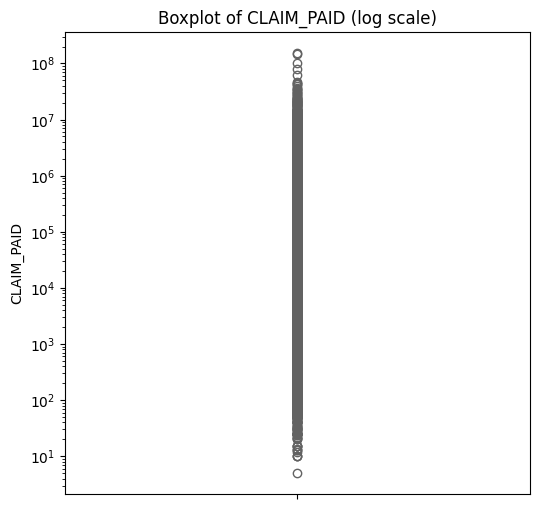

In [44]:
plt.figure(figsize=(6,6))
sns.boxplot(y="CLAIM_PAID", data=df, color="tomato")
plt.yscale("log")
plt.title("Boxplot of CLAIM_PAID (log scale)")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



### üìä ŸÜŸÖŸàÿØÿßÿ± ‚Üí Boxplot of CLAIM_PAID (log scale)  
- ŸÖÿ≠Ÿàÿ± ÿπŸÖŸàÿØ€å: **CLAIM_PAID** (ŸÖÿ®ŸÑÿ∫ ÿÆÿ≥ÿßÿ±ÿ™ Ÿæÿ±ÿØÿßÿÆÿ™€å) ÿØÿ± ŸÖŸÇ€åÿßÿ≥ ŸÑ⁄Øÿßÿ±€åÿ™ŸÖ€å.  
- Boxplot ÿØÿßÿØŸá‚ÄåŸáÿß ÿ±Ÿà ÿ®Ÿá ŸáŸÖÿ±ÿßŸá **ŸÖ€åÿßŸÜŸá (Median)**ÿå **⁄Üÿßÿ±⁄©‚ÄåŸáÿß (IQR)** Ÿà **ŸÖŸÇÿßÿØ€åÿ± Ÿæÿ±ÿ™ (Outliers)** ŸÜÿ¥ŸàŸÜ ŸÖ€å‚ÄåÿØŸá.  

### üîé ŸÖÿ¥ÿßŸáÿØÿßÿ™:  
1. ÿ®ÿÆÿ¥ ÿßÿπÿ∏ŸÖ ÿØÿßÿØŸá‚ÄåŸáÿß (ÿ®€åÿ¥ ÿßÿ≤ 75%) ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß€å ÿ®ÿ≥€åÿßÿ± Ÿæÿß€å€åŸÜ Ÿáÿ≥ÿ™.  
2. ÿØÿßÿØŸá‚ÄåŸáÿß€å Ÿæÿ±ÿ™ ÿ≤€åÿßÿØ€å ÿØÿ± ŸÖÿ≠ÿØŸàÿØŸá‚ÄåŸáÿß€å ÿ®ÿßŸÑÿßÿ™ÿ± ÿØ€åÿØŸá ŸÖ€å‚Äåÿ¥Ÿá (ÿßÿ≤ ŸÖ€åŸÑ€åŸàŸÜ‚ÄåŸáÿß ÿ™ÿß ÿµÿØ ŸÖ€åŸÑ€åŸàŸÜ‚ÄåŸáÿß).  
3. ⁄ÜŸàŸÜ ÿØÿßÿØŸá ÿÆ€åŸÑ€å **skewed** Ÿáÿ≥ÿ™ÿå Boxplot ÿØÿ± ÿß€åŸÜ ŸÖŸÇ€åÿßÿ≥ ÿ®€åÿ¥ÿ™ÿ± ÿ¥ÿ®€åŸá €å⁄© ÿÆÿ∑ ÿ®ÿßÿ±€å⁄© ÿ®Ÿá‚ÄåŸÜÿ∏ÿ± ŸÖ€åÿßÿØ.  

---

### üìå ŸÜÿ™€åÿ¨Ÿá‚Äå⁄Ø€åÿ±€å :  
- **ÿ™Ÿàÿ≤€åÿπ CLAIM_PAID ÿ¥ÿØ€åÿØÿßŸã ŸÜÿßŸÖÿ™Ÿàÿßÿ≤ŸÜ** Ÿáÿ≥ÿ™ ‚Üí ÿ™ÿπÿØÿßÿØ ⁄©ŸÖ€å ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß€å ÿÆ€åŸÑ€å ÿ®ÿ≤ÿ±⁄Ø Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá.  
- ÿß€åŸÜ ÿØÿßÿØŸá‚ÄåŸáÿß€å Ÿæÿ±ÿ™ (High severity claims) ŸÖ€å‚Äåÿ™ŸàŸÜŸÜ ÿ®Ÿá ÿ¥ÿØÿ™ ŸÖÿØŸÑ‚ÄåŸáÿß€å Ÿæ€åÿ¥‚Äåÿ®€åŸÜ€å ÿ±Ÿà ÿ™ÿ≠ÿ™ ÿ™ÿ£ÿ´€åÿ± ŸÇÿ±ÿßÿ± ÿ®ÿØŸÜ.  
- ÿ®ÿ±ÿß€å ÿ™ÿ≠ŸÑ€åŸÑ ÿ®Ÿáÿ™ÿ±:  
  - ŸÖ€å‚Äåÿ¥Ÿá ÿØÿßÿØŸá‚ÄåŸáÿß ÿ±Ÿà **Log-transform** ⁄©ÿ±ÿØ.  
  - €åÿß ÿØÿßÿØŸá‚ÄåŸáÿß€å Ÿæÿ±ÿ™ ÿ±Ÿà ÿ¨ÿØÿß ÿ®ÿ±ÿ±ÿ≥€å ⁄©ÿ±ÿØ (ÿ™ÿ≠ŸÑ€åŸÑ Claims ÿ®ÿ≤ÿ±⁄Ø ÿ®Ÿá ÿµŸàÿ±ÿ™ ÿ¨ÿØÿß⁄ØÿßŸÜŸá).  
  - €åÿß ÿßÿ≤ ÿ±Ÿàÿ¥‚ÄåŸáÿß€å€å ŸÖÿ´ŸÑ **Winsorization / Robust Scaling** ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØ.  

</div>

---



### üìä Chart ‚Üí Boxplot of CLAIM_PAID (log scale)  
- Y-axis: CLAIM_PAID (claim amount paid, log scale).  
- Shows distribution with median, IQR, and outliers.  

### üîé Observations:  
1. Most claims are clustered at **low amounts**.  
2. A huge number of **outliers** at high values (millions ‚Üí 100M+).  
3. The box itself looks compressed due to extreme skewness.  

---

### üìå Key Insights:  
- Distribution is **highly imbalanced** ‚Üí dominated by many small claims and few catastrophic ones.  
- Outliers strongly affect predictive modeling.  
- Recommended:  
  - **Log transform** the data.  
  - Analyze high-severity claims separately.  
  - Use **robust models** less sensitive to outliers.  


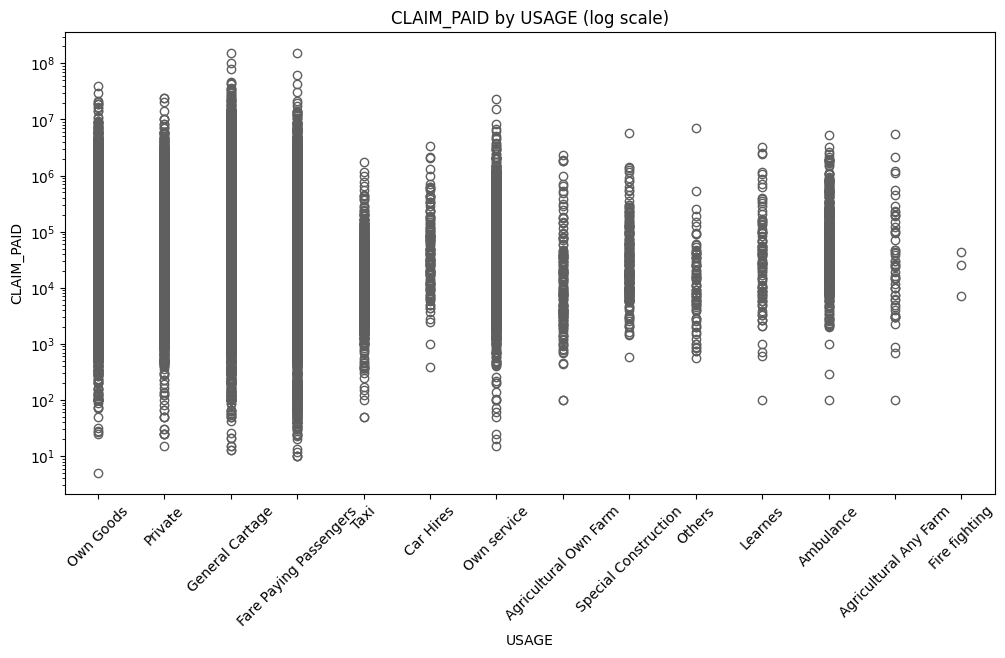

In [45]:
plt.figure(figsize=(12,6))
sns.boxplot(x="USAGE", y="CLAIM_PAID", data=df, palette="Set3")
plt.yscale("log")
plt.title("CLAIM_PAID by USAGE (log scale)")
plt.xticks(rotation=45)
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### üìä ÿ™ÿ≠ŸÑ€åŸÑ CLAIM_PAID ÿ®ÿ± ÿßÿ≥ÿßÿ≥ ŸÜŸàÿπ ÿßÿ≥ÿ™ŸÅÿßÿØŸá (USAGE)

### üîé ŸÖÿ¥ÿßŸáÿØÿßÿ™:
1. **Own Goodsÿå Private Ÿà General Cartage** ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ⁄Øÿ≥ÿ™ÿ±ÿØ⁄Ø€å ÿÆÿ≥ÿßÿ±ÿ™ ÿ±Ÿà ÿØÿßÿ±ŸÜ (ÿßÿ≤ ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß€å ⁄©ŸÖ ÿ™ÿß ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß€å ÿ®ÿ≥€åÿßÿ± ÿ®ÿ≤ÿ±⁄Ø).  
2. **Fare Paying Passengers Ÿà Taxi** ŸáŸÖ ÿßŸÑ⁄ØŸà€å ŸÖÿ¥ÿßÿ®Ÿá€å ÿØÿßÿ±ŸÜ ‚Üí ÿ±€åÿ≥⁄© ÿ®ÿßŸÑÿß€å ÿÆÿ≥ÿßÿ±ÿ™ ÿØÿ± ÿ≠ŸÖŸÑ ŸÖÿ≥ÿßŸÅÿ±.  
3. **Agricultural (Own Farm / Any Farm)** Ÿà **Learners** ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß€å ÿ®Ÿá‚ÄåŸÖÿ±ÿßÿ™ÿ® ⁄©Ÿà⁄Ü⁄©‚Äåÿ™ÿ±€å ÿØÿßÿ±ŸÜ (ÿÆÿ∑ÿ± ⁄©ŸÖÿ™ÿ±).  
4. **Ambulance** ŸáŸÖ ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß€å€å ŸÖÿ™ŸÜŸàÿπ ŸàŸÑ€å ÿØÿ± ÿ®ÿßÿ≤Ÿá ŸÖ€åÿßŸÜ€å ÿØÿßÿ±Ÿá.  
5. **Fire Fighting** ÿ®Ÿá ÿØŸÑ€åŸÑ ÿ™ÿπÿØÿßÿØ ÿØÿßÿØŸá‚ÄåŸáÿß€å ⁄©ŸÖÿå ÿ™Ÿàÿ≤€åÿπ ÿÆÿßÿµ€å ŸÜÿ¥ŸàŸÜ ŸÜŸÖ€å‚ÄåÿØŸá.  

---

### üìå ŸÜÿ™€åÿ¨Ÿá‚Äå⁄Ø€åÿ±€å:
- **ÿÆŸàÿØÿ±ŸàŸáÿß€å ÿ™ÿ¨ÿßÿ±€å (Own Goods, General Cartage, Taxis, Fare Paying Passengers)** ÿ®€åÿ¥ÿ™ÿ±€åŸÜ Ÿæÿ™ÿßŸÜÿ≥€åŸÑ ÿÆÿ≥ÿßÿ±ÿ™ ÿ≥ŸÜ⁄Ø€åŸÜ ÿ±Ÿà ÿØÿßÿ±ŸÜ.  
- **ÿÆŸàÿØÿ±ŸàŸáÿß€å ⁄©ÿ¥ÿßŸàÿ±ÿ≤€å Ÿà Learners** ⁄©ŸÖÿ™ÿ±€åŸÜ ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß ÿ±Ÿà ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äå⁄©ŸÜŸÜ.  
- **Private cars** ŸáŸÖ ⁄Øÿ≥ÿ™ÿ±Ÿá Ÿàÿ≥€åÿπ€å ÿßÿ≤ ÿÆÿ≥ÿßÿ±ÿ™ ÿØÿßÿ±ŸÜ (ÿ®€åÿ¥ÿ™ÿ± ÿ®Ÿá ÿØŸÑ€åŸÑ ÿ™ÿπÿØÿßÿØ ÿ®ÿßŸÑÿß€å ÿÆŸàÿØÿ±ŸàŸáÿß€å ÿ¥ÿÆÿµ€å).  

---

### üîπ Summary:
- **Commercial vehicles (Goods, Cartage, Taxis, Passengers)** ‚Üí highest claim severity.  
- **Agricultural & Learners** ‚Üí lowest claim severity.  
- **Private cars** ‚Üí wide range of claims, driven by large volume.  

</div>


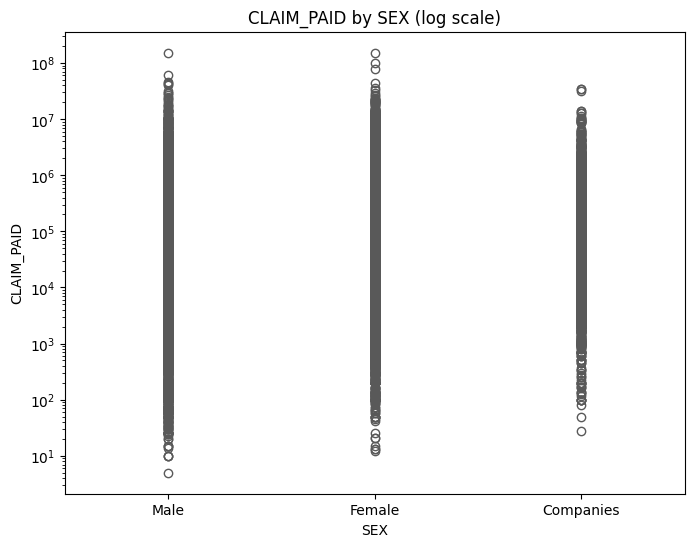

In [46]:
plt.figure(figsize=(8,6))
sns.boxplot(x="SEX", y="CLAIM_PAID", data=df, palette="Set2")
plt.yscale("log")
plt.title("CLAIM_PAID by SEX (log scale)")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### üìä ÿ™ÿ≠ŸÑ€åŸÑ CLAIM_PAID ÿ®ÿ± ÿßÿ≥ÿßÿ≥ ÿ¨ŸÜÿ≥€åÿ™ (SEX)

### üîé ŸÖÿ¥ÿßŸáÿØÿßÿ™:
1. **Ÿáÿ± ÿ≥Ÿá ⁄Øÿ±ŸàŸá (Male, Female, Companies)** ÿ®ÿßÿ≤Ÿá ŸÖÿ¥ÿßÿ®Ÿá€å ÿßÿ≤ ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß ÿØÿßÿ±ŸÜÿå ÿßÿ≤ ŸÖŸÇÿßÿØ€åÿ± ÿÆ€åŸÑ€å ⁄©ŸÖ ÿ™ÿß ŸÖŸÇÿßÿØ€åÿ± ÿÆ€åŸÑ€å ÿ®ÿ≤ÿ±⁄Ø (€±€∞‚Å∏).  
2. **ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß (Companies)** Ÿæÿ±ÿß⁄©ŸÜÿØ⁄Ø€å ŸÜÿ≥ÿ®ÿ™ÿßŸã ⁄©ŸÖÿ™ÿ± ÿØÿßÿ±ŸÜÿå ÿßŸÖÿß ŸáŸÖ⁄ÜŸÜÿßŸÜ ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß€å ÿ®ÿ≤ÿ±⁄Ø ÿØ€åÿØŸá ŸÖ€å‚Äåÿ¥Ÿá.  
3. **ÿÆÿßŸÜŸÖ‚ÄåŸáÿß Ÿà ÿ¢ŸÇÿß€åÿßŸÜ (Female, Male)** ÿßŸÑ⁄ØŸà€å ÿ™ŸÇÿ±€åÿ®ÿßŸã ŸÖÿ¥ÿßÿ®Ÿá€å ÿØÿßÿ±ŸÜ Ÿà ÿ™ŸÅÿßŸàÿ™ ÿ≤€åÿßÿØ€å ÿØÿ± ÿ™Ÿàÿ≤€åÿπ Claims ÿØ€åÿØŸá ŸÜŸÖ€å‚Äåÿ¥Ÿá.  
4. Ÿàÿ¨ŸàÿØ **outlierŸáÿß€å ÿ®ÿ≥€åÿßÿ± ÿ≤€åÿßÿØ** ÿØÿ± Ÿáÿ± ÿ≥Ÿá ⁄Øÿ±ŸàŸáÿå ŸÜÿ¥ŸàŸÜ ŸÖ€å‚ÄåÿØŸá ⁄©Ÿá ÿßŸÇŸÑ€åÿ™ ⁄©Ÿà⁄Ü⁄©€å ÿßÿ≤ ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß ŸÖŸÇÿßÿØ€åÿ± ÿ®ÿ≥€åÿßÿ± ÿ®ÿßŸÑÿß€å€å ÿØÿßÿ±ŸÜ.  

---

### üìå ŸÜÿ™€åÿ¨Ÿá‚Äå⁄Ø€åÿ±€å:
- **ÿ¨ŸÜÿ≥€åÿ™ ÿ®Ÿá ÿ™ŸÜŸáÿß€å€å ÿπÿßŸÖŸÑ ÿ™ÿπ€å€åŸÜ‚Äå⁄©ŸÜŸÜÿØŸá ŸÇŸà€å ÿØÿ± ŸÖ€åÿ≤ÿßŸÜ ÿÆÿ≥ÿßÿ±ÿ™ ŸÜ€åÿ≥ÿ™.**  
- Ÿáÿ± ÿ≥Ÿá ⁄Øÿ±ŸàŸá (ÿ≤ŸÜÿå ŸÖÿ±ÿØÿå ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß) Ÿæÿ™ÿßŸÜÿ≥€åŸÑ ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß€å ÿ®ÿ≤ÿ±⁄Ø ÿØÿßÿ±ŸÜ.  
- ÿ¥ÿß€åÿØ ÿ™ÿ±⁄©€åÿ® ÿ¨ŸÜÿ≥€åÿ™ ÿ®ÿß ÿ≥ÿß€åÿ± ŸÖÿ™ÿ∫€åÿ±Ÿáÿß ŸÖÿ´ŸÑ **ÿ≥ŸÜÿå ŸÜŸàÿπ ÿßÿ≥ÿ™ŸÅÿßÿØŸá (USAGE)ÿå Ÿà ŸÜŸàÿπ Ÿàÿ≥€åŸÑŸá ŸÜŸÇŸÑ€åŸá** ÿßŸÑ⁄ØŸàŸáÿß€å ÿØŸÇ€åŸÇ‚Äåÿ™ÿ±€å ÿ®ÿØŸá.  

---

### üîπ Summary:
- Claim distributions are **similar across Male, Female, and Companies**.  
- Gender alone doesn‚Äôt significantly affect claim severity.  
- Outliers exist in all groups, suggesting other factors (like age, usage, vehicle type) are more important.  

</div>


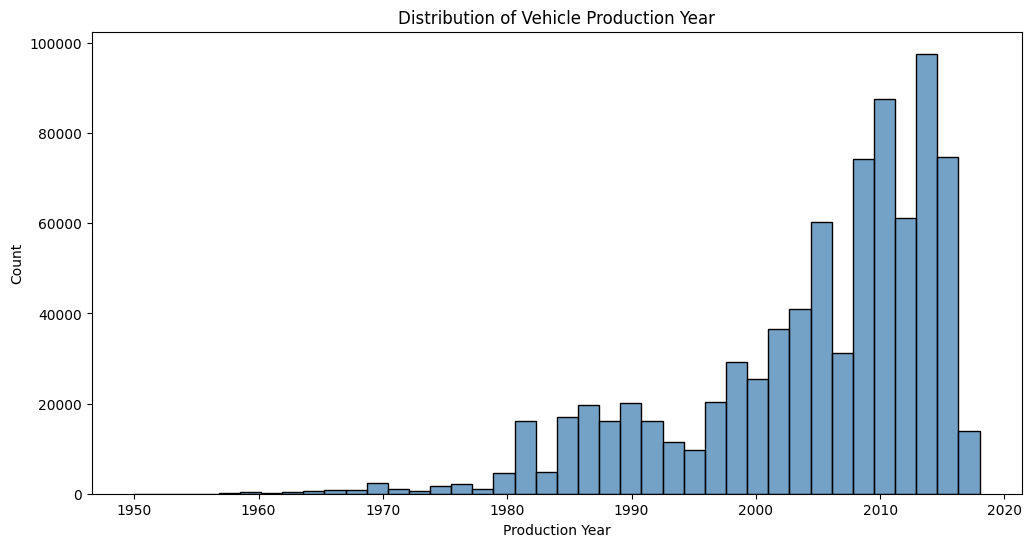

In [47]:
plt.figure(figsize=(12,6))
sns.histplot(df["PROD_YEAR"], bins=40, kde=False, color="steelblue")
plt.title("Distribution of Vehicle Production Year")
plt.xlabel("Production Year")
plt.ylabel("Count")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

#### üìä ÿ™ÿ≠ŸÑ€åŸÑ ÿ≥ÿßŸÑ ÿ™ŸàŸÑ€åÿØ ÿÆŸàÿØÿ±ŸàŸáÿß (Vehicle Production Year)

### üîé ŸÖÿ¥ÿßŸáÿØÿßÿ™:
1. ÿ™ÿß ŸÇÿ®ŸÑ ÿßÿ≤ ÿ≥ÿßŸÑ‚ÄåŸáÿß€å **1980** ÿ™ÿπÿØÿßÿØ ÿÆŸàÿØÿ±ŸàŸáÿß ÿÆ€åŸÑ€å ⁄©ŸÖ ÿ®ŸàÿØŸá.  
2. ÿßÿ≤ **ÿØŸáŸá 1990** ÿ®Ÿá ÿ®ÿπÿØ ÿ™ÿπÿØÿßÿØ ÿÆŸàÿØÿ±ŸàŸáÿß ÿ®Ÿá ÿ™ÿØÿ±€åÿ¨ ÿßŸÅÿ≤ÿß€åÿ¥ Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸá.  
3. ÿ±ÿ¥ÿØ ÿßÿµŸÑ€å ÿßÿ≤ ÿ≠ÿØŸàÿØ **ÿ≥ÿßŸÑ 2005** ÿ¥ÿ±Ÿàÿπ ÿ¥ÿØŸá Ÿà ÿ™ÿπÿØÿßÿØ ÿ≤€åÿßÿØ€å ÿßÿ≤ ÿÆŸàÿØÿ±ŸàŸáÿß ÿØÿ± ŸÅÿßÿµŸÑŸá **2005 ÿ™ÿß 2015** ÿ™ŸàŸÑ€åÿØ ÿ¥ÿØŸá‚ÄåÿßŸÜÿØ.  
4. ÿ®ÿπÿØ ÿßÿ≤ **2015 ÿ™ÿß 2018** ÿßŸàÿ¨ ÿ™ŸàŸÑ€åÿØ ÿÆŸàÿØÿ±Ÿà ÿØÿ± ÿØÿßÿØŸá‚ÄåŸáÿß ÿØ€åÿØŸá ŸÖ€å‚Äåÿ¥Ÿá.  
5. ÿÆŸàÿØÿ±ŸàŸáÿß€å **ŸÇÿ®ŸÑ ÿßÿ≤ 1980** ÿ®ÿ≥€åÿßÿ± ⁄©ŸÖ Ÿáÿ≥ÿ™ŸÜÿØ Ÿà ÿ≥ŸáŸÖ ŸÜÿß⁄Ü€åÿ≤€å ÿØÿ± ÿØÿßÿØŸá ÿØÿßÿ±ŸÜÿØ.  

---

### üìå ŸÜÿ™€åÿ¨Ÿá‚Äå⁄Ø€åÿ±€å:
- ÿ®€åÿ¥ÿ™ÿ± ÿÆŸàÿØÿ±ŸàŸáÿß€å ŸÖŸàÿ¨ŸàÿØ ÿØÿ± ÿØÿßÿØŸá **ÿ¨ÿØ€åÿØ Ÿà ŸÖÿØÿ±ŸÜ (ÿ®ÿπÿØ ÿßÿ≤ 2005)** Ÿáÿ≥ÿ™ŸÜÿØ.  
- ÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ ŸÖ€å‚Äåÿ™ŸàŸÜŸá ÿ±Ÿà€å **ŸÖ€åÿ≤ÿßŸÜ ÿÆÿ≥ÿßÿ±ÿ™ Ÿà ÿ±ŸÅÿ™ÿßÿ± Claims** ÿßÿ´ÿ± ÿ®ÿ∞ÿßÿ±Ÿá (⁄ÜŸàŸÜ ÿÆŸàÿØÿ±ŸàŸáÿß€å ÿ¨ÿØ€åÿØÿ™ÿ± ŸÖÿπŸÖŸàŸÑÿßŸã Ÿáÿ≤€åŸÜŸá ÿ™ÿπŸÖ€åÿ± ÿ®ÿßŸÑÿßÿ™ÿ± ÿØÿßÿ±ŸÜ).  
- ÿÆŸàÿØÿ±ŸàŸáÿß€å ÿÆ€åŸÑ€å ŸÇÿØ€åŸÖ€å ÿ™ÿπÿØÿßÿØ ⁄©ŸÖ€å ÿØÿßÿ±ŸÜÿå Ÿæÿ≥ ÿ™ÿ£ÿ´€åÿ± ÿ≤€åÿßÿØ€å ÿØÿ± ÿ™ÿ≠ŸÑ€åŸÑ ⁄©ŸÑ€å ŸÜÿÆŸàÿßŸáŸÜÿØ ÿØÿßÿ¥ÿ™.  

---

### üîπ  Summary:
- Majority of vehicles were produced **after 2005**, peaking between 2010‚Äì2018.  
- Very few vehicles before 1980.  
- Newer vehicles dominate the dataset, which could influence **claim severity (higher repair costs)**.  

</div>


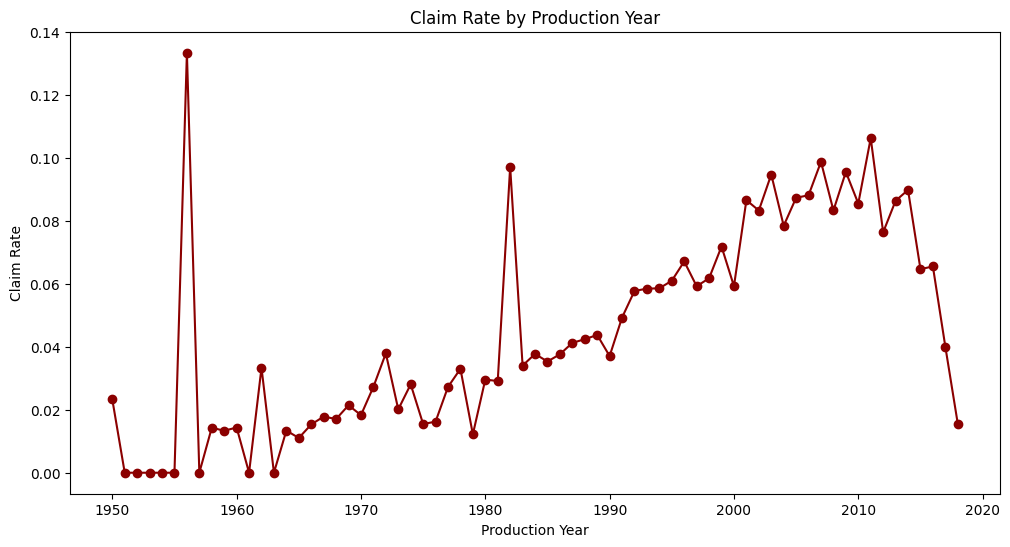

In [48]:
prod_claim = df.groupby("PROD_YEAR")["CLAIM_FLAG"].mean()

plt.figure(figsize=(12,6))
prod_claim.plot(kind="line", marker="o", color="darkred")
plt.title("Claim Rate by Production Year")
plt.xlabel("Production Year")
plt.ylabel("Claim Rate")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### üìä ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿ± ÿßÿ≥ÿßÿ≥ ÿ≥ÿßŸÑ ÿ™ŸàŸÑ€åÿØ ÿÆŸàÿØÿ±ŸàŸáÿß (Claim Rate by Production Year)

### üîé ŸÖÿ¥ÿßŸáÿØÿßÿ™:
1. ÿ™ÿß ŸÇÿ®ŸÑ ÿßÿ≤ **1960** ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿØÿ± ÿ®€åÿ¥ÿ™ÿ± ÿ≥ÿßŸÑ‚ÄåŸáÿß ŸÜÿ≤ÿØ€å⁄© ÿ®Ÿá ÿµŸÅÿ± ÿ®ŸàÿØŸá Ÿà ÿØÿßÿØŸá‚ÄåŸáÿß ⁄©ŸÖ Ÿáÿ≥ÿ™ŸÜÿØ.  
2. ÿØÿ± **ÿØŸáŸá 1960 ÿ™ÿß 1980** ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ŸÜŸàÿ≥ÿßŸÜ ÿ≤€åÿßÿØ€å ÿØÿßÿ¥ÿ™Ÿá Ÿà ⁄ÜŸÜÿØ€åŸÜ Ÿæ€å⁄© ÿ∫€åÿ±ÿπÿßÿØ€å ÿØ€åÿØŸá ŸÖ€å‚Äåÿ¥ŸàÿØ (ŸÖÿ´ŸÑÿßŸã ÿ≠ŸàÿßŸÑ€å 1957 Ÿà 1982).  
3. ÿßÿ≤ **ÿØŸáŸá 1990** ÿ®Ÿá ÿ®ÿπÿØ ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®Ÿá‚ÄåÿµŸàÿ±ÿ™ Ÿæ€åŸàÿ≥ÿ™Ÿá ÿßŸÅÿ≤ÿß€åÿ¥ Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸá ÿßÿ≥ÿ™.  
4. ÿ®€åŸÜ ÿ≥ÿßŸÑ‚ÄåŸáÿß€å **2000 ÿ™ÿß 2015** ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®Ÿá ÿ®ÿßŸÑÿßÿ™ÿ±€åŸÜ ÿ≥ÿ∑ÿ≠ ÿ±ÿ≥€åÿØŸá Ÿà ÿØÿ± ŸÖÿ≠ÿØŸàÿØŸá **0.08 ÿ™ÿß 0.1** ÿØÿ± ŸÜŸàÿ≥ÿßŸÜ ÿ®ŸàÿØŸá.  
5. Ÿæÿ≥ ÿßÿ≤ **2015** ÿ±ŸàŸÜÿØ ⁄©ÿßŸáÿ¥€å ÿ¢ÿ∫ÿßÿ≤ ÿ¥ÿØŸá Ÿà ÿ™ÿß ÿ≠ŸàÿßŸÑ€å 2018‚Äì2020 ÿßŸÅÿ™ ŸÖÿ≠ÿ≥Ÿàÿ≥€å ÿØÿ± ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ŸÖÿ¥ÿßŸáÿØŸá ŸÖ€å‚Äåÿ¥ŸàÿØ.  

---

### üìå ŸÜÿ™€åÿ¨Ÿá‚Äå⁄Ø€åÿ±€å:
- ÿÆŸàÿØÿ±ŸàŸáÿß€å ÿ™ŸàŸÑ€åÿØ€å **ŸÇÿ®ŸÑ ÿßÿ≤ 1980** ÿØÿßÿØŸá‚ÄåŸáÿß€å ⁄©ŸÖ Ÿà ŸÜŸàÿ≥ÿßŸÜ ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÜÿØÿå ÿ®ŸÜÿßÿ®ÿ±ÿß€åŸÜ ÿ™ÿ≠ŸÑ€åŸÑ ÿ¢ŸÜ‚ÄåŸáÿß ⁄ÜŸÜÿØÿßŸÜ ŸÇÿßÿ®ŸÑ ÿßÿ™⁄©ÿß ŸÜ€åÿ≥ÿ™.  
- ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿßÿ≤ **1990 ÿ™ÿß 2015** ÿ±ŸàŸÜÿØ ÿßŸÅÿ≤ÿß€åÿ¥€å ÿØÿßÿ¥ÿ™Ÿá ⁄©Ÿá ŸÜÿ¥ÿßŸÜ‚ÄåÿØŸáŸÜÿØŸá **ÿ±€åÿ≥⁄© ÿ®ÿßŸÑÿßÿ™ÿ± ÿØÿ± ÿÆŸàÿØÿ±ŸàŸáÿß€å ŸÖÿØÿ±ŸÜ‚Äåÿ™ÿ±** ÿßÿ≥ÿ™.  
- ÿ®ÿπÿØ ÿßÿ≤ **2015** ÿ®Ÿá ŸÜÿ∏ÿ± ŸÖ€å‚Äåÿ±ÿ≥ÿØ ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ⁄©ÿßŸáÿ¥ Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸá ⁄©Ÿá ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÜÿßÿ¥€å ÿßÿ≤ **ÿ®Ÿáÿ®ŸàÿØ ÿß€åŸÖŸÜ€å ÿÆŸàÿØÿ±ŸàŸáÿß** €åÿß **ÿ≥€åÿßÿ≥ÿ™‚ÄåŸáÿß€å ÿ®€åŸÖŸá‚Äåÿß€å ÿ¨ÿØ€åÿØ** ÿ®ÿßÿ¥ÿØ.  
- ÿ®Ÿá‚Äåÿ∑Ÿàÿ± ⁄©ŸÑ€åÿå **ÿÆŸàÿØÿ±ŸàŸáÿß€å ÿ™ŸàŸÑ€åÿØ 2000 ÿ™ÿß 2015** ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ÿ±€åÿ≥⁄© ÿÆÿ≥ÿßÿ±ÿ™ ÿ±ÿß ÿØÿ± ÿØÿßÿØŸá‚ÄåŸáÿß ŸÜÿ¥ÿßŸÜ ŸÖ€å‚ÄåÿØŸáŸÜÿØ.  

---

### üîπ Summary:
- Claim rate was **near zero before 1960** due to very few vehicles.  
- Strong fluctuations between **1960‚Äì1980** with some unusual spikes.  
- A **steady increase** in claim rate from the **1990s**, peaking between **2000‚Äì2015 (‚âà0.08‚Äì0.1)**.  
- After **2015**, claim rates show a **declining trend**, possibly due to **safer vehicles or insurance policies**.  
- Vehicles produced between **2000‚Äì2015** represent the **highest risk group** in the dataset.  

</div>


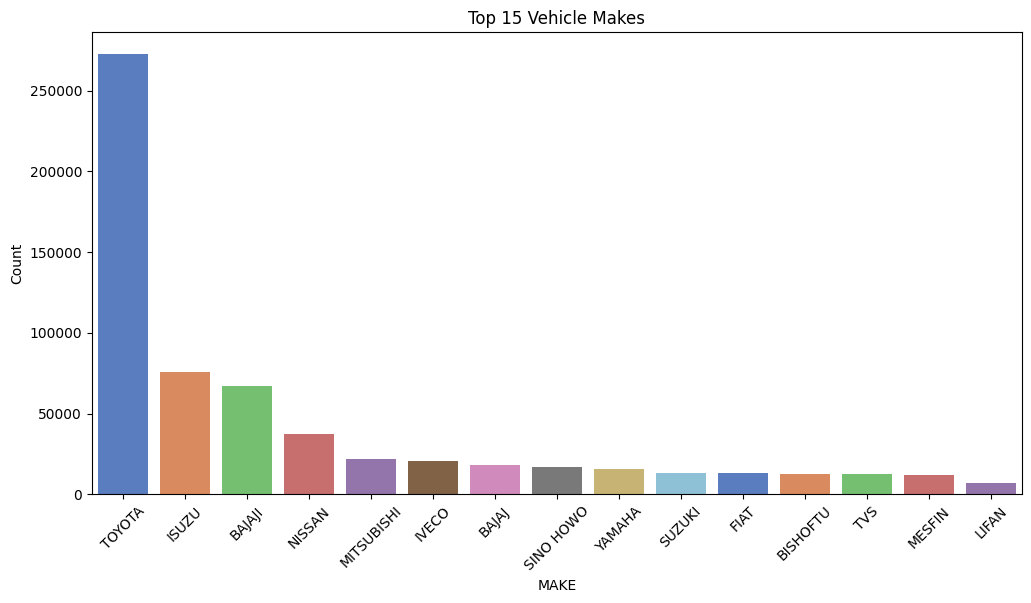

In [49]:
top_makes = df["MAKE"].value_counts().head(15)

plt.figure(figsize=(12,6))
sns.barplot(x=top_makes.index, y=top_makes.values, palette="muted")
plt.title("Top 15 Vehicle Makes")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()



<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### üöó ÿ™ÿ≠ŸÑ€åŸÑ ÿ®ÿ±ŸÜÿØŸáÿß€å ÿÆŸàÿØÿ±Ÿà (Top 15 Vehicle Makes)

### üîé ŸÖÿ¥ÿßŸáÿØÿßÿ™:
1. ÿ®ÿ±ŸÜÿØ **TOYOTA** ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ÿ≥ŸáŸÖ ÿ±ÿß ÿØÿßÿ±ÿØ Ÿà ÿßÿÆÿ™ŸÑÿßŸÅ ÿ®ÿ≥€åÿßÿ± ÿ≤€åÿßÿØ€å ÿ®ÿß ÿ≥ÿß€åÿ± ÿ®ÿ±ŸÜÿØŸáÿß ÿØ€åÿØŸá ŸÖ€å‚Äåÿ¥ŸàÿØ (ÿ®€åÿ¥ ÿßÿ≤ 270 Ÿáÿ≤ÿßÿ± ÿÆŸàÿØÿ±Ÿà).  
2. Ÿæÿ≥ ÿßÿ≤ ÿ¢ŸÜ ÿ®ÿ±ŸÜÿØŸáÿß€å **ISUZU** Ÿà **BAJAJ** ÿØÿ± ÿ±ÿ™ÿ®Ÿá‚ÄåŸáÿß€å ÿ®ÿπÿØ€å ŸÇÿ±ÿßÿ± ÿØÿßÿ±ŸÜÿØ ÿßŸÖÿß ŸÅÿßÿµŸÑŸá ÿ¢ŸÜŸáÿß ÿ®ÿß ÿ™Ÿà€åŸàÿ™ÿß ÿ®ÿ≥€åÿßÿ± ÿ≤€åÿßÿØ ÿßÿ≥ÿ™.  
3. ÿ®ÿ±ŸÜÿØŸáÿß€å ÿØ€å⁄Øÿ± ŸÖÿ´ŸÑ **NISSANÿå MITSUBISHIÿå IVECOÿå SUZUKI** ÿ≥ŸáŸÖ ⁄©ŸÖÿ™ÿ±€å ÿØÿ± ÿØÿßÿØŸá‚ÄåŸáÿß ÿØÿßÿ±ŸÜÿØ.  
4. ÿ®ÿ±ÿÆ€å ÿ®ÿ±ŸÜÿØŸáÿß€å ⁄©ŸÖÿ™ÿ± ÿ¥ŸÜÿßÿÆÿ™Ÿá‚Äåÿ¥ÿØŸá ŸÖÿßŸÜŸÜÿØ **BISHOFTUÿå MESFINÿå LIFAN** ÿ≠ÿ∂Ÿàÿ± ÿ®ÿ≥€åÿßÿ± ŸÖÿ≠ÿØŸàÿØ€å ÿØÿßÿ±ŸÜÿØ.  
5. ÿ™ŸÖÿ±⁄©ÿ≤ ÿßÿµŸÑ€å ÿÆŸàÿØÿ±ŸàŸáÿß ÿ±Ÿà€å ⁄ÜŸÜÿØ ÿ®ÿ±ŸÜÿØ ÿÆÿßÿµ ÿßÿ≥ÿ™ Ÿà ÿ®€åÿ¥ÿ™ÿ± ÿ®ÿ±ŸÜÿØŸáÿß ÿ≥ŸáŸÖ ÿ®ÿ≥€åÿßÿ± ⁄©ŸÖ€å ÿØÿßÿ±ŸÜÿØ.  

---

### üìå ŸÜÿ™€åÿ¨Ÿá‚Äå⁄Ø€åÿ±€å:
- ÿ®ÿßÿ≤ÿßÿ± ÿÆŸàÿØÿ±Ÿà ÿØÿ± ÿØÿßÿØŸá‚ÄåŸáÿß ÿ®Ÿá ÿ¥ÿØÿ™ ÿ™ÿ≠ÿ™ ÿ™ÿ£ÿ´€åÿ± **Toyota** ÿßÿ≥ÿ™ ⁄©Ÿá ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿØÿ± ÿ™ÿ≠ŸÑ€åŸÑ ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß Ÿà ÿßŸÑ⁄ØŸàŸáÿß€å Claims ŸÜŸÇÿ¥ ŸÖŸáŸÖ€å ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ÿØ.  
- ÿ®ÿ±ŸÜÿØŸáÿß€å **ISUZU** Ÿà **BAJAJ** ŸáŸÖ ÿ®ÿß ÿ≥ŸáŸÖ ŸÖÿ™Ÿàÿ≥ÿ∑ ŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÜÿØ ÿØÿ± ÿ±ÿ™ÿ®Ÿá ÿ®ÿπÿØ€å ÿßŸáŸÖ€åÿ™ ŸÇÿ±ÿßÿ± ÿ®⁄Ø€åÿ±ŸÜÿØ.  
- ÿ®ÿ±ŸÜÿØŸáÿß€å ⁄©Ÿà⁄Ü⁄© ÿ™ÿ£ÿ´€åÿ± ÿ≤€åÿßÿØ€å ÿØÿ± ÿ±ŸàŸÜÿØ ⁄©ŸÑ€å ÿ™ÿ≠ŸÑ€åŸÑ ŸÜÿÆŸàÿßŸáŸÜÿØ ÿØÿßÿ¥ÿ™.  

---

### üîπ Summary:
- **Toyota dominates** the dataset with a very large share.  
- **Isuzu** and **Bajaj** follow, but with significantly smaller counts.  
- Other brands (e.g., **Nissan, Mitsubishi, Iveco, Suzuki**) have much lower presence.  
- Niche brands (e.g., **Bishoftu, Mesfin, Lifan**) are minimal.  
- The dataset is **heavily concentrated around a few major brands**.  

</div>


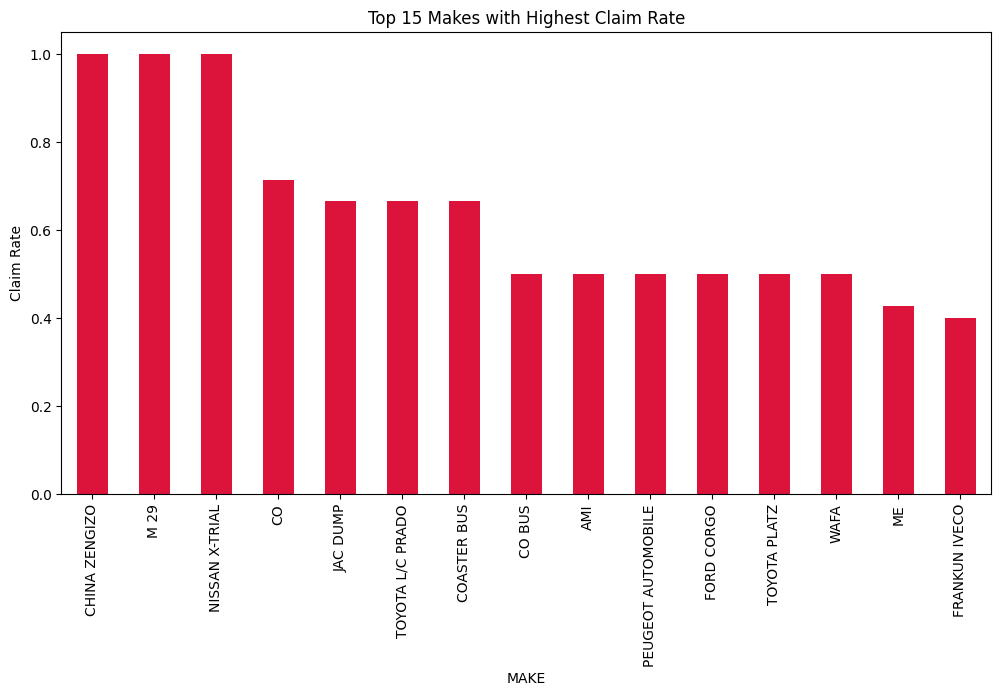

In [50]:
make_claim = df.groupby("MAKE")["CLAIM_FLAG"].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,6))
make_claim.plot(kind="bar", color="crimson")
plt.title("Top 15 Makes with Highest Claim Rate")
plt.ylabel("Claim Rate")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### üöò ÿ™ÿ≠ŸÑ€åŸÑ ÿ®ÿ±ŸÜÿØŸáÿß€å ÿÆŸàÿØÿ±Ÿà ÿ®ÿß ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ (Top 15 Makes with Highest Claim Rate)

### üîé ŸÖÿ¥ÿßŸáÿØÿßÿ™:

1. ÿØÿ± ŸÖ€åÿßŸÜ ÿ®ÿ±ŸÜÿØŸáÿßÿå ÿ®ÿ±ÿÆ€å ŸÖÿ´ŸÑ **M 29**ÿå **NISSAN X-TRAIL** Ÿà **CHINA ZENGIZO** ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿ≥€åÿßÿ± ÿ®ÿßŸÑÿß€å€å (ŸÜÿ≤ÿØ€å⁄© ÿ®Ÿá €±) ÿØÿßÿ±ŸÜÿØ.
2. ÿ®ÿ±ŸÜÿØŸáÿß€å€å ŸÖÿßŸÜŸÜÿØ **JAC DUMP**ÿå **TOYOTA LC PRADO** Ÿà **COASTER BUS** ŸáŸÖ ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿßŸÑÿßÿ™ÿ±€å ÿßÿ≤ ŸÖ€åÿßŸÜ⁄Ø€åŸÜ ÿØÿßÿ±ŸÜÿØ.
3. ÿ®ÿ±ŸÜÿØŸáÿß€å ÿ±ÿß€åÿ¨‚Äåÿ™ÿ± ŸÖÿ´ŸÑ **TOYOTA PLATZ** Ÿà **FORD CARGO** ŸÜ€åÿ≤ ÿØÿ± ŸÑ€åÿ≥ÿ™ Ÿæÿ±ÿ±€åÿ≥⁄© ŸÇÿ±ÿßÿ± ⁄Øÿ±ŸÅÿ™Ÿá‚ÄåÿßŸÜÿØ.
4. ÿ®€åÿ¥ÿ™ÿ± ÿ®ÿ±ŸÜÿØŸáÿß€å ŸÖŸàÿ¨ŸàÿØ ÿØÿ± ÿß€åŸÜ ŸÑ€åÿ≥ÿ™ ÿ≥ŸáŸÖ ÿ≤€åÿßÿØ€å ÿßÿ≤ ÿ™ÿπÿØÿßÿØ ⁄©ŸÑ ÿÆŸàÿØÿ±ŸàŸáÿß ŸÜÿØÿßÿ±ŸÜÿØÿå ŸàŸÑ€å **ÿ¥ÿØÿ™ ÿÆÿ≥ÿßÿ±ÿ™** ÿ¢ŸÜŸáÿß ÿ®ÿßŸÑÿß ÿßÿ≥ÿ™.

---

### üìå ŸÜÿ™€åÿ¨Ÿá‚Äå⁄Ø€åÿ±€å:

* ÿÆŸàÿØÿ±ŸàŸáÿß€å€å ÿ®ÿß ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿßŸÑÿß ŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÜÿØ ÿ±€åÿ≥⁄© ÿ®€åŸÖŸá‚Äåÿß€å ÿ®ÿßŸÑÿßÿ™ÿ±€å ÿ®ÿ±ÿß€å ÿ¥ÿ±⁄©ÿ™ ÿ®€åŸÖŸá ÿß€åÿ¨ÿßÿØ ⁄©ŸÜŸÜÿØÿå ÿ≠ÿ™€å ÿß⁄Øÿ± ÿ™ÿπÿØÿßÿØÿ¥ÿßŸÜ ⁄©ŸÖ ÿ®ÿßÿ¥ÿØ.
* ÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ ŸÜÿ¥ÿßŸÜ ŸÖ€å‚ÄåÿØŸáÿØ ⁄©Ÿá ÿµÿ±ŸÅÿßŸã **ÿ™ÿπÿØÿßÿØ ÿÆŸàÿØÿ±ŸàŸáÿß** ŸÖŸÑÿß⁄© ÿ±€åÿ≥⁄© ŸÜ€åÿ≥ÿ™ÿå ÿ®ŸÑ⁄©Ÿá **ÿßŸÑ⁄ØŸà€å ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿ±ŸÜÿØŸáÿß** ŸÜ€åÿ≤ ÿ®ÿß€åÿØ ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ŸàÿØ.
* ÿ®ÿ±ŸÜÿØŸáÿß€å ÿ®ÿß ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿßŸÑÿßÿ™ÿ± ÿßÿ≠ÿ™ŸÖÿßŸÑÿßŸã ŸÜ€åÿßÿ≤ŸÖŸÜÿØ **ÿ≠ŸÇ ÿ®€åŸÖŸá ÿ®ÿßŸÑÿßÿ™ÿ± €åÿß ÿ¥ÿ±ÿß€åÿ∑ ÿ≥ÿÆÿ™⁄Ø€åÿ±ÿßŸÜŸá‚Äåÿ™ÿ± ÿ®€åŸÖŸá‚Äåÿß€å** ÿÆŸàÿßŸáŸÜÿØ ÿ®ŸàÿØ.

---

### üîπ  Summary:

* Certain makes like **M 29**, **NISSAN X-TRAIL**, and **CHINA ZENGIZO** show the **highest claim rates (\~1.0)**.
* Other brands such as **JAC DUMP** and **TOYOTA LC PRADO** also exhibit higher-than-average claim rates.
* Even some popular makes like **TOYOTA PLATZ** and **FORD CARGO** appear among the high-risk group.
* High claim rate makes pose greater **insurance risk**, regardless of their market share, and may require **higher premiums or stricter policies**.

</div>  


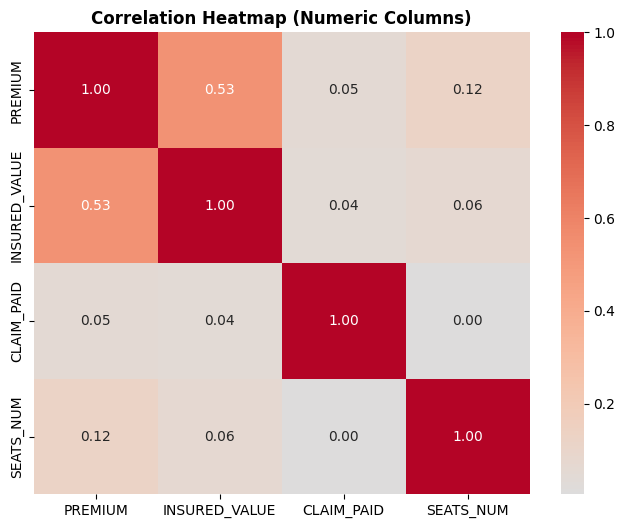

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ["PREMIUM", "INSURED_VALUE", "CLAIM_PAID", "SEATS_NUM"]
corr = df[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Heatmap (Numeric Columns)", weight="bold")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### üî• ÿ™ÿ≠ŸÑ€åŸÑ ŸáŸÖÿ®ÿ≥ÿ™⁄Ø€å ŸÖÿ™ÿ∫€åÿ±Ÿáÿß€å ÿπÿØÿØ€å (Correlation Heatmap)

### üîé ŸÖÿ¥ÿßŸáÿØÿßÿ™:
1. ÿ®€åŸÜ **ÿ≠ŸÇ ÿ®€åŸÖŸá (PREMIUM)** Ÿà **ÿßÿ±ÿ≤ÿ¥ ÿ®€åŸÖŸá‚Äåÿ¥ÿØŸá (INSURED_VALUE)** €å⁄© ŸáŸÖÿ®ÿ≥ÿ™⁄Ø€å ŸÜÿ≥ÿ®ÿ™ÿßŸã ŸÇŸà€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ (**0.53**).  
   - ŸÖŸÜÿ∑ŸÇ€å ÿßÿ≥ÿ™ ⁄ÜŸàŸÜ Ÿáÿ±⁄ÜŸá ÿßÿ±ÿ≤ÿ¥ ÿÆŸàÿØÿ±Ÿà ÿ®€åÿ¥ÿ™ÿ± ÿ®ÿßÿ¥ÿØÿå ÿ≠ŸÇ ÿ®€åŸÖŸá ŸáŸÖ ÿ®ÿßŸÑÿßÿ™ÿ± ÿßÿ≥ÿ™.  

2. **ÿ™ÿπÿØÿßÿØ ÿµŸÜÿØŸÑ€å (SEATS_NUM)** ŸáŸÖÿ®ÿ≥ÿ™⁄Ø€å ÿ∂ÿπ€åŸÅ€å ÿ®ÿß ÿ≥ÿß€åÿ± ŸÖÿ™ÿ∫€åÿ±Ÿáÿß ÿØÿßÿ±ÿØ.  
   - ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ŸÖŸÇÿØÿßÿ± ÿ¢ŸÜ ÿ®ÿß **ÿ≠ŸÇ ÿ®€åŸÖŸá** ÿßÿ≥ÿ™ (**0.12**)ÿå ⁄©Ÿá ŸÜÿ¥ÿßŸÜ ŸÖ€å‚ÄåÿØŸáÿØ ÿ™ÿ£ÿ´€åÿ± ⁄ÜŸÜÿØÿßŸÜ€å ÿ±Ÿà€å ÿ®€åŸÖŸá €åÿß ÿÆÿ≥ÿßÿ±ÿ™ ŸÜÿØÿßÿ±ÿØ.  

3. **ŸÖÿ®ŸÑÿ∫ ÿÆÿ≥ÿßÿ±ÿ™ Ÿæÿ±ÿØÿßÿÆÿ™€å (CLAIM_PAID)** ÿ™ŸÇÿ±€åÿ®ÿßŸã Ÿá€å⁄Ü ŸáŸÖÿ®ÿ≥ÿ™⁄Ø€å ŸÖÿπŸÜÿßÿØÿßÿ±€å ÿ®ÿß ŸÖÿ™ÿ∫€åÿ±Ÿáÿß€å ÿØ€å⁄Øÿ± ŸÜÿØÿßÿ±ÿØ (ŸÖŸÇÿßÿØ€åÿ± ŸÜÿ≤ÿØ€å⁄© ÿ®Ÿá ÿµŸÅÿ±).  
   - €åÿπŸÜ€å ŸÖ€åÿ≤ÿßŸÜ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®€åÿ¥ÿ™ÿ± ÿ®Ÿá ÿπŸàÿßŸÖŸÑ ÿ™ÿµÿßÿØŸÅ€å Ÿà ÿ¥ÿ±ÿß€åÿ∑ ÿ≠ÿßÿØÿ´Ÿá Ÿàÿßÿ®ÿ≥ÿ™Ÿá ÿßÿ≥ÿ™ ÿ™ÿß ÿ®Ÿá ÿßÿ±ÿ≤ÿ¥ €åÿß ÿ≠ŸÇ ÿ®€åŸÖŸá ÿÆŸàÿØÿ±Ÿà.  

---

### üìå ŸÜÿ™€åÿ¨Ÿá‚Äå⁄Ø€åÿ±€å:
- **ÿ≠ŸÇ ÿ®€åŸÖŸá ‚Üî ÿßÿ±ÿ≤ÿ¥ ÿÆŸàÿØÿ±Ÿà**: ÿßÿ±ÿ™ÿ®ÿßÿ∑ ŸÖÿ≥ÿ™ŸÇ€åŸÖ Ÿà Ÿàÿßÿ∂ÿ≠.  
- **ÿÆÿ≥ÿßÿ±ÿ™ Ÿæÿ±ÿØÿßÿÆÿ™€å**: ŸÖÿ≥ÿ™ŸÇŸÑ ÿßÿ≤ ÿ®ŸÇ€åŸá Ÿà€å⁄ò⁄Ø€å‚ÄåŸáÿß Ÿà Ÿæ€åÿ¥‚Äåÿ®€åŸÜ€å ÿ¢ŸÜ ÿ≥ÿÆÿ™‚Äåÿ™ÿ± ÿßÿ≥ÿ™.  
- **ÿ™ÿπÿØÿßÿØ ÿµŸÜÿØŸÑ€å**: ÿßÿ´ÿ±⁄Øÿ∞ÿßÿ±€å ŸÜÿß⁄Ü€åÿ≤ ÿØÿ± ÿß€åŸÜ ÿ™ÿ≠ŸÑ€åŸÑ.  

---

### üîπ  Summary:
- Strongest correlation: **Premium ‚Üî Insured Value (0.53)**.  
- Claim Paid has **no significant correlation** with other features.  
- Seats Number shows **very weak impact**.  

</div>


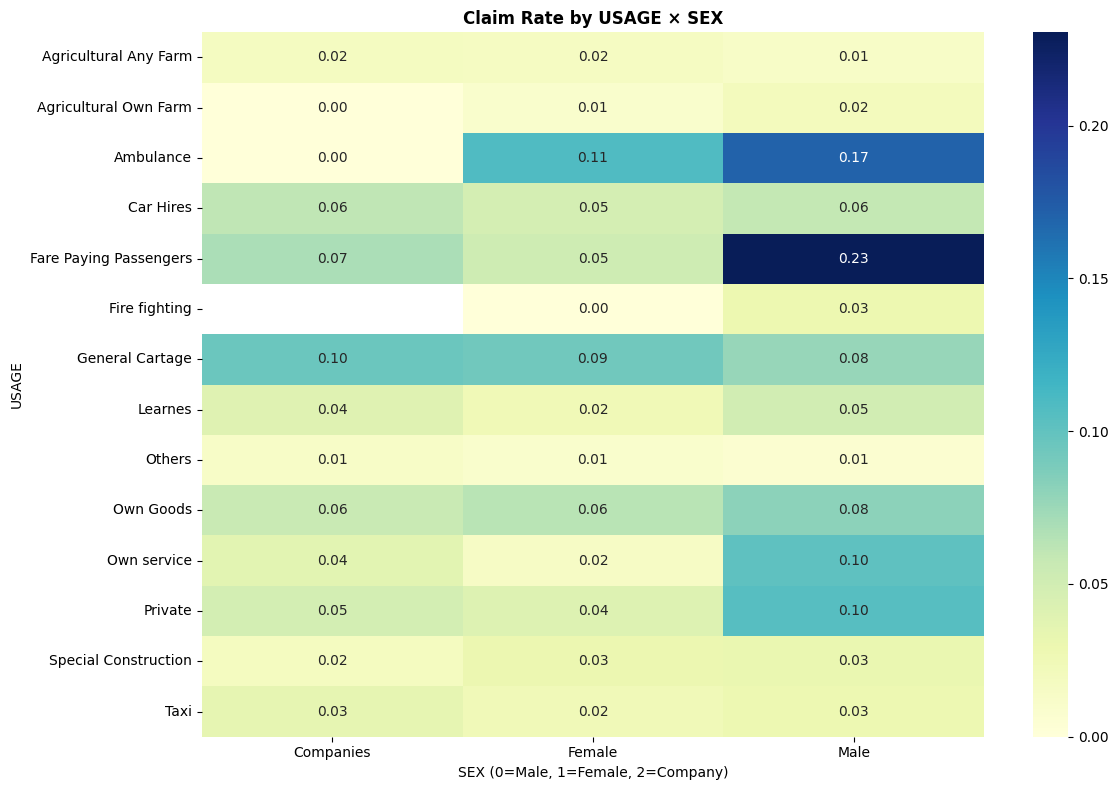

In [52]:
pivot = pd.pivot_table(df, 
                       values="CLAIM_FLAG", 
                       index="USAGE", 
                       columns="SEX", 
                       aggfunc="mean")

plt.figure(figsize=(12,8))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Claim Rate by USAGE √ó SEX", weight="bold")
plt.xlabel("SEX (0=Male, 1=Female, 2=Company)")
plt.ylabel("USAGE")
plt.tight_layout()
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### üìä ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿ± ÿßÿ≥ÿßÿ≥ ŸÜŸàÿπ ⁄©ÿßÿ±ÿ®ÿ±€å √ó ÿ¨ŸÜÿ≥€åÿ™ (Claim Rate by USAGE √ó SEX)

### üîé ŸÖÿ¥ÿßŸáÿØÿßÿ™:
1. **ÿ¢ŸÖÿ®ŸàŸÑÿßŸÜÿ≥** ÿ®ÿ±ÿß€å ŸÖÿ±ÿØÿßŸÜ (0.17) Ÿà ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß (0.11) ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿßŸÑÿß€å€å ÿØÿßÿ±ÿØÿå ÿØÿ±ÿ≠ÿßŸÑ€å‚Äå⁄©Ÿá ÿ®ÿ±ÿß€å ÿ≤ŸÜÿßŸÜ ÿ™ŸÇÿ±€åÿ®ÿßŸã ÿµŸÅÿ± ÿßÿ≥ÿ™.  
2. **ŸÖÿ≥ÿßŸÅÿ±ÿ®ÿ±€å (Fare Paying Passengers)** ÿ®ÿßŸÑÿßÿ™ÿ±€åŸÜ ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ±ÿß ÿ®ÿ±ÿß€å ŸÖÿ±ÿØÿßŸÜ (0.21) ÿØÿßÿ±ÿØÿå ⁄©Ÿá ÿßÿ≤ ŸáŸÖŸá ⁄Øÿ±ŸàŸá‚ÄåŸáÿß ÿ®€åÿ¥ÿ™ÿ± ÿßÿ≥ÿ™.  
3. ÿØÿ± **ÿÆÿØŸÖÿßÿ™ ÿ¥ÿÆÿµ€å (Own Service)** Ÿà **ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿÆÿµŸàÿµ€å (Private)** ŸÖÿ±ÿØÿßŸÜ ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ŸÜÿ≥ÿ®ÿ™ÿßŸã ÿ®ÿßŸÑÿßÿ™ÿ±€å (~0.10) ŸÜÿ≥ÿ®ÿ™ ÿ®Ÿá ÿ≤ŸÜÿßŸÜ Ÿà ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß ÿØÿßÿ±ŸÜÿØ.  
4. ÿØÿ± **⁄©ÿßŸÑÿßŸáÿß€å ÿ¥ÿÆÿµ€å (Own Goods)** ÿ™ŸÅÿßŸàÿ™ ÿ≤€åÿßÿØ€å ÿØ€åÿØŸá ŸÜŸÖ€å‚Äåÿ¥ŸàÿØÿå Ÿáÿ± ÿ≥Ÿá ⁄Øÿ±ŸàŸá ŸÜÿ±ÿÆ ŸÖÿ¥ÿßÿ®Ÿá (0.06‚Äì0.08) ÿØÿßÿ±ŸÜÿØ.  
5. **⁄©ÿ¥ÿßŸàÿ±ÿ≤€å (Agricultural Farm)** ⁄ÜŸá ÿ¥ÿÆÿµ€å Ÿà ⁄ÜŸá ÿπŸÖŸàŸÖ€åÿå ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿ≥€åÿßÿ± Ÿæÿß€å€åŸÜ (ŸÜÿ≤ÿØ€å⁄© ÿ®Ÿá ÿµŸÅÿ±) ŸÜÿ¥ÿßŸÜ ŸÖ€å‚ÄåÿØŸáÿØ.  
6. ÿØÿ± **⁄©ÿßÿ±ÿ®ÿ±€å‚ÄåŸáÿß€å Ÿà€å⁄òŸá (Special Construction, Fire Fighting, Others)** ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®Ÿá‚Äåÿ∑Ÿàÿ± ⁄©ŸÑ€å Ÿæÿß€å€åŸÜ ÿßÿ≥ÿ™ Ÿà ÿ™ŸÅÿßŸàÿ™ ÿ≤€åÿßÿØ€å ÿ®€åŸÜ ÿ¨ŸÜÿ≥€åÿ™‚ÄåŸáÿß ÿØ€åÿØŸá ŸÜŸÖ€å‚Äåÿ¥ŸàÿØ.  
7. ÿ®Ÿá‚Äåÿ∑Ÿàÿ± ⁄©ŸÑ€åÿå ŸÖÿ±ÿØÿßŸÜ ÿØÿ± ÿß⁄©ÿ´ÿ± ⁄©ÿßÿ±ÿ®ÿ±€å‚ÄåŸáÿß (ÿÆÿµŸàÿµ€åÿå ŸÖÿ≥ÿßŸÅÿ±ÿ®ÿ±€åÿå ÿÆÿØŸÖÿßÿ™ÿå ÿ¢ŸÖÿ®ŸàŸÑÿßŸÜÿ≥) ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®€åÿ¥ÿ™ÿ±€å ŸÜÿ≥ÿ®ÿ™ ÿ®Ÿá ÿ≤ŸÜÿßŸÜ Ÿà ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß ÿØÿßÿ±ŸÜÿØ.  

---

### üìå ŸÜÿ™€åÿ¨Ÿá‚Äå⁄Ø€åÿ±€å:
- **ŸÖÿ±ÿØÿßŸÜ (Male)** ÿØÿ± ⁄©ÿßÿ±ÿ®ÿ±€å‚ÄåŸáÿß€å Ÿæÿ±ÿ±€åÿ≥⁄© ŸÖÿ´ŸÑ **ÿ¢ŸÖÿ®ŸàŸÑÿßŸÜÿ≥** Ÿà **ŸÖÿ≥ÿßŸÅÿ±ÿ®ÿ±€å** ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ±ÿß ÿØÿßÿ±ŸÜÿØ.  
- **ÿ¥ÿ±⁄©ÿ™‚ÄåŸáÿß (Companies)** ÿ®€åÿ¥ÿ™ÿ± ÿØÿ± ⁄©ÿßÿ±ÿ®ÿ±€å‚ÄåŸáÿß€å ÿ™ÿ¨ÿßÿ±€å ŸÖÿ´ŸÑ **ÿ≠ŸÖŸÑ‚ÄåŸàŸÜŸÇŸÑ ÿπŸÖŸàŸÖ€å (General Cartage)** ŸÜÿ±ÿÆ ŸÖÿ™Ÿàÿ≥ÿ∑€å ÿßÿ≤ ÿÆÿ≥ÿßÿ±ÿ™ ÿØÿßÿ±ŸÜÿØ (~0.09).  
- **ÿ≤ŸÜÿßŸÜ (Female)** ÿ™ŸÇÿ±€åÿ®ÿßŸã ÿØÿ± ŸáŸÖŸá ⁄©ÿßÿ±ÿ®ÿ±€å‚ÄåŸáÿß ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ Ÿæÿß€å€åŸÜ‚Äåÿ™ÿ±€å ÿØÿßÿ±ŸÜÿØ.  
- ÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿØÿ± ÿ∑ÿ±ÿßÿ≠€å **Ÿæÿ±ŸàŸÅÿß€åŸÑ ÿ±€åÿ≥⁄© (Risk Profiling)** ÿ®ÿ±ÿß€å ÿ™ÿπ€å€åŸÜ **ŸÜÿ±ÿÆ ÿ®€åŸÖŸá (Premium Pricing)** ÿ®ÿ± ÿßÿ≥ÿßÿ≥ **⁄©ÿßÿ±ÿ®ÿ±€å ÿÆŸàÿØÿ±Ÿà Ÿà ÿ¨ŸÜÿ≥€åÿ™** ⁄©ÿßÿ±ÿ®ÿ±ÿØ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ÿØ.  

---

### üîπ  Summary:
- **Males** show the **highest claim rates** in **Ambulance (0.17)** and **Fare Paying Passengers (0.21)**.  
- **Companies** have moderate claim rates, especially in **General Cartage (0.09)**.  
- **Females** consistently have **lower claim rates** across most usages.  
- Overall, claim risk is **higher for males in risky vehicle usages**, while females and companies tend to show lower claim rates.  

</div>


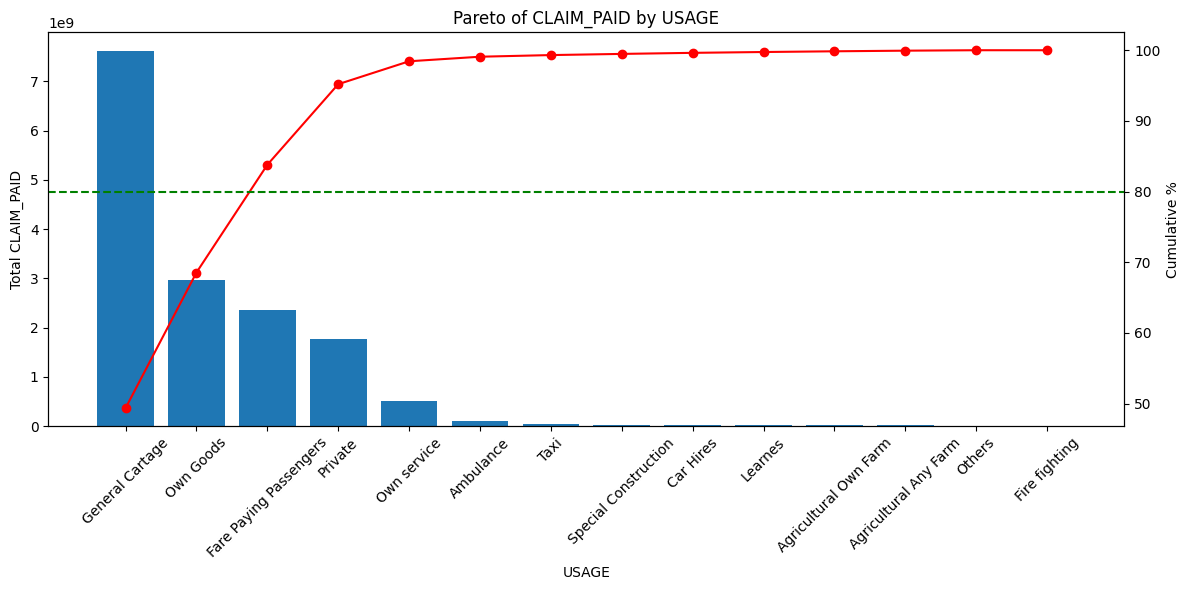

In [53]:
# ŸÖÿ¨ŸÖŸàÿπ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®Ÿá ÿ™ŸÅ⁄©€å⁄© USAGE
total_claim_usage = df.groupby("USAGE")["CLAIM_PAID"].sum().sort_values(ascending=False)

# ÿØÿ±ÿµÿØ ÿ™ÿ¨ŸÖÿπ€å
cum_pct = total_claim_usage.cumsum() / total_claim_usage.sum() * 100

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.bar(total_claim_usage.index, total_claim_usage.values)
ax1.set_ylabel("Total CLAIM_PAID")
ax1.set_xlabel("USAGE")
ax1.tick_params(axis='x', rotation=45)
ax1.set_title("Pareto of CLAIM_PAID by USAGE")

# ÿÆÿ∑ ÿ™ÿ¨ŸÖÿπ€å
ax2 = ax1.twinx()
ax2.plot(cum_pct.index, cum_pct.values, marker="o", color="red")
ax2.axhline(80, color="green", linestyle="--")
ax2.set_ylabel("Cumulative %")

plt.tight_layout()
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### üìä ÿ™ÿ≠ŸÑ€åŸÑ Ÿæÿßÿ±ÿ™Ÿà Ÿæÿ±ÿØÿßÿÆÿ™ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿ± ÿßÿ≥ÿßÿ≥ ŸÜŸàÿπ ⁄©ÿßÿ±ÿ®ÿ±€å ÿÆŸàÿØÿ±Ÿà (Pareto of CLAIM\_PAID by USAGE)

### üîé ŸÖÿ¥ÿßŸáÿØÿßÿ™:

1. ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ŸÖ€åÿ≤ÿßŸÜ ÿÆÿ≥ÿßÿ±ÿ™ Ÿæÿ±ÿØÿßÿÆÿ™€å ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá **General Cartage** ÿßÿ≥ÿ™ ⁄©Ÿá ÿ®ÿÆÿ¥ ÿπŸÖÿØŸá‚Äåÿß€å ÿßÿ≤ ⁄©ŸÑ ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß ÿ±ÿß ÿ™ÿ¥⁄©€åŸÑ ŸÖ€å‚ÄåÿØŸáÿØ.
2. Ÿæÿ≥ ÿßÿ≤ ÿ¢ŸÜÿå ⁄©ÿßÿ±ÿ®ÿ±€å‚ÄåŸáÿß€å **Own Goods**ÿå **Fare Paying Passengers** Ÿà **Private** ÿ≥ŸáŸÖ ÿ®ÿ≤ÿ±⁄Ø€å ÿØÿ± ŸÖÿ¨ŸÖŸàÿπ ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß ÿØÿßÿ±ŸÜÿØ.
3. ⁄©ÿßÿ±ÿ®ÿ±€å‚ÄåŸáÿß€å ⁄©ŸÖ‚Äåÿ™ÿπÿØÿßÿØ ŸÖÿßŸÜŸÜÿØ **Ambulanceÿå Taxiÿå Special Constructionÿå Agricultural Farm Ÿà Fire Fighting** ÿ≥ŸáŸÖ ÿ®ÿ≥€åÿßÿ± ŸÜÿß⁄Ü€åÿ≤€å ÿØÿßÿ±ŸÜÿØ.
4. ŸÜŸÖŸàÿØÿßÿ± ÿ™ÿ¨ŸÖÿπ€å (ÿÆÿ∑ ŸÇÿ±ŸÖÿ≤) ŸÜÿ¥ÿßŸÜ ŸÖ€å‚ÄåÿØŸáÿØ ⁄©Ÿá ÿ™ŸÜŸáÿß ⁄ÜŸÜÿØ ŸÜŸàÿπ ⁄©ÿßÿ±ÿ®ÿ±€å (ÿ≠ÿØŸàÿØ €¥‚Äì€µ ⁄©ÿßÿ±ÿ®ÿ±€å ÿßŸàŸÑ) ÿ®€åÿ¥ ÿßÿ≤ **€∏€∞Ÿ™ ⁄©ŸÑ ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß** ÿ±ÿß ŸæŸàÿ¥ÿ¥ ŸÖ€å‚ÄåÿØŸáŸÜÿØ.

---

### üìå ŸÜÿ™€åÿ¨Ÿá‚Äå⁄Ø€åÿ±€å:

* ÿ™ÿπÿØÿßÿØ ⁄©ŸÖ€å ÿßÿ≤ ⁄©ÿßÿ±ÿ®ÿ±€å‚ÄåŸáÿß (ÿ®Ÿá‚ÄåŸà€å⁄òŸá **General Cartage** Ÿà **Own Goods**) ŸÖÿ≥ÿ¶ŸàŸÑ ÿ®ÿÆÿ¥ ÿπŸÖÿØŸá ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß Ÿáÿ≥ÿ™ŸÜÿØ.
* ÿ™ÿ≠ŸÑ€åŸÑ ÿØŸÇ€åŸÇ‚Äåÿ™ÿ± ÿß€åŸÜ ÿØÿ≥ÿ™Ÿá‚ÄåŸáÿß ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ®ÿ±ÿß€å **ŸÖÿØ€åÿ±€åÿ™ ÿ±€åÿ≥⁄© Ÿà ÿ∑ÿ±ÿßÿ≠€å ÿ≠ŸÇ ÿ®€åŸÖŸá ÿ®Ÿá€åŸÜŸá** ÿ®ÿ≥€åÿßÿ± ŸÖÿ§ÿ´ÿ± ÿ®ÿßÿ¥ÿØ.
* ÿ≥ÿß€åÿ± ⁄©ÿßÿ±ÿ®ÿ±€å‚ÄåŸáÿß ÿ™ÿ£ÿ´€åÿ± ⁄©ŸÖ€å ÿØÿ± ŸÖÿ¨ŸÖŸàÿπ ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß ÿØÿßÿ±ŸÜÿØ Ÿà ŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÜÿØ ÿØÿ± ÿßŸàŸÑŸà€åÿ™ Ÿæÿß€å€åŸÜ‚Äåÿ™ÿ±€å ŸÇÿ±ÿßÿ± ÿ®⁄Ø€åÿ±ŸÜÿØ.

---

### üîπ  Summary:

* **General Cartage** dominates total claim payments, followed by **Own Goods, Fare Paying Passengers, and Private**.
* A small number of usage types account for over **80% of total claims (Pareto principle)**.
* These key categories should be the main focus for **risk management and premium pricing strategies**.

</div> ‚úÖ

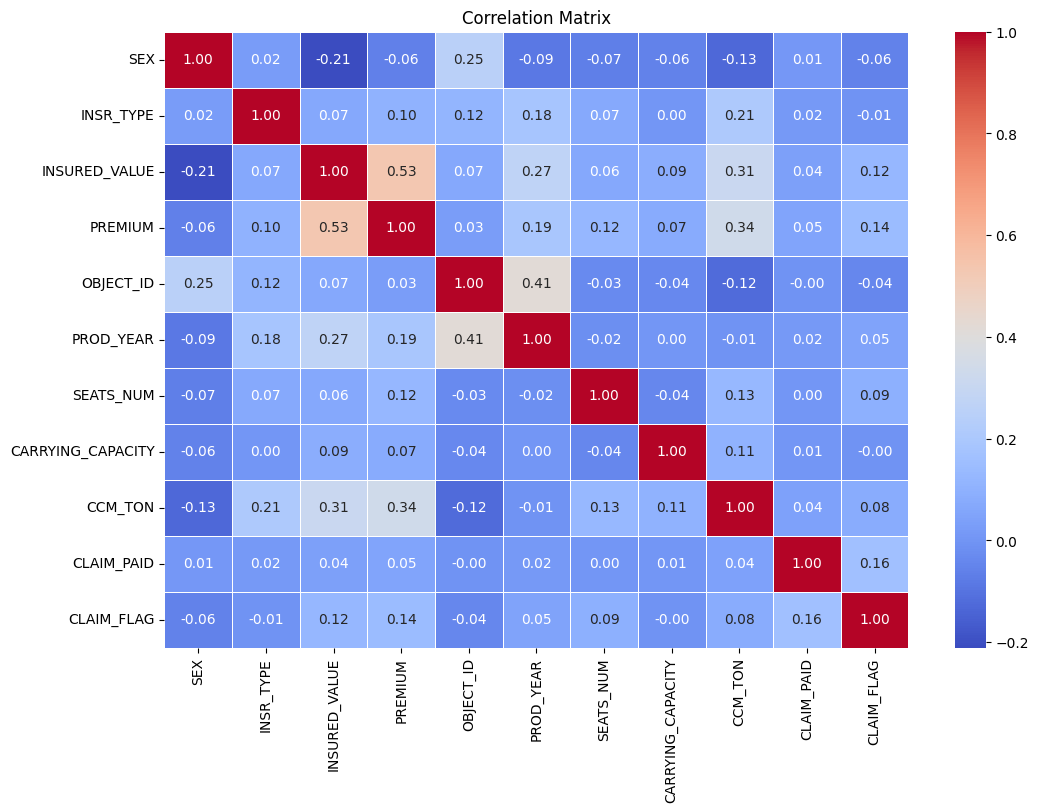

In [54]:
df['SEX'] = df['SEX'].map({'Male':0 ,'Female':1 , 'Companies':2 })
df_corr = df[numeric_cols].corr()
# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df_corr , annot=True , fmt='.2f' , cmap='coolwarm' , linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### üìä ŸÖÿßÿ™ÿ±€åÿ≥ ŸáŸÖÿ®ÿ≥ÿ™⁄Ø€å (Correlation Matrix)

### üîé ŸÖÿ¥ÿßŸáÿØÿßÿ™:

1. **INSURED\_VALUE Ÿà PREMIUM** ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ŸáŸÖÿ®ÿ≥ÿ™⁄Ø€å ŸÖÿ´ÿ®ÿ™ ÿ±ÿß ÿØÿßÿ±ŸÜÿØ (0.53) ‚Üí ÿ∑ÿ®€åÿπ€å ÿßÿ≥ÿ™ ⁄ÜŸàŸÜ ÿ≠ŸÇ ÿ®€åŸÖŸá ŸÖÿ≥ÿ™ŸÇ€åŸÖÿßŸã Ÿàÿßÿ®ÿ≥ÿ™Ÿá ÿ®Ÿá ÿßÿ±ÿ≤ÿ¥ ÿ®€åŸÖŸá‚Äåÿß€å ÿÆŸàÿØÿ±Ÿà ÿßÿ≥ÿ™.
2. **CCM\_TON** ŸÜ€åÿ≤ ŸáŸÖÿ®ÿ≥ÿ™⁄Ø€å ŸÇÿßÿ®ŸÑ ÿ™Ÿàÿ¨Ÿá€å ÿ®ÿß **PREMIUM (0.34)** Ÿà **INSURED\_VALUE (0.31)** ÿØÿßÿ±ÿØ ‚Üí ÿÆŸàÿØÿ±ŸàŸáÿß€å ÿ≥ŸÜ⁄Ø€åŸÜ‚Äåÿ™ÿ± Ÿà Ÿæÿ±ŸÇÿØÿ±ÿ™‚Äåÿ™ÿ± ŸÖÿπŸÖŸàŸÑÿßŸã ÿßÿ±ÿ≤ÿ¥ ÿ®ÿßŸÑÿßÿ™ÿ± Ÿà ÿ≠ŸÇ ÿ®€åŸÖŸá ÿ®€åÿ¥ÿ™ÿ±€å ÿØÿßÿ±ŸÜÿØ.
3. **CLAIM\_PAID** ŸáŸÖÿ®ÿ≥ÿ™⁄Ø€å ÿ®ÿ≥€åÿßÿ± ÿ∂ÿπ€åŸÅ€å ÿ®ÿß ÿ≥ÿß€åÿ± ŸÖÿ™ÿ∫€åÿ±Ÿáÿß ÿØÿßÿ±ÿØ (ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ŸÖŸÇÿØÿßÿ± 0.16 ÿ®ÿß CLAIM\_FLAG).
4. ŸÖÿ™ÿ∫€åÿ± **SEX** ÿ™ŸÇÿ±€åÿ®ÿßŸã ÿßÿ±ÿ™ÿ®ÿßÿ∑ ŸÖÿπŸÜÿßÿØÿßÿ±€å ÿ®ÿß ÿ≥ÿß€åÿ± ŸÖÿ™ÿ∫€åÿ±Ÿáÿß€å ÿπÿØÿØ€å ŸÜÿØÿßÿ±ÿØ.

---

### üìå ŸÜÿ™€åÿ¨Ÿá‚Äå⁄Ø€åÿ±€å:

* ŸÖÿØŸÑ‚ÄåŸáÿß€å Ÿæ€åÿ¥‚Äåÿ®€åŸÜ€å ÿÆÿ≥ÿßÿ±ÿ™ ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÜÿØ ÿ™ŸÜŸáÿß ÿ®ÿ± ÿßÿ≥ÿßÿ≥ Ÿà€å⁄ò⁄Ø€å‚ÄåŸáÿß€å **ÿÆŸàÿØÿ±Ÿà** (Year, CCM, Seats, Value) ÿØŸÇÿ™ ÿ®ÿßŸÑÿß€å€å ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ŸÜÿØÿå ⁄ÜŸàŸÜ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®€åÿ¥ÿ™ÿ± ÿ®Ÿá ÿ¥ÿ±ÿß€åÿ∑ ÿ≠ÿßÿØÿ´Ÿá ÿ®ÿ≥ÿ™⁄Ø€å ÿØÿßÿ±ÿØ.
* ŸÖŸáŸÖ‚Äåÿ™ÿ±€åŸÜ ÿ±ÿßÿ®ÿ∑Ÿá ÿ≥ÿßÿÆÿ™ÿßÿ±€å ÿØÿ± ÿØÿßÿØŸá‚ÄåŸáÿßÿå ÿßÿ±ÿ™ÿ®ÿßÿ∑ ÿ®€åŸÜ **INSURED\_VALUE Ÿà PREMIUM** ÿßÿ≥ÿ™.
* ÿ®ÿ±ÿß€å Ÿæ€åÿ¥‚Äåÿ®€åŸÜ€å ÿÆÿ≥ÿßÿ±ÿ™ÿå ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿØÿßÿØŸá‚ÄåŸáÿß€å ÿ™⁄©ŸÖ€åŸÑ€å ŸÖÿ´ŸÑ **ŸÜŸàÿπ ÿ≠ÿßÿØÿ´Ÿáÿå ÿ¥ÿ±ÿß€åÿ∑ ÿ¨ÿßÿØŸá Ÿà ÿ±ÿßŸÜŸÜÿØŸá** Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ.

---

### üîπ  Summary:

* Strongest correlation: **Insured Value ‚Üî Premium (0.53)**.
* Moderate correlation: **CCM\_TON ‚Üî Premium (0.34)** and **CCM\_TON ‚Üî Insured Value (0.31)**.
* **Claim Paid** shows very weak correlations (max 0.16 with Claim Flag).
* Vehicle-related attributes are not strong predictors of claim severity.

</div>  

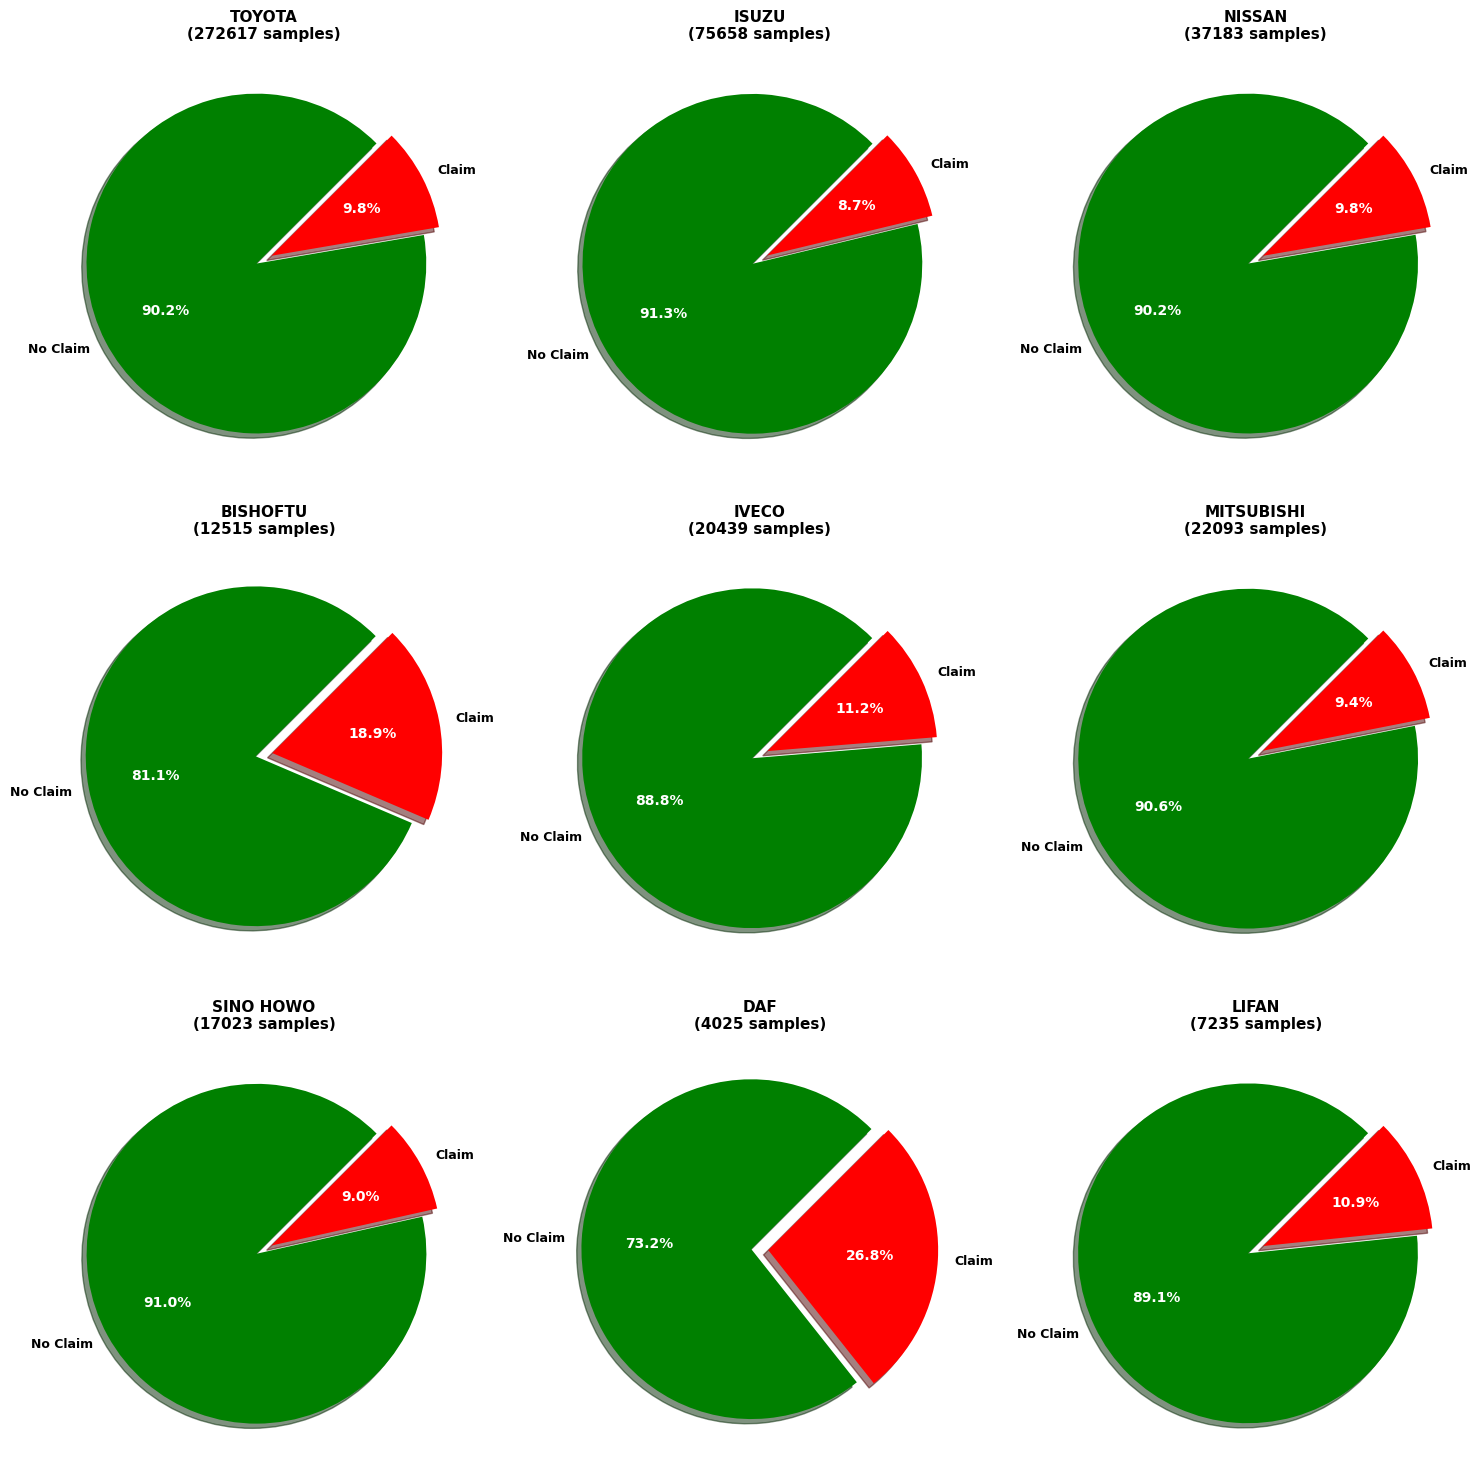

In [55]:
# Select top 9 car makes with the highest number of claims (CLAIM_FLAG=1)
top_claim_makes = (
    df[df["CLAIM_FLAG"] == 1]["MAKE"]
    .value_counts()
    .head(9)
    .index
)

# Define grid layout: 3 plots per row
cols = 3
rows = (len(top_claim_makes) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
axes = axes.flatten()

for i, make in enumerate(top_claim_makes):
    subset = df[df["MAKE"] == make]
    counts = subset["CLAIM_FLAG"].value_counts()

    labels = ["No Claim", "Claim"]
    values = [counts.get(0,0), counts.get(1,0)]
    explode = (0.05, 0.05)

    wedges, texts, autotexts = axes[i].pie(
        values,
        labels=labels,
        autopct="%1.1f%%",
        startangle=45,
        colors=["green", "red"],
        pctdistance=0.6,
        explode=explode,
        shadow=True
    )

    # Style percentage texts (white, bold)
    for autotext in autotexts:
        autotext.set_color("white")
        autotext.set_fontsize(10)
        autotext.set_weight("bold")

    # Style labels
    for text in texts:
        text.set_fontsize(9)
        text.set_weight("bold")

    axes[i].set_title(f"{make}\n({len(subset)} samples)", fontsize=11, weight="bold")

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### üìä ÿ™ÿ≠ŸÑ€åŸÑ ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿ± ÿßÿ≥ÿßÿ≥ ÿ®ÿ±ŸÜÿØ ÿÆŸàÿØÿ±Ÿà (Claim Rate by Make)

### üîé ŸÖÿ¥ÿßŸáÿØÿßÿ™ (Insights):
- **⁄©ŸÖ‚Äåÿ±€åÿ≥⁄©‚ÄåŸáÿß:**  
  **ISUZU 8.6%**ÿå **SINO HOWO 8.8%**ÿå **MITSUBISHI 9.3%**ÿå **TOYOTA 9.7%** Ÿà **NISSAN 9.7%** ‚Üí ÿ≥ŸáŸÖ ÿÆÿ≥ÿßÿ±ÿ™ Ÿæÿß€å€åŸÜ Ÿà Ÿæÿß€åÿØÿßÿ±.
- **ŸÖ€åÿßŸÜ‚Äåÿ±ÿØŸá:**  
  **IVECO 11.0%** Ÿà **LIFAN 10.9%** ŸÜÿ≤ÿØ€å⁄© ÿ®Ÿá ŸÖ€åÿßŸÜ⁄Ø€åŸÜ ⁄©ŸÑ Ÿáÿ≥ÿ™ŸÜÿØ.
- **ŸæŸèÿ±ÿ±€åÿ≥⁄©‚ÄåŸáÿß:**  
  **DAF 24.7%** (€¥,€∞€≤€µ ŸÜŸÖŸàŸÜŸá) Ÿà **BISHOFTU 17.8%** (€±€≤,€µ€±€µ ŸÜŸÖŸàŸÜŸá) ÿ®Ÿá‚Äåÿ∑Ÿàÿ± ŸÖÿπŸÜÿßÿØÿßÿ± ÿ®ÿßŸÑÿßÿ™ÿ± ÿßÿ≤ ÿ≥ÿß€åÿ± ÿ®ÿ±ŸÜÿØŸáÿß Ÿáÿ≥ÿ™ŸÜÿØ.
- **ÿ≠ÿ¨ŸÖ ŸÜŸÖŸàŸÜŸá (ÿ®ÿ±ÿß€å ÿßÿπÿ™ŸÖÿßÿØ ÿ®Ÿá ŸÜÿ™ÿß€åÿ¨):**  
  **TOYOTA 272,617**ÿå **ISUZU 75,658**ÿå **NISSAN 37,183** ‚Üí ŸÜÿ™ÿß€åÿ¨ ÿß€åŸÜ ÿ®ÿ±ŸÜÿØŸáÿß **ŸÖÿπÿ™ÿ®ÿ±ÿ™ÿ±** ÿßÿ≤ ÿ®ÿ±ŸÜÿØŸáÿß€å ⁄©ŸÖ‚ÄåŸÜŸÖŸàŸÜŸá ŸÖÿ´ŸÑ **DAF** ÿßÿ≥ÿ™.

---

### üìå ŸÜÿ™€åÿ¨Ÿá‚Äå⁄Ø€åÿ±€å / Ÿæ€åÿ¥ŸÜŸáÿßÿØŸáÿß:
- ÿ®ÿ±ÿß€å **DAF** Ÿà **BISHOFTU** ÿ≥€åÿßÿ≥ÿ™ **ŸÇ€åŸÖÿ™‚Äå⁄Øÿ∞ÿßÿ±€å ŸÖÿ®ÿ™ŸÜ€å ÿ®ÿ± ÿ±€åÿ≥⁄©** €åÿß **ÿßÿ±ÿ≤€åÿßÿ®€å ÿ≥ÿÆÿ™‚Äå⁄Ø€åÿ±ÿßŸÜŸá‚Äåÿ™ÿ±** ÿßÿπŸÖÿßŸÑ ÿ¥ŸàÿØ.  
- ÿ®ÿ±ÿß€å **ISUZU** Ÿà **SINO HOWO** ŸÖ€å‚Äåÿ™ŸàÿßŸÜ **ÿ™ÿÆŸÅ€åŸÅ ŸàŸÅÿßÿØÿßÿ±€å/⁄©ŸÖ‚Äåÿ±€åÿ≥⁄©** €åÿß ÿ®ÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ÿ™ÿ¥Ÿà€åŸÇ€å ÿØÿ± ŸÜÿ∏ÿ± ⁄Øÿ±ŸÅÿ™.  
- ÿ±ŸàŸÜÿØ ÿ®ÿ±ŸÜÿØŸáÿß€å ⁄©ŸÖ‚ÄåŸÜŸÖŸàŸÜŸá (ŸÖÿ´ŸÑ **DAF**) **Ÿæÿß€åÿ¥** ÿ¥ŸàÿØ Ÿà ÿ®ÿß ÿØÿßÿØŸá‚ÄåŸáÿß€å ÿ®€åÿ¥ÿ™ÿ± ÿ®ÿßÿ≤ÿ®€åŸÜ€å ⁄Øÿ±ÿØÿØ.

---

</div>

<div dir="ltr" style="text-align:left; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### üîπ  Summary

### Observations:
- **Low risk:** ISUZU **8.6%**, SINO HOWO **8.8%**, MITSUBISHI **9.3%**, TOYOTA **9.7%**, NISSAN **9.7%**.  
- **Mid tier:** IVECO **11.0%**, LIFAN **10.9%**.  
- **High risk:** DAF **24.7%** (4,025 samples), BISHOFTU **17.8%** (12,515 samples).  
- **Sample size check:** Very large counts for TOYOTA (272,617), ISUZU (75,658), NISSAN (37,183) ‚Üí more reliable than small-sample makes like DAF.

### Actions:
- Apply **risk-based pricing / stricter underwriting** for **DAF** and **BISHOFTU**.  
- Offer **loyalty/low-risk discounts** for **ISUZU** and **SINO HOWO**.  
- **Monitor** small-sample brands (e.g., DAF) and revalidate as more data arrives.

</div>


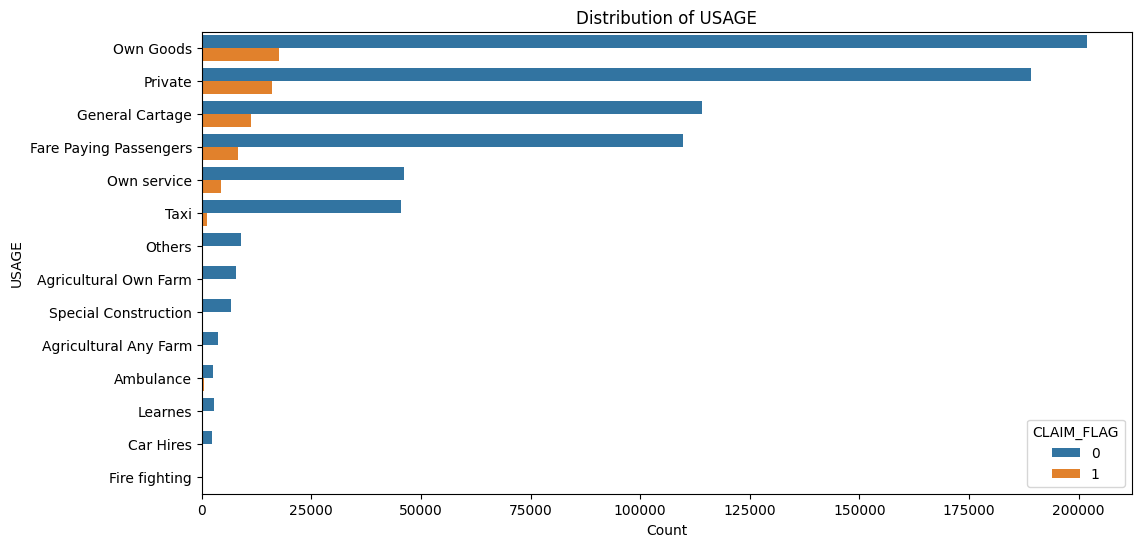

In [56]:
# Plot the count of each USAGE category in descending order with hue for CLAIM_FLAG
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='USAGE', order=df['USAGE'].value_counts().index, hue='CLAIM_FLAG')
plt.title('Distribution of USAGE')
plt.xlabel('Count')
plt.ylabel('USAGE')
plt.legend(title='CLAIM_FLAG')
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif;">

### üìä ÿ™Ÿàÿ≤€åÿπ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿÆŸàÿØÿ±ŸàŸáÿß (Distribution of Usage)

### üîé ŸÖÿ¥ÿßŸáÿØÿßÿ™:

1. **ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ÿ≠ÿ¨ŸÖ ÿÆŸàÿØÿ±ŸàŸáÿß** ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ÿØŸà ⁄Øÿ±ŸàŸá ÿßÿµŸÑ€å ÿßÿ≥ÿ™:  
   - **Own Goods**  
   - **Private**  
   ÿß€åŸÜ ÿØŸà ⁄Øÿ±ŸàŸá ÿ®€åÿ¥ ÿßÿ≤ ÿ≥ÿß€åÿ± ÿØÿ≥ÿ™Ÿá‚ÄåŸáÿß ÿØÿ± ÿØÿßÿØŸá‚ÄåŸáÿß ÿØ€åÿØŸá ŸÖ€å‚Äåÿ¥ŸàŸÜÿØ.  
   
2. ÿØÿ± ÿØÿ≥ÿ™Ÿá‚ÄåŸáÿß€å **General Cartage** Ÿà **Fare Paying Passengers** ŸÜ€åÿ≤ ÿ≠ÿ¨ŸÖ ÿ®ÿßŸÑÿß€å€å ÿßÿ≤ ÿÆŸàÿØÿ±ŸàŸáÿß ÿ´ÿ®ÿ™ ÿ¥ÿØŸá ÿßÿ≥ÿ™ ⁄©Ÿá ÿ®€åÿßŸÜ⁄Øÿ± ŸÜŸÇÿ¥ ÿ™ÿ¨ÿßÿ±€å Ÿà ÿπŸÖŸàŸÖ€å ÿß€åŸÜ ÿÆŸàÿØÿ±ŸàŸáÿß ÿßÿ≥ÿ™.  

3. ÿØÿ≥ÿ™Ÿá‚ÄåŸáÿß€å **Own Service** Ÿà **Taxi** ÿ≥ŸáŸÖ ŸÖÿ™Ÿàÿ≥ÿ∑€å ÿØÿßÿ±ŸÜÿØÿå ÿßŸÖÿß ŸáŸÖ⁄ÜŸÜÿßŸÜ ŸÇÿßÿ®ŸÑ ÿ™Ÿàÿ¨Ÿá Ÿáÿ≥ÿ™ŸÜÿØ.  

4. ÿØÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ÿÆÿßÿµ ŸÖÿ´ŸÑ **Ambulance**ÿå **Fire Fighting** Ÿà **Learners** ÿ≥ŸáŸÖ ÿ®ÿ≥€åÿßÿ± Ÿæÿß€å€åŸÜ€å ÿØÿßÿ±ŸÜÿØ ⁄©Ÿá ŸÖŸÜÿ∑ŸÇ€å ÿßÿ≥ÿ™ ⁄ÜŸàŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿ¢ŸÜ‚ÄåŸáÿß ŸÖÿ≠ÿØŸàÿØ Ÿà ÿ™ÿÆÿµÿµ€å ÿßÿ≥ÿ™.  

5. ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß (ŸÜŸàÿßÿ±Ÿáÿß€å ŸÜÿßÿ±ŸÜÿ¨€å) ÿØÿ± ÿ®ÿπÿ∂€å ÿØÿ≥ÿ™Ÿá‚ÄåŸáÿß ŸÖÿßŸÜŸÜÿØ **Taxi** Ÿà **Fare Paying Passengers** ŸÜÿ≥ÿ®ÿ™ ÿ®Ÿá ÿßŸÜÿØÿßÿ≤Ÿá ⁄©ŸÑ ŸÜŸÖŸàŸÜŸá ÿ®€åÿ¥ÿ™ÿ± ÿØ€åÿØŸá ŸÖ€å‚Äåÿ¥ŸàÿØ. ÿß€åŸÜ ŸÜÿ¥ÿßŸÜ ŸÖ€å‚ÄåÿØŸáÿØ ÿÆŸàÿØÿ±ŸàŸáÿß€å ÿπŸÖŸàŸÖ€å Ÿà ÿ≠ŸÖŸÑ‚ÄåŸàŸÜŸÇŸÑ€å ÿ±€åÿ≥⁄© ÿ®ÿßŸÑÿßÿ™ÿ±€å ÿØÿ± ÿÆÿ≥ÿßÿ±ÿ™ ÿØÿßÿ±ŸÜÿØ.  

---

### üéØ ŸÜÿ™€åÿ¨Ÿá‚Äå⁄Ø€åÿ±€å:

- **ÿÆŸàÿØÿ±ŸàŸáÿß€å ÿ¥ÿÆÿµ€å Ÿà ÿ≠ŸÖŸÑ ÿ®ÿßÿ± (Private Ÿà Own Goods)** ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ÿ≥ŸáŸÖ ÿ±ÿß ÿØÿ± ⁄©ŸÑ ÿØÿßÿØŸá‚ÄåŸáÿß ÿØÿßÿ±ŸÜÿØ Ÿà ÿ®ŸÜÿßÿ®ÿ±ÿß€åŸÜ ÿ®ÿ±ÿß€å ÿ™ÿ≠ŸÑ€åŸÑ ÿ±€åÿ≥⁄© ÿ®€åŸÖŸáÿå ÿ™ŸÖÿ±⁄©ÿ≤ ÿ®ÿ± ÿß€åŸÜ ÿØŸà ⁄Øÿ±ŸàŸá ÿ∂ÿ±Ÿàÿ±€å ÿßÿ≥ÿ™.  
- **ÿÆŸàÿØÿ±ŸàŸáÿß€å ÿπŸÖŸàŸÖ€å (Taxi Ÿà ŸÖÿ≥ÿßŸÅÿ±ÿ®ÿ±€å)** ÿ®ÿß ÿß€åŸÜ⁄©Ÿá ÿ≥ŸáŸÖ ⁄©ŸÖÿ™ÿ±€å ŸÜÿ≥ÿ®ÿ™ ÿ®Ÿá ÿÆŸàÿØÿ±ŸàŸáÿß€å ÿ¥ÿÆÿµ€å ÿØÿßÿ±ŸÜÿØÿå ŸàŸÑ€å ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ ÿØÿ± ÿ¢ŸÜ‚ÄåŸáÿß ÿ®€åÿ¥ÿ™ÿ± ÿßÿ≥ÿ™. ÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ ÿ®ÿ±ÿß€å ŸÇ€åŸÖÿ™‚Äå⁄Øÿ∞ÿßÿ±€å ÿ®€åŸÖŸá ÿ®ÿß€åÿØ ÿØÿ± ŸÜÿ∏ÿ± ⁄Øÿ±ŸÅÿ™Ÿá ÿ¥ŸàÿØ.  
- ÿØÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ÿÆÿßÿµ ŸÖÿßŸÜŸÜÿØ **Ambulance** Ÿà **Fire Fighting** ÿ®Ÿá ÿØŸÑ€åŸÑ ÿ≠ÿ¨ŸÖ Ÿæÿß€å€åŸÜ ÿØÿßÿØŸáÿå ŸÜ€åÿßÿ≤ŸÖŸÜÿØ ÿ™ÿ≠ŸÑ€åŸÑ ÿ¨ÿØÿß⁄ØÿßŸÜŸá Ÿáÿ≥ÿ™ŸÜÿØ Ÿà ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÜÿØ ŸÖÿπ€åÿßÿ± ÿßÿµŸÑ€å ÿ™ÿµŸÖ€åŸÖ‚Äå⁄Ø€åÿ±€å ÿ®ÿßÿ¥ŸÜÿØ.  

---

### üìä Distribution of Vehicle Usage (English)

### üîé Insights:

1. The **largest share of vehicles** belongs to:  
   - **Own Goods**  
   - **Private**  
   These two categories dominate the dataset.  

2. **General Cartage** and **Fare Paying Passengers** also have significant volumes, highlighting their commercial and public roles.  

3. **Own Service** and **Taxi** categories have medium representation but remain notable.  

4. Special categories like **Ambulance**, **Fire Fighting**, and **Learners** have very small shares, which is expected due to their specialized usage.  

5. The **claim rates (orange bars)** appear higher in categories such as **Taxi** and **Fare Paying Passengers**, indicating higher insurance risk for public and commercial vehicles.  

---

### üéØ Conclusion:

- **Private and Own Goods vehicles** form the majority and should be the main focus in insurance risk analysis.  
- **Public vehicles (Taxi, Fare Paying Passengers)** show **higher claim rates**, which must be reflected in pricing and risk modeling.  
- **Special categories (Ambulance, Fire Fighting)**, due to their limited size, require separate treatment and should not drive the overall risk models.  

</div>


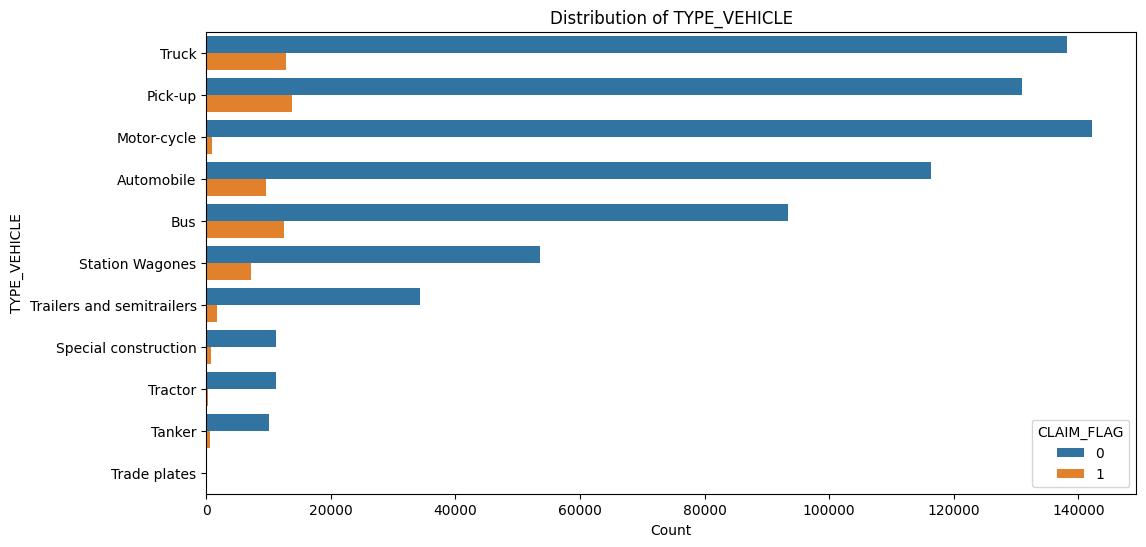

In [57]:
# Plot the count of each TYPE_VEHICLE category in descending order with hue for CLAIM_FLAG
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='TYPE_VEHICLE', order=df['TYPE_VEHICLE'].value_counts().index, hue='CLAIM_FLAG')
plt.title('Distribution of TYPE_VEHICLE')
plt.xlabel('Count')
plt.ylabel('TYPE_VEHICLE')
plt.legend(title='CLAIM_FLAG')
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### üìä ÿ™Ÿàÿ≤€åÿπ ŸÜŸàÿπ Ÿàÿ≥€åŸÑŸá ŸÜŸÇŸÑ€åŸá (TYPE_VEHICLE)

### üîé ŸÖÿ¥ÿßŸáÿØÿßÿ™:
1. **Truck (⁄©ÿßŸÖ€åŸàŸÜ)** ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ÿ™ÿπÿØÿßÿØ ÿ±ÿß ÿØÿ± ŸæŸàÿ±ÿ™ŸÅŸà ÿØÿßÿ±ÿØ Ÿà ÿ≥ŸáŸÖ **ÿÆÿ≥ÿßÿ±ÿ™** ÿØÿ± ÿß€åŸÜ ⁄Øÿ±ŸàŸá ŸáŸÖ ŸÇÿßÿ®ŸÑ‚Äåÿ™Ÿàÿ¨Ÿá ÿßÿ≥ÿ™ ‚Üí ŸÜŸÇÿ∑Ÿá‚Äå€å ÿßÿµŸÑ€å ÿ±€åÿ≥⁄©.  
2. **Pick-up (ŸàÿßŸÜÿ™)** Ÿà **Motor-cycle (ŸÖŸàÿ™Ÿàÿ±ÿ≥€å⁄©ŸÑÿ™)** ÿßÿ≤ ŸÜÿ∏ÿ± ÿ™ÿπÿØÿßÿØ ÿØÿ± ÿ±ÿ™ÿ®Ÿá‚ÄåŸáÿß€å ÿ®ÿπÿØ€å Ÿáÿ≥ÿ™ŸÜÿØÿõ ÿØÿ± ÿ≠ÿßŸÑ€å‚Äå⁄©Ÿá ÿ≥ŸáŸÖ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿ±ÿß€å ŸàÿßŸÜÿ™ ⁄Üÿ¥ŸÖ⁄Ø€åÿ±ÿ™ÿ± ÿßÿ≤ ŸÖŸàÿ™Ÿàÿ±ÿ≥€å⁄©ŸÑÿ™ ÿßÿ≥ÿ™ (ÿØÿ± ŸÖŸàÿ™Ÿàÿ±ÿ≥€å⁄©ŸÑÿ™‚ÄåŸáÿß ŸÜÿ≥ÿ®ÿ™ ŸÜŸàÿßÿ± Claim ⁄©Ÿà⁄Ü⁄©‚Äåÿ™ÿ± ÿßÿ≥ÿ™).  
3. **Automobile (ÿ≥Ÿàÿßÿ±€å)** Ÿà **Bus (ÿßÿ™Ÿàÿ®Ÿàÿ≥)** ÿ≠ÿ¨ŸÖ ÿ®ÿßŸÑÿß€å€å ÿØÿßÿ±ŸÜÿØÿõ ÿßÿ™Ÿàÿ®Ÿàÿ≥‚ÄåŸáÿß ŸÜÿ≥ÿ®ÿ™ ÿ®Ÿá ÿ≠ÿ¨ŸÖ ÿÆŸàÿØ **ÿ≥ŸáŸÖ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿ±ÿ¨ÿ≥ÿ™Ÿá‚Äåÿ™ÿ±€å** ŸÜÿ¥ÿßŸÜ ŸÖ€å‚ÄåÿØŸáŸÜÿØ (ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿπŸÖŸàŸÖ€å/ÿπŸÖŸÑ€åÿßÿ™€å).  
4. ⁄Øÿ±ŸàŸá‚ÄåŸáÿß€å ŸÖ€åÿßŸÜ€å ŸÖÿ´ŸÑ **Station Wagons** Ÿà **Trailers & Semitrailers** ÿ≠ÿ¨ŸÖ ŸÖÿ™Ÿàÿ≥ÿ∑ ÿØÿßÿ±ŸÜÿØ Ÿà ŸÜÿ≥ÿ®ÿ™ ÿÆÿ≥ÿßÿ±ÿ™ÿ¥ÿßŸÜ ŸÜÿ≥ÿ®ÿ™ÿßŸã Ÿæÿß€å€åŸÜ‚Äåÿ™ÿ± ÿ®Ÿá ŸÜÿ∏ÿ± ŸÖ€å‚Äåÿ±ÿ≥ÿØ.  
5. ÿØÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ⁄©ŸÖ‚Äåÿ≠ÿ¨ŸÖ ŸÖÿßŸÜŸÜÿØ **Tractor, Tanker, Special Construction** ÿ≠ÿ∂Ÿàÿ± ÿßŸÜÿØ⁄©€å ÿØÿßÿ±ŸÜÿØ Ÿà ÿßÿ´ÿ± ⁄©ŸÖ€å ÿ®ÿ± ÿ±€åÿ≥⁄© ⁄©ŸÑ Ÿæÿ±ÿ™ŸÅŸà€å ŸÖ€å‚Äå⁄Øÿ∞ÿßÿ±ŸÜÿØ.

---

### üß≠ ŸÜÿ™€åÿ¨Ÿá‚Äå⁄Ø€åÿ±€å/ÿßŸÇÿØÿßŸÖÿßÿ™:
- **ÿ™ŸÖÿ±⁄©ÿ≤ ŸÖÿØ€åÿ±€åÿ™ ÿ±€åÿ≥⁄© Ÿà ŸÇ€åŸÖÿ™‚Äå⁄Øÿ∞ÿßÿ±€å** ÿ±Ÿà€å **Truckÿå Pick-up Ÿà Bus** ÿ∂ÿ±Ÿàÿ±€å ÿßÿ≥ÿ™ (ÿ±€åÿ≥⁄© ÿπŸÖŸÑ€åÿßÿ™€å/ÿßÿ≥ÿ™ŸÅÿßÿØŸá‚Äå€å ÿ≥ŸÜ⁄Ø€åŸÜ).  
- **ŸÖŸàÿ™Ÿàÿ±ÿ≥€å⁄©ŸÑÿ™‚ÄåŸáÿß** ÿ®ÿß Ÿàÿ¨ŸàÿØ ÿ™ÿπÿØÿßÿØ ÿ≤€åÿßÿØÿå **ŸÜÿ≥ÿ®ÿ™ ÿÆÿ≥ÿßÿ±ÿ™ Ÿæÿß€å€åŸÜ‚Äåÿ™ÿ±€å** ÿØÿ± ŸÜŸÖŸàÿØÿßÿ± ÿØÿßÿ±ŸÜÿØÿõ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÜÿ¥ÿßŸÜ‚ÄåÿØŸáŸÜÿØŸá‚Äå€å ÿ¥ÿØÿ™ ⁄©ŸÖÿ™ÿ± €åÿß ÿßŸÑ⁄ØŸà€å ŸÖÿ™ŸÅÿßŸàÿ™ ÿÆÿ≥ÿßÿ±ÿ™ ÿ®ÿßÿ¥ÿØ (ÿ®ÿ±ÿ±ÿ≥€å ÿ≥ÿ±ŸÇÿ™/ÿ®ÿØŸÜŸá‚Äå€å ÿÆÿ±ÿØ ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ).  
- ⁄Øÿ±ŸàŸá‚ÄåŸáÿß€å ⁄©ŸÖ‚Äåÿ≠ÿ¨ŸÖ ÿ±ÿß ÿ®Ÿá‚ÄåÿµŸàÿ±ÿ™ **ŸÖÿØŸÑ‚ÄåŸáÿß€å ÿ¨ÿØÿß⁄ØÿßŸÜŸá/ÿ≠ÿØÿßŸÇŸÑ€å** ÿØÿ± ŸÜÿ∏ÿ± ÿ®⁄Ø€åÿ±€åÿØÿõ ŸÖÿ≠ÿ±⁄© ÿ±€åÿ≥⁄© ⁄©ŸÑ ŸÜ€åÿ≥ÿ™ŸÜÿØ.

---

### üîπ  Summary

### üîé Insights:
1. **Trucks** dominate the portfolio and also show a **sizeable claim share** ‚Üí primary risk driver.  
2. **Pick-ups** and **Motor-cycles** are next in volume; claim share is **more noticeable for pick-ups** than for motor-cycles.  
3. **Automobiles** and **Buses** are large segments; **buses** exhibit a **higher relative claim share** due to public/operational exposure.  
4. **Station Wagons** and **Trailers & Semitrailers** sit in the mid-tier with relatively **lower claim ratios**.  
5. **Tractors, Tankers, Special Construction** are niche categories with **limited impact** on portfolio-level risk.

### üéØ Actions:
- Prioritize **pricing & risk controls** for **Trucks, Pick-ups, Buses**.  
- For **Motor-cycles**, investigate claim composition (e.g., theft vs. minor damage) given the **lower observed claim ratio**.  
- Treat small categories with **lightweight/segmented models** rather than letting them drive portfolio decisions.

</div>


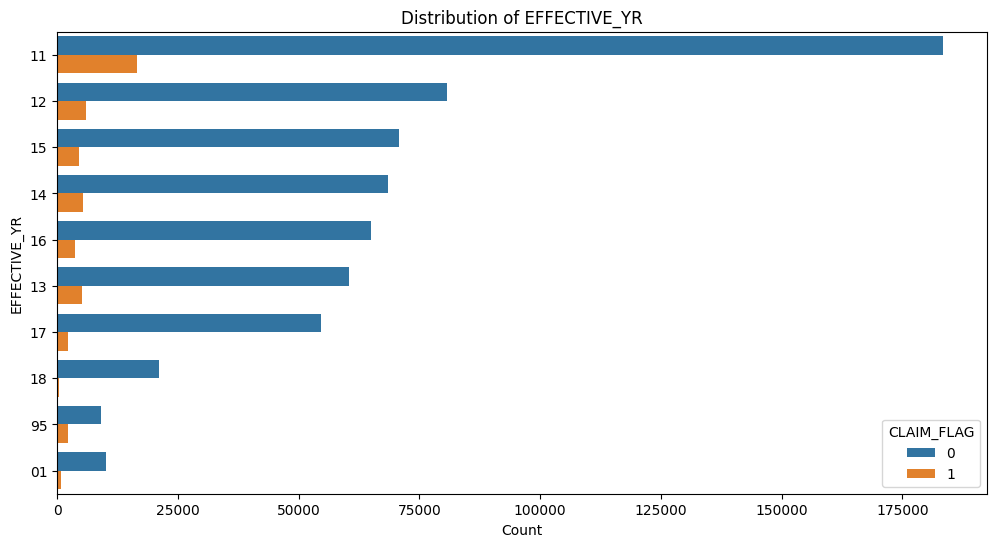

In [58]:
# Plot the count of each EFFECTIVE_YR category in descending order with hue for CLAIM_FLAG
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='EFFECTIVE_YR', order=df['EFFECTIVE_YR'].value_counts(ascending=False).head(10).index, hue='CLAIM_FLAG')
plt.title('Distribution of EFFECTIVE_YR')
plt.xlabel('Count')
plt.ylabel('EFFECTIVE_YR')
plt.legend(title='CLAIM_FLAG')
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### üìä ÿ™ÿ≠ŸÑ€åŸÑ ÿ™Ÿàÿ≤€åÿπ ÿ≥ÿßŸÑ ÿ®€åŸÖŸá (EFFECTIVE_YR)

### üîé ŸÖÿ¥ÿßŸáÿØÿßÿ™:
1. **ÿ™ŸÖÿ±⁄©ÿ≤ ÿ®ÿßŸÑÿß ÿØÿ± ÿ≥ÿßŸÑ 11**  
   ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ÿ™ÿπÿØÿßÿØ ÿ®€åŸÖŸá‚ÄåŸÜÿßŸÖŸá‚ÄåŸáÿß ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ÿ≥ÿßŸÑ 11 ÿßÿ≥ÿ™. ÿß€åŸÜ ŸÜÿ¥ÿßŸÜ ŸÖ€å‚ÄåÿØŸáÿØ ⁄©Ÿá ÿØÿ± ÿ¢ŸÜ ÿ≥ÿßŸÑ ÿ≠ÿ¨ŸÖ ÿ®ÿßŸÑÿß€å€å ÿßÿ≤ ŸÇÿ±ÿßÿ±ÿØÿßÿØŸáÿß ÿ®ÿ≥ÿ™Ÿá ÿ¥ÿØŸá €åÿß ÿ≥€åÿ≥ÿ™ŸÖ ÿ´ÿ®ÿ™ ÿ®€åŸÖŸá ÿ®Ÿá‚Äåÿ∑Ÿàÿ± ÿ¨ÿØ€å ⁄Øÿ≥ÿ™ÿ±ÿ¥ €åÿßŸÅÿ™Ÿá ÿßÿ≥ÿ™.  

2. **⁄©ÿßŸáÿ¥ ÿ™ÿØÿ±€åÿ¨€å ÿ®ÿπÿØ ÿßÿ≤ ÿ≥ÿßŸÑ 12 ÿ™ÿß 17**  
   Ÿæÿ≥ ÿßÿ≤ ÿ≥ÿßŸÑ‚ÄåŸáÿß€å 11 Ÿà 12ÿå ÿ±ŸàŸÜÿØ ŸÜÿ≤ŸàŸÑ€å ÿØÿ± ÿ™ÿπÿØÿßÿØ ÿ®€åŸÖŸá‚ÄåŸÜÿßŸÖŸá‚ÄåŸáÿß ÿØ€åÿØŸá ŸÖ€å‚Äåÿ¥ŸàÿØ. ÿß€åŸÜ ÿßŸÅÿ™ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÜÿßÿ¥€å ÿßÿ≤ ÿ™ÿ∫€å€åÿ± ÿ≥€åÿßÿ≥ÿ™‚ÄåŸáÿß€å ÿ¥ÿ±⁄©ÿ™ÿå ÿ¥ÿ±ÿß€åÿ∑ ÿßŸÇÿ™ÿµÿßÿØ€å €åÿß ŸÖŸÇÿ±ÿ±ÿßÿ™ ÿ®€åŸÖŸá‚Äåÿß€å ÿ®ÿßÿ¥ÿØ.  

3. **ÿ≥ÿßŸÑ‚ÄåŸáÿß€å ÿ∫€åÿ±ÿπÿßÿØ€å (95 Ÿà 01)**  
   Ÿàÿ¨ŸàÿØ ŸÖŸÇÿßÿØ€åÿ± ÿØÿ± ÿ≥ÿßŸÑ‚ÄåŸáÿß€å 95 Ÿà 01 ÿ∫€åÿ±ÿ∑ÿ®€åÿπ€å ÿ®Ÿá ŸÜÿ∏ÿ± ŸÖ€å‚Äåÿ±ÿ≥ÿØ Ÿà ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿÆÿ∑ÿß€å ÿØÿßÿØŸá‚Äåÿß€å €åÿß ÿ´ÿ®ÿ™ ŸÜÿßÿØÿ±ÿ≥ÿ™ ÿ≥ÿßŸÑ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ. ÿ®ÿ±ÿ±ÿ≥€å ⁄©€åŸÅ€åÿ™ ÿØÿßÿØŸá‚ÄåŸáÿß ÿØÿ± ÿß€åŸÜ ÿ®ÿÆÿ¥ ÿ∂ÿ±Ÿàÿ±€å ÿßÿ≥ÿ™.  

4. **ŸÜÿ±ÿÆ ÿÆÿ≥ÿßÿ±ÿ™ (CLAIM_FLAG)**  
   ÿØÿ± ŸáŸÖŸá ÿ≥ÿßŸÑ‚ÄåŸáÿßÿå ÿ≥ŸáŸÖ ÿÆÿ≥ÿßÿ±ÿ™‚ÄåŸáÿß (CLAIM_FLAG=1) ⁄©ŸÖÿ™ÿ± ÿßÿ≤ ÿ®€åŸÖŸá‚ÄåŸáÿß€å ÿ®ÿØŸàŸÜ ÿÆÿ≥ÿßÿ±ÿ™ ÿßÿ≥ÿ™. ÿ®ÿß ÿß€åŸÜ ÿ≠ÿßŸÑÿå ÿØÿ± ÿ≥ÿßŸÑ‚ÄåŸáÿß€å ÿ¨ÿØ€åÿØÿ™ÿ± (ŸÖÿßŸÜŸÜÿØ 16 Ÿà 17) ŸÜÿ≥ÿ®ÿ™ ÿÆÿ≥ÿßÿ±ÿ™ ⁄©ŸÖ€å ÿ®€åÿ¥ÿ™ÿ± ÿ®Ÿá ŸÜÿ∏ÿ± ŸÖ€å‚Äåÿ±ÿ≥ÿØ.  

---

### üîπ  Summary

### üîé Insights:
1. **High concentration in year 11**  
   The largest number of policies are from year 11, suggesting a major expansion or system adoption during that time.  

2. **Gradual decline after years 12 to 17**  
   A downward trend is observed after years 11‚Äì12, likely influenced by company policies, economic conditions, or insurance regulations.  

3. **Outliers (95 and 01)**  
   The presence of years 95 and 01 is unusual and may indicate data entry errors. Further validation is recommended.  

4. **Claim rate (CLAIM_FLAG=1)**  
   Claims remain fewer than non-claims overall, but the relative share appears slightly higher in recent years (e.g., 16 and 17).  

</div>


### Classification

In [59]:
def feature_engineering(df):
    df = df.copy()

    # Make sure numeric columns are numeric
    df["INSURED_VALUE"] = pd.to_numeric(df["INSURED_VALUE"], errors="coerce")
    df["PREMIUM"] = pd.to_numeric(df["PREMIUM"], errors="coerce")
    df["PROD_YEAR"] = pd.to_numeric(df["PROD_YEAR"], errors="coerce")
    df["EFFECTIVE_YR"] = pd.to_numeric(df["EFFECTIVE_YR"], errors="coerce")
    df["SEATS_NUM"] = pd.to_numeric(df["SEATS_NUM"], errors="coerce")
    df["CARRYING_CAPACITY"] = pd.to_numeric(df["CARRYING_CAPACITY"], errors="coerce")
    df["CLAIM_PAID"] = pd.to_numeric(df["CLAIM_PAID"], errors="coerce")

    # 1. INSURED VALUE
    df["log_INSURED_VALUE"] = np.log(df["INSURED_VALUE"])
    df["premium_to_value"] = df["PREMIUM"] / df["INSURED_VALUE"]

    # 2. PREMIUM
    df["log_PREMIUM"] = np.log(df["PREMIUM"])
    df["premium_per_seat"] = df["PREMIUM"] / df["SEATS_NUM"].replace(0, np.nan)
    df["premium_per_capacity"] = df["PREMIUM"] / df["CARRYING_CAPACITY"].replace(0, np.nan)

    # 3. VEHICLE AGE
    df["vehicle_age"] = df["EFFECTIVE_YR"] - df["PROD_YEAR"]

    # 4. USAGE (frequency encoding)
    usage_counts = df["USAGE"].value_counts(normalize=True)
    df["usage_freq"] = df["USAGE"].map(usage_counts)

    # 5. MAKE (frequency encoding)
    make_counts = df["MAKE"].value_counts(normalize=True)
    df["make_freq"] = df["MAKE"].map(make_counts)

    # # 6. CLAIM RATIOS
    # df["claim_to_premium"] = df["CLAIM_PAID"] / df["PREMIUM"]
    # df["claim_to_value"] = df["CLAIM_PAID"] / df["INSURED_VALUE"]

    return df


df = feature_engineering(df)

In [60]:
x = df.drop(columns=['CLAIM_PAID', 'CLAIM_FLAG'])
y = df['CLAIM_FLAG']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
print("Training set shape:", x_train.shape)
print("Test set shape:", x_test.shape)

Training set shape: (641450, 24)
Test set shape: (160363, 24)


In [61]:
categorical_cols = [col for col in x.columns if x[col].dtype == 'object']
numeric_cols = [col for col in x.columns if x[col].dtype in [np.int64, np.float64]]

print("Number of numeric columns:", len(numeric_cols))
print("Number of categorical columns:", len(categorical_cols))

Number of numeric columns: 19
Number of categorical columns: 3


In [62]:
# cumpute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Computed class weights:", class_weight_dict)

Computed class weights: {np.int64(0): np.float64(0.5405170830194467), np.int64(1): np.float64(6.6702368820581075)}


In [63]:
# Define preprocessing for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))   # FIXED HERE
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Define the CatBoost model
model = CatBoostClassifier(
    iterations=400,
    depth=10,
    learning_rate=0.05,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=100,
    random_seed=42,
    class_weights=class_weight_dict
)

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])
# Clean training and test data from infinities
x_train = x_train.replace([np.inf, -np.inf], np.nan)
x_test = x_test.replace([np.inf, -np.inf], np.nan)
# Fit the model
pipeline.fit(x_train, y_train)


0:	total: 285ms	remaining: 1m 53s
100:	total: 10.5s	remaining: 31.1s
200:	total: 20.5s	remaining: 20.3s
300:	total: 30.5s	remaining: 10s
399:	total: 40.1s	remaining: 0us


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SEX', 'EFFECTIVE_YR',
                                                   'INSR_TYPE', 'INSURED_VALUE',
                                                   'PREMIUM', 'OBJECT_ID',
                                                   'PROD_YEAR', 'SEATS_NUM',
                                                   'CARRYING_CAPACITY',
                                                   'CCM_TON', 'PREM_RATIO',
                                                   'log_INSURED_VALUE',
                                                   'premium_to_value',
                                                   'log_PREMIUM',
                                                   'premium_per_seat',
                                                   'premium_per_capacity',
                                                   'vehicle_age', 'usage_freq',
                                                   'make_freq']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['TYPE_VEHICLE', 'MAKE',
                                                   'USAGE'])])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x000001A94BA20A10>)])

In [64]:
def evaluate_classifier(model, X_test, y_test, threshold=0.5, feature_names=None):
    """
    Comprehensive evaluation for classification models:
    - Accuracy, Precision, Recall, F1
    - Classification report
    - Confusion matrix (heatmap)
    - ROC curve with AUC
    - Precision-Recall curve
    - Feature importance (if supported by the model)
    """

    # Predict probabilities and apply threshold
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > threshold).astype(int)

    # --------------------------
    # Metrics
    # --------------------------
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # --------------------------
    # Confusion Matrix
    # --------------------------
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # --------------------------
    # ROC Curve
    # --------------------------
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    # --------------------------
    # Precision-Recall Curve
    # --------------------------
    precision, recall, _ = precision_recall_curve(y_test, y_proba)

    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, color="green")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.show()

    # --------------------------
    # Feature Importance (if supported)
    # --------------------------
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        if feature_names is None:
            feature_names = [f"f{i}" for i in range(len(importances))]
        feat_imp = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)[:15]
        names, vals = zip(*feat_imp)

        plt.figure(figsize=(8,6))
        sns.barplot(x=list(vals), y=list(names), palette="viridis")
        plt.title("Top Feature Importances")
        plt.show()


Accuracy: 0.7391917088106359
F1 Score: 0.2818188062366921
Precision: 0.17756139781456237
Recall: 0.6826387155810665

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.74      0.84    148342
           1       0.18      0.68      0.28     12021

    accuracy                           0.74    160363
   macro avg       0.57      0.71      0.56    160363
weighted avg       0.91      0.74      0.80    160363



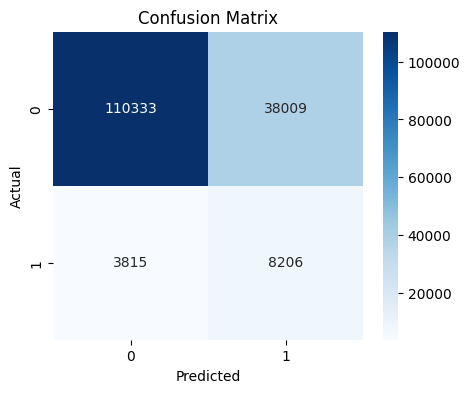

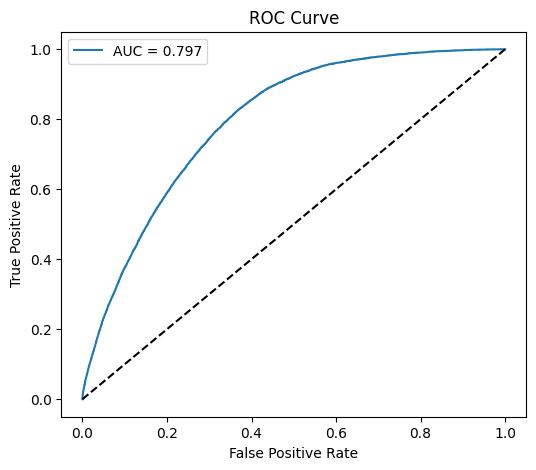

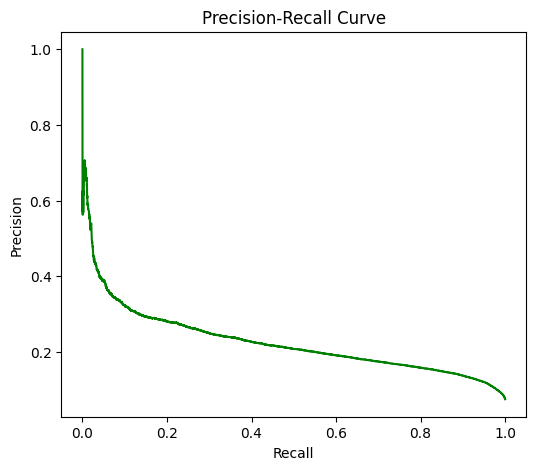

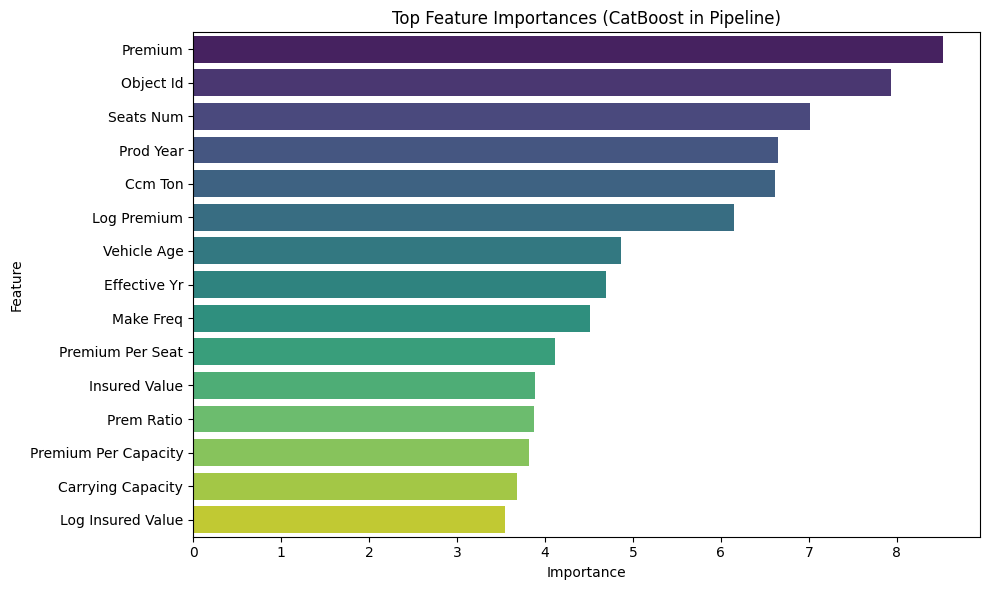

In [65]:
# Example: evaluate CatBoost or LogisticRegression
evaluate_classifier(pipeline, x_test, y_test, threshold=0.6, feature_names=x_test.columns)

# --- Clean feature names and replot importances ---

# 1) Grab fitted pieces
cat_model = pipeline.named_steps["model"]
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
importances = cat_model.feature_importances_

# 2) Clean names: remove "num__"/"cat__" and prettify
def clean_name(s: str) -> str:
    # remove sklearn prefix before double underscore
    if "__" in s:
        s = s.split("__", 1)[1]
    # optional: nicer display
    return s.replace("_", " ").title()

cleaned_names = [clean_name(s) for s in feature_names]

# 3) Pick top-k features
k = 15
top_idx = importances.argsort()[::-1][:k]
top_names = [cleaned_names[i] for i in top_idx]
top_vals  = importances[top_idx]

# 4) Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(x=top_vals, y=top_names, palette="viridis")
plt.title("Top Feature Importances (CatBoost in Pipeline)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



### Regression 

<Axes: ylabel='CLAIM_PAID'>

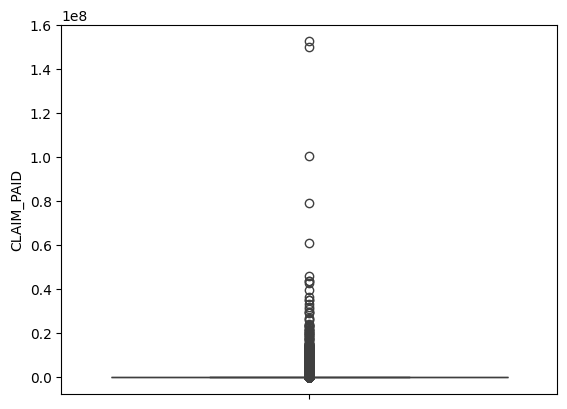

In [66]:
sns.boxplot(df['CLAIM_PAID'])

In [67]:
def train_claim_regressor(data, test_size=0.2, random_state=42):
    """
    Train & evaluate CatBoost Regressor on insurance claims dataset.
    data : pd.DataFrame (must include CLAIM_PAID)
    test_size : float, test split ratio
    random_state : int, reproducibility
    """

    print("Filtered dataset shape:", data.shape)

    # -----------------------------
    # Features & target
    # -----------------------------
    X = data.drop(columns=["CLAIM_PAID", "CLAIM_FLAG"], errors="ignore")
    y = data["CLAIM_PAID"]

    # -----------------------------
    # Train/Test split
    # -----------------------------
    x_train, x_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # -----------------------------
    # Preprocessing
    # -----------------------------
    numeric_cols = x_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = x_train.select_dtypes(exclude=[np.number]).columns.tolist()

    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_cols),
            ("cat", categorical_transformer, categorical_cols)
        ]
    )

    # -----------------------------
    # Model (CatBoost Regressor)
    # -----------------------------
    cat_model = CatBoostRegressor(
        iterations=500,
        depth=10,
        learning_rate=0.1,
        loss_function="MAE",
        verbose=50,
        random_seed=random_state
    )

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", cat_model)
    ])

    # Clean infinities
    x_train = x_train.replace([np.inf, -np.inf], np.nan)
    x_test = x_test.replace([np.inf, -np.inf], np.nan)

    # -----------------------------
    # Train & Evaluate
    # -----------------------------
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)

    print("\n===== Results on Claims Dataset =====")
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("y_test range:", (y_test.min(), y_test.max()))
    print("y_pred range:", (y_pred.min(), y_pred.max()))

    return pipeline, y_test, y_pred

In [68]:
def results_reg(data_filtered, y_test, y_pred, pipeline, top_k=15):
    """
    Show regression results: error metrics, plots, feature importances.
    data_filtered : pd.DataFrame with CLAIM_PAID
    y_test : true values
    y_pred : predicted values
    pipeline : trained pipeline (must contain 'model' step with CatBoost)
    top_k : number of top features to plot
    """

    # -------------------------------
    # Error Metrics
    # -------------------------------
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rel_error = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    std_claim = data_filtered["CLAIM_PAID"].std()

    print("===== Regression Results =====")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"Mean Relative Error (%): {rel_error:.2f}")
    print(f"Std of CLAIM_PAID: {std_claim:.2f}")

    # -------------------------------
    # Boxplot of target variable
    # -------------------------------
    plt.figure(figsize=(6,4))
    sns.boxplot(x=data_filtered['CLAIM_PAID'])
    plt.title("Distribution of CLAIM_PAID")
    plt.show()

    # -------------------------------
    # Predicted vs Actual
    # -------------------------------
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.4)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual CLAIM_PAID")
    plt.ylabel("Predicted CLAIM_PAID")
    plt.title("Predicted vs Actual")
    plt.tight_layout()
    plt.show()

    # -------------------------------
    # Feature Importances (CatBoost inside pipeline)
    # -------------------------------
    cat_model = pipeline.named_steps["model"]
    feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
    importances = cat_model.feature_importances_

    # Clean names
    def clean_name(s):
        return s.split("__", 1)[-1] if "__" in s else s

    cleaned_names = [clean_name(s) for s in feature_names]

    # Select top features
    top_idx = importances.argsort()[::-1][:top_k]
    top_names = [cleaned_names[i] for i in top_idx]
    top_vals  = importances[top_idx]

    plt.figure(figsize=(10,6))
    sns.barplot(x=top_vals, y=top_names, palette="viridis")
    plt.title("Top Feature Importances (CatBoost)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

Filtered dataset shape: (3623, 26)
0:	learn: 1241.0206415	total: 52.4ms	remaining: 26.1s
50:	learn: 964.3196383	total: 2.77s	remaining: 24.4s
100:	learn: 804.1339219	total: 5.37s	remaining: 21.2s
150:	learn: 711.7480300	total: 7.94s	remaining: 18.4s
200:	learn: 626.2263826	total: 10.5s	remaining: 15.6s
250:	learn: 576.9305033	total: 13s	remaining: 12.9s
300:	learn: 532.1785139	total: 15.6s	remaining: 10.3s
350:	learn: 498.8314307	total: 18.3s	remaining: 7.76s
400:	learn: 471.2641142	total: 20.8s	remaining: 5.15s
450:	learn: 447.8468934	total: 23.4s	remaining: 2.54s
499:	learn: 429.1081907	total: 25.9s	remaining: 0us

===== Results on Claims Dataset =====
MAE: 1267.973284547873
RMSE: 1526.9586127416746
y_test range: (np.float64(20015.17), np.float64(24999.52))
y_pred range: (np.float64(20149.86179180498), np.float64(24728.479641304046))
===== Regression Results =====
MAE: 1267.97
RMSE: 1526.96
Mean Relative Error (%): 5.66
Std of CLAIM_PAID: 1429.87


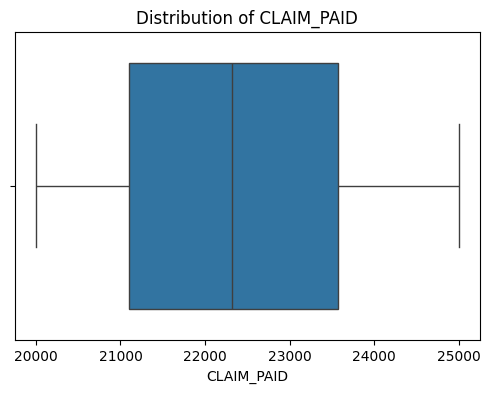

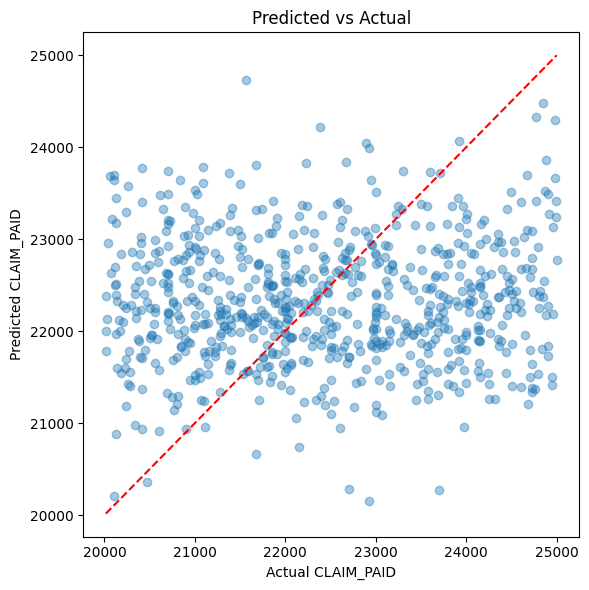

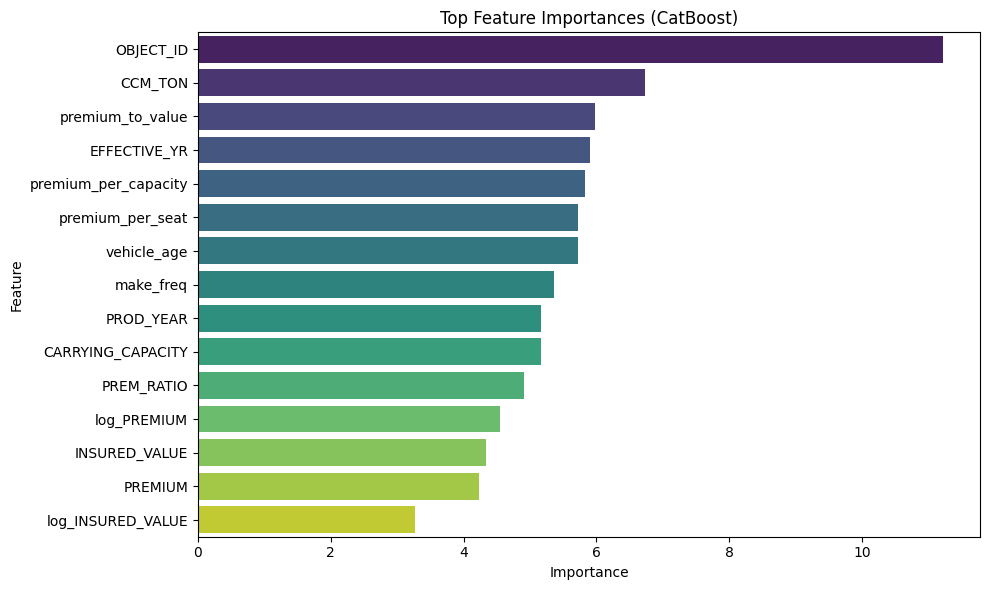

In [69]:
data_filtered = df[(df["CLAIM_PAID"] > 0.2*100000) & (df["CLAIM_PAID"] < 0.25*100000)]
pipeline, y_test, y_pred = train_claim_regressor(data_filtered, test_size=0.2, random_state=42)
results_reg(data_filtered, y_test, y_pred, pipeline)

Filtered dataset shape: (6233, 26)
0:	learn: 2392.1098657	total: 57.7ms	remaining: 28.8s
50:	learn: 2072.2018548	total: 2.9s	remaining: 25.5s
100:	learn: 1867.1215322	total: 5.78s	remaining: 22.8s
150:	learn: 1681.7844608	total: 8.61s	remaining: 19.9s
200:	learn: 1524.1694132	total: 11.5s	remaining: 17.1s
250:	learn: 1415.6250963	total: 14.4s	remaining: 14.3s
300:	learn: 1334.2880093	total: 17.2s	remaining: 11.3s
350:	learn: 1280.4852669	total: 20s	remaining: 8.5s
400:	learn: 1229.3266645	total: 22.9s	remaining: 5.66s
450:	learn: 1191.5709795	total: 25.7s	remaining: 2.8s
499:	learn: 1139.6229782	total: 28.6s	remaining: 0us

===== Results on Claims Dataset =====
MAE: 2494.564001353274
RMSE: 2978.786504896837
y_test range: (np.float64(20000.7), np.float64(29999.99))
y_pred range: (np.float64(20702.860296705894), np.float64(28237.229049254813))
===== Regression Results =====
MAE: 2494.56
RMSE: 2978.79
Mean Relative Error (%): 10.20
Std of CLAIM_PAID: 2823.42


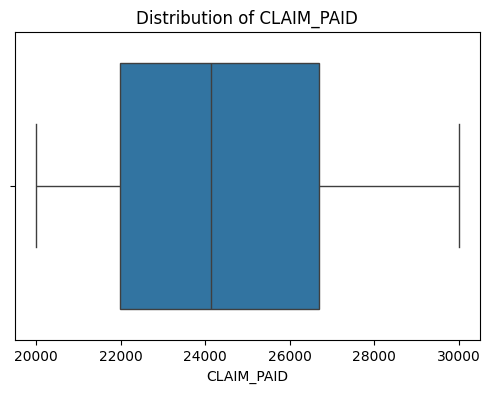

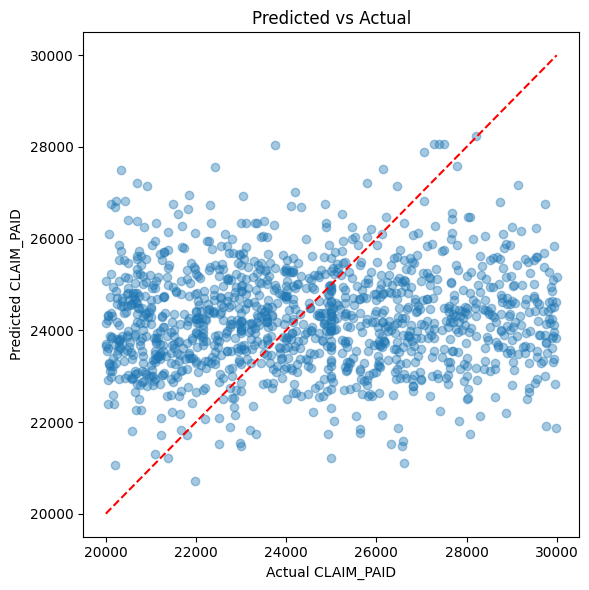

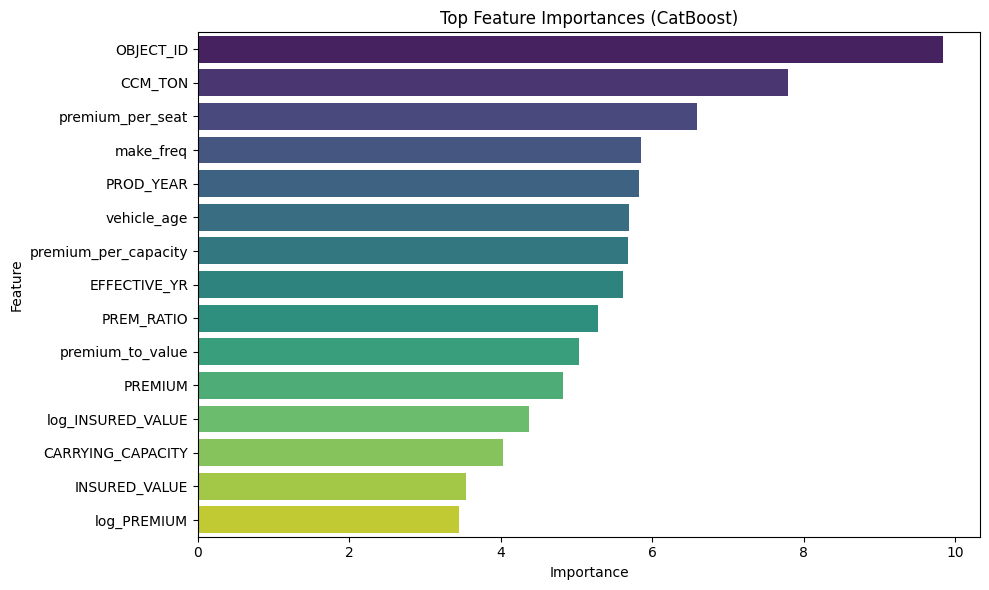

In [70]:
data_filtered = df[(df["CLAIM_PAID"] > 0.2*100000) & (df["CLAIM_PAID"] < 0.3*100000)]
pipeline, y_test, y_pred = train_claim_regressor(data_filtered, test_size=0.2, random_state=42)
results_reg(data_filtered, y_test, y_pred, pipeline)

Filtered dataset shape: (2730, 26)
0:	learn: 24618.5870686	total: 54.2ms	remaining: 27s
50:	learn: 18330.2340272	total: 2.64s	remaining: 23.2s
100:	learn: 15472.1585313	total: 5.18s	remaining: 20.5s
150:	learn: 12897.0433636	total: 7.88s	remaining: 18.2s
200:	learn: 11272.0954879	total: 10.6s	remaining: 15.7s
250:	learn: 10144.4855767	total: 13.2s	remaining: 13.1s
300:	learn: 9433.8117100	total: 15.9s	remaining: 10.5s
350:	learn: 8805.1013681	total: 18.5s	remaining: 7.86s
400:	learn: 8298.7890405	total: 21.2s	remaining: 5.23s
450:	learn: 7867.2489995	total: 23.9s	remaining: 2.6s
499:	learn: 7535.7021730	total: 26.5s	remaining: 0us

===== Results on Claims Dataset =====
MAE: 26809.79060086792
RMSE: 31716.688518477014
y_test range: (np.float64(200140.0), np.float64(299793.5))
y_pred range: (np.float64(212049.12830347312), np.float64(300104.25462550303))
===== Regression Results =====
MAE: 26809.79
RMSE: 31716.69
Mean Relative Error (%): 11.10
Std of CLAIM_PAID: 29029.23


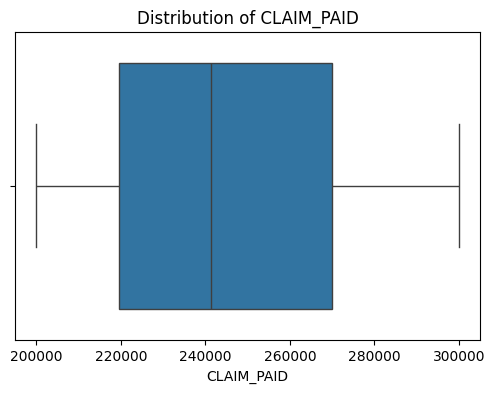

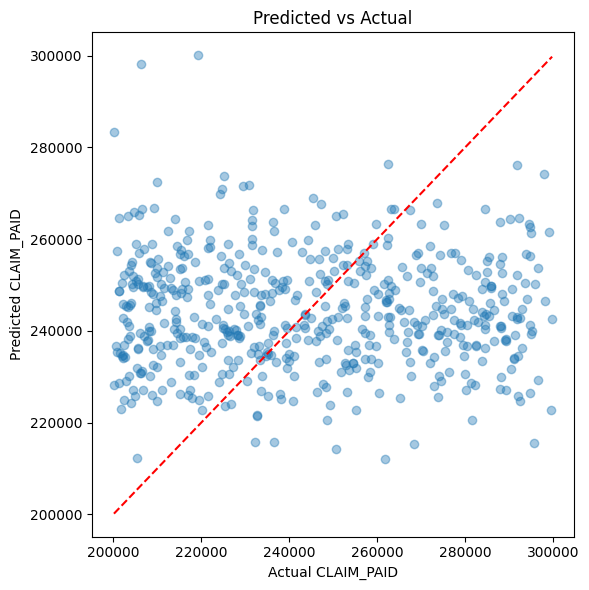

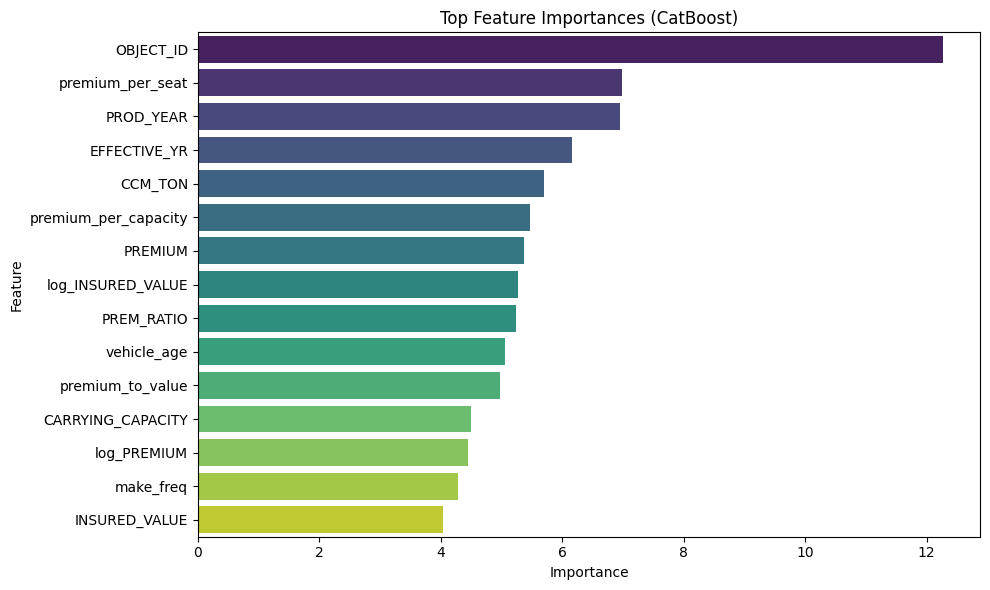

In [71]:
data_filtered = df[(df['CLAIM_PAID'] > 0.2*1000000) & (df['CLAIM_PAID'] < 0.3*1000000)]
pipeline, y_test, y_pred = train_claim_regressor(data_filtered, test_size=0.2, random_state=42)
results_reg(data_filtered, y_test, y_pred, pipeline)

Filtered dataset shape: (12199, 26)
0:	learn: 85965.2100937	total: 74.8ms	remaining: 37.3s
50:	learn: 78938.3931813	total: 3.42s	remaining: 30.1s
100:	learn: 75329.7568603	total: 7.07s	remaining: 27.9s
150:	learn: 72879.3463802	total: 10.8s	remaining: 24.9s
200:	learn: 70289.7755546	total: 14.4s	remaining: 21.4s
250:	learn: 68033.1015058	total: 17.8s	remaining: 17.6s
300:	learn: 66274.3450974	total: 21.2s	remaining: 14s
350:	learn: 64930.2189945	total: 24.7s	remaining: 10.5s
400:	learn: 63242.6698334	total: 28.2s	remaining: 6.97s
450:	learn: 61452.2379923	total: 36.8s	remaining: 3.99s
499:	learn: 60181.2250743	total: 47s	remaining: 0us

===== Results on Claims Dataset =====
MAE: 88130.89646916285
RMSE: 112131.71803027652
y_test range: (np.float64(100018.81), np.float64(498700.16))
y_pred range: (np.float64(105792.1314847531), np.float64(415117.60395615525))
===== Regression Results =====
MAE: 88130.90
RMSE: 112131.72
Mean Relative Error (%): 40.34
Std of CLAIM_PAID: 107295.31


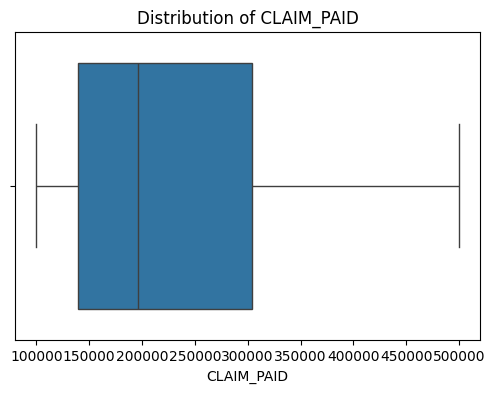

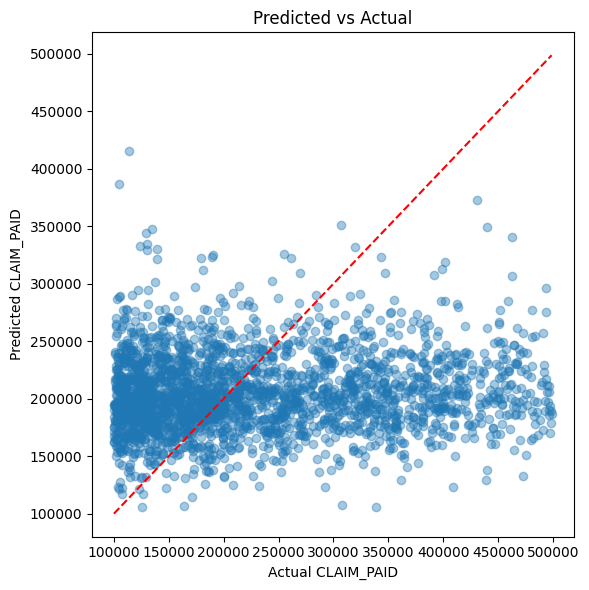

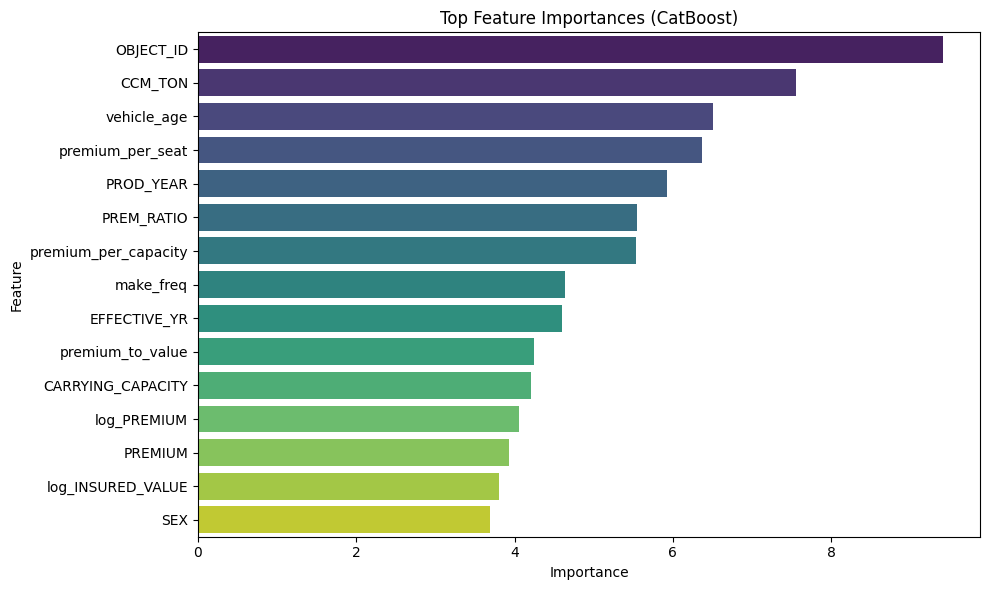

In [72]:
data_filtered = df[(df['CLAIM_PAID'] > 100000) & (df['CLAIM_PAID'] < 500000)]
pipeline, y_test, y_pred = train_claim_regressor(data_filtered, test_size=0.2, random_state=42)
results_reg(data_filtered, y_test, y_pred, pipeline)